# 1. SUMÁRIO DO PROJETO



- Link para a base de dados: https://www.kaggle.com/datasets/gcenachi/case-data-master-2024

1. Qual o contexto da problemática? O que queremos resolver?
  - Uma empresa de streaming de música adota uma abordagem reativa para reter clientes que não renovam a assinatura, oferecendo 3 meses gratuitos. No entanto, identificou-se que essa abordagem pode ser menos eficaz do que uma ação proativa, que antecipa o comportamento dos clientes. O objetivo é criar um modelo preditivo para identificar clientes com alta probabilidade de churn (cancelamento) nos próximos 3 meses após a data de observação. A definição de churn utilizada considera clientes que:
      - Possuem uma assinatura ativa no período de análise (data da safra);
      - Não renovaram ou não estão mais ativos nos 3 meses subsequentes.
  - O problema abordado, portanto, é o CHURN, com o foco em antecipar e evitar a saída de clientes.

2. Quais DADOS temos para trabalhar na solução?
  - Foi disponibilizado 3 tabelas:
      - Members: Dados demográficos e informações de cadastro dos clientes, como idade, gênero, data de registro e meio pelo qual se registraram.
      - Transactions: Informações sobre planos, pagamentos, cancelamentos e renovações de assinaturas, incluindo preços e datas de vencimento.
      - User Logs: Dados comportamentais e de uso, como o número de músicas ouvidas (por diferentes durações) e o total de segundos ouvidos.

3. Como chegar na solução e quais métodos/tecnologias podem apoiar e quais não podem? (justificação dos usos, questões de negócio, performance, processamento computacional, recursos e implantação em uma hipotética produtização)
  - Dada a escala dos dados, pensando na escalabilidade, performance, produtização e organização, optou-se por ferramentas capazes de lidar com processamento distribuido. Foi feita a ingestão dos dados dentro de um data lake criado no Google Drive, com a estrutura organizada em camadas Raw, Bronze, Silver e Gold, permitindo ingestão e transformações sistemáticas dos dados. Para isso, será usado o PySpark e suas bibliotecas e o Google Colab que se conecta com o Drive para realização do EDA, ETL e treinamento dos modelos.

4. Ótica de negócios: Ganhos $$
  - Após o estudo finalizado, deve-se levar em consideração que 50% dos clientes identificados como Churn no periodo analisado foram retidos e permaneceram ativos pelos proximos 12 meses. Desses 12 meses, entende-se pelo enunciado que, 3 meses serão os da ação de meses gratuitos, e os outros 9 serão pagos pelo cliente. Com isso, é possivel calcular o Retorno sobre o Investimento (ROI), que é dado por:

  $$
  \text{ROI} = \frac{\text{Ganho Gerado Pela Ação} - \text{Custo da ação}}{\text{Custo da ação}}
  $$

  - Assim através das colunas de valores dos planos de assinatura dos clientes, da para calcular o custo deles nos 3 meses gratuitos fornecidos (Custo da Ação) e o ganho dos outros 9 meses que ele irá pagar (Ganho Gerado Pela Ação). Esses resultados permitirão medir o impacto financeiro e a viabilidade da estratégia.

5. Segmentação dos clientes com uma abordagem não supervisionada
  - Após definido os churns e não churns, segmenta-los usando modelos de clusterização a fim de aprofundar a compreensão das características dos clientes  

para considerar no desenvolvimento:

1- EDA
- hipoteses voltadas ao problema e para a modelagem
- implicações das análises
- usar o EDA para tomada de decisões

2- Dataprep + feature engeneering + feature selection
- criação do publico-alvo, target, análise de volumetrias, missing, outliers, etc.
- construção de novas features / transformação de features
- feature selection adequado, variaveis significativas para o problema

3- Modelagem
- Estrutura do modelo utilizado, funcionamento, hiperparametros, vantagens e fraquezas
- Modelagem e pipe line adequados ao problema? eu entendo isso?
- Compreendo os impactos ao utilizar outras tecnicas de modelagem e pipeline construidos?

4- Validação
- Validação adequada? (Leakage, overfit, underfit, tamanho da amostra)
- Formas de validação exploradas? (cross-validation, train test split, out of sample, out of time, etc)
- Como as alterações do problema impactam na validação escolhida?

5- Definição e avaliação dos resultados
- Métricas de avaliação adequadas? (MAE, RMSE, Recall, AUC, Silhueta, etc)
- Como outras métricas impactariam os resultados do case?
- Como mudanças na estrutura do problema impactariam diferentes métricas?

6- Qualidade do código
- Organização e boas praticas do codigo (nomes intuitivos, comentários, ordenamento intuitivo)
- Codigo padronizado? (classes, funções e variaveis com nomes padronizados, clean code, pep8, etc?)
- Código visa a implementação? (modularização, tempo de processamento, versionamento etc?)

7- Soft Skills
- Sucinto e dentro do tempo indicado
- Clareza nas explicações
- Apresentação estruturada (começo, meio e fim)




# 2. Instalação do ambiente inicial



Conectando com o Google Drive (armazenamento)

Instalação do Java

Instalação do Apache Spark

Configuração do Spark

## 2.1 Conectando com o ambiente de armazenamento dos dados, Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Baixando e instalando o Java e o Spark

O Java pois o Spark precisa de um ambiente JVM para ser executado, por ser escrito em Scala.

E o Spark 3.4.4, compativel com o python do ambiente do google colab (3.10.12)

In [2]:
!python --version

Python 3.11.11


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark

## 2.3 Configurando o Spark

Configuração das variaveis ambiente

In [4]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

# tornar o pyspark "importável"
import findspark # localizar o Spark no seu sistema e adicionar o PySpark ao sys.path, tornando-o importável dentro do ambiente Python do Google Colab.
findspark.init() # inicia a busca pela instalação do Spark com base nas variáveis de ambiente e adiciona o PySpark ao sys.path

# iniciar uma sessão local
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .appName("Case_dataMaster_Victor") \
                    .config("spark.executor.memory", "6g") \
                    .config("spark.driver.memory", "4g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.driver.maxResultSize", "4g") \
                    .getOrCreate()

     #  # Memória do executor
     # Memória do driver
     # Número de núcleos
     # Tamanho máximo do resultado

# 3. Importando os dados da RAW

Dados baixados e localizados no google drive para nao tem repetição em acessar o ambiente do kaggle e baixar os dados de la

In [5]:
path_members = '/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/data_lake/raw/members.parquet'
path_transactions = '/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/data_lake/raw/transactions.parquet'
path_userlogs = '/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/data_lake/raw/user_logs.parquet'

df_members = (spark.read
                   .format("parquet")
                   .option("header", True)
                   .option("inferSchema", True)
                   .load(path_members))

df_transactions = (spark.read
                   .format("parquet")
                   .option("header", True)
                   .option("inferSchema", True)
                   .load(path_transactions))

df_userlogs = (spark.read
                   .format("parquet")
                   .option("header", True)
                   .option("inferSchema", True)
                   .load(path_userlogs))

## 3.1 Trazendo para uma view temporaria para consultas SQL

In [6]:
df_members.createOrReplaceTempView('tb_members')
df_transactions.createOrReplaceTempView('tb_transactions')
df_userlogs.createOrReplaceTempView('tb_userlogs')

# 4. Importando bibliotecas e funções necessárias para a exploração

In [7]:
from pyspark.sql.functions import col, countDistinct, count, min, max, when, to_date, year, mean, stddev, concat, lit

from pyspark.sql.types import *
from pyspark.sql.functions import *

# import select functions and types
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import floor, round

from pyspark.sql.window import Window

# 5. Inicio de EDA na camada RAW (Exploratory Data and Analysis)



Decidi iniciar estudando o dicionário de dados inicial fornecido e o formato das bases de dados, como quantidade de colunas e linhas e informações do schema das tabelas.

## 5.1 Dicionario de dados INICIAL

### 1. Transactions:
  - Colunas:
    - 1º 'mnso': id do usuário;
    - 2º 'payment_method_id': Método de pagamento;
    - 3º 'payment_plan_days': tamanho do plano em DIAS;
    - 4º 'plan_list_price': preço do respectivo plano em New Taiwan Dollar (NTD);
    - 5º 'actual_amount_paid': Total pago atual (nao entendi);
    - 6º 'is_auto_renew': Renovação automatica 1 ou 0;
    - 7º 'transaction_date': data da transação no formato %Y %M %D;
    - 8º 'membership_expire_date': quando o plano vence no formato %Y %M %D;
    - 9º 'is_cancel': se nessa transação o cliente cancelou ou não o plano;
    - 10º 'safra': data (Data foto da base).

### 2. User_logs:
  - Colunas:
    - 1º 'msno': id do usuário;
    - 2º 'safra': formato %Y %M %D (data foto da base);
    - 3º 'num_25': quantidade de músicas tocadas menos de 25% da duração dela;
    - 4º 'num_50': quantidade de músicas tocadas entre 25% e 50% da duração dela;
    - 5º 'num_75': quantidade de músicas tocadas entre 50% e 75% da duração dela;
    - 6º 'num_985': quantidade de músicas tocadas entre 75% e 98,5% da duração dela;
    - 7º 'num_100': quantidade de músicas tocadas acima de 98,5%;
    - 8º 'num_unq': quantidade de musicas tocadas apenas 1 vez;
    - 9º 'total_secs': total de segundos tocados.

### 3. Members:
  - Colunas:
    - 1º 'msno': id do usuário;
    - 2º 'city': cidade do usuário?
    - 3º 'bd': idade? obs: outliers em 2015
    - 4º 'gender': gênero
    - 5º 'registered_via': meio de registro do cliente
    - 6º 'registration_init_time': primeiro regristo do cliente formato %Y %M %D
    - 7º 'safra': Data da foto da base
    - 8º 'is_ativo': se o cliente esta ativo ou não

## 5.2 Entendendo o formato dos dados

In [ ]:
table = ['tb_members', 'tb_transactions', 'tb_userlogs']

for i in table:
  print(f'--------Tabela: {i}-------------------------')
  qnt_linhas = spark.sql(f'SELECT count(*) AS quantidade_linhas from {i}').collect()[0]['quantidade_linhas']
  df = spark.sql(f"SELECT * from {i}")
  qnt_colunas = len(df.columns)
  print(f"Formato da {i}: ", qnt_colunas, " X ", qnt_linhas )
  spark.sql(f'Describe {i}').show()

--------Tabela: tb_members-------------------------
Formato da tb_members:  8  X  63867246
+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                msno|   string|   null|
|               safra|   string|   null|
|registration_init...|   string|   null|
|                city|   string|   null|
|                  bd|   string|   null|
|              gender|   string|   null|
|      registered_via|   string|   null|
|            is_ativo|      int|   null|
+--------------------+---------+-------+

--------Tabela: tb_transactions-------------------------
Formato da tb_transactions:  10  X  20712225
+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                msno|   string|   null|
|   payment_method_id|   string|   null|
|   payment_plan_days|   string|   null|
|     plan_list_price|   string|   null|
|  actual_amount_paid|   st

Com a quantidade de registros na casa das dezenas de milhoes e formato dos dados visualizados, vou começar a entender cada tabela mais a fundo, e depois como elas se relacionam. Vou começar pela Members.

## 5.3 Entendendo a Members

### 5.3.1 Primeira visão

In [ ]:
spark.sql('select * from tb_members LIMIT 10').show()

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUg...|201612|              20140927|   1|  0|  null|             7|       1|
|++/AwGzubug3gT6J+...|201607|              20150322|   1|  0|  null|             9|       0|
|++/Gw1B9K+XOlB3hL...|201601|              20121217|  15| 32|  male|             3|       1|
|++02XbtviomSxcIBU...|201603|              20131112|  14| 21|  male|             7|       0|
|++0O0Bq04sB/9ZcOS...|201610|              20141021|   5| 33|  male|             3|       0|
|++2AQgVgYUAqJDw68...|201608|              20150416|  18| 23|  male|             3|       0|
|++2gRJ7i2MbO6qUG6...|201608|              20140616|  11| 33|  male|             7|       0|
|++3brN43Yd6GURegT...|201604|              20100512|  14| 19|  male|  

Nas primeiras 10 linhas ja vemos a idade = 0, e valores nulos no genero

### 5.3.2 Entendendo os valores de cada coluna da Members

In [ ]:
def executa_query_member_por_coluna(coluna):
  query = f"""
            select count(distinct {coluna}) as quantidade_distinta_{coluna}
            from tb_members
           """
  spark.sql(query).show()

for i in df_members.columns:
    print(i)
    executa_query_member_por_coluna(i)

msno
+------------------------+
|quantidade_distinta_msno|
+------------------------+
|                 6287789|
+------------------------+

safra
+-------------------------+
|quantidade_distinta_safra|
+-------------------------+
|                       12|
+-------------------------+

registration_init_time
+------------------------------------------+
|quantidade_distinta_registration_init_time|
+------------------------------------------+
|                                      4663|
+------------------------------------------+

city
+------------------------+
|quantidade_distinta_city|
+------------------------+
|                      21|
+------------------------+

bd
+----------------------+
|quantidade_distinta_bd|
+----------------------+
|                   385|
+----------------------+

gender
+--------------------------+
|quantidade_distinta_gender|
+--------------------------+
|                         2|
+--------------------------+

registered_via
+------------------------

Vamos começar explorando as safras e colunas de datas.

### 5.3.3 Min e Max de datas das colunas de datas para ver até onde vão

Convertendo os tipos de dados, pois algumas consultas estão vindo erradas por conta do formato das variaveis

In [ ]:
df_members = (df_members
              .withColumn('safra', col('safra').cast('int'))
              .withColumn('city', col('city').cast('int'))
              .withColumn('registration_init_time', to_date(col('registration_init_time'), 'yyyyMMdd'))
              .withColumn('bd', col('bd').cast('int'))
              .withColumn('registered_via', col('registered_via').cast('int'))
              .withColumn('is_ativo', col('is_ativo').cast('int'))
              )
df_members.createOrReplaceTempView('tb_members')

Decidi converter somente a registration_init_time para o formato de data nesse momento, pois a safra nao estava impactanto ainda.

Pegando o minimo e maximo das colunas referentes a datas

In [ ]:
(spark.sql(
    """
    select min(registration_init_time), max(registration_init_time),
           min(safra), max(safra)
    from tb_members
    """
  ).show()
)

+---------------------------+---------------------------+----------+----------+
|min(registration_init_time)|max(registration_init_time)|min(safra)|max(safra)|
+---------------------------+---------------------------+----------+----------+
|                 2004-03-26|                 2016-12-31|    201601|    201612|
+---------------------------+---------------------------+----------+----------+



Temos clientes que foram registrados 2016-12-31, e clientes antigos 2004.

Temos uma base de usuarios referente ao ano (safra) de 2016. Fotos dos clientes foram tiradas a cada mês, totalizando 12 fotos / 12 safras.

A partir disso, vamos entender como está distribuido os clientes por safra e tentar entender como esses clientes são registrados no banco de dados.

### 5.3.4 Entendendo a quantidade de usuarios por safra e repetição de Clientes

Decidi ver a quantidade de clientes separados por safra e contar esses clientes de duas formas:
1. Contagem geral de linhas por safra;
2. Contagem de IDs de usuarios (msno) sem repetições por safra.

Caso essa quantidade seja igual, não há repetição de cliente por safra.

Para facilitar essa comparação e visualização, fiz dentro da visualização da tabela esse check.

In [ ]:
(spark.sql(
    """
      select safra,
             count(msno) as qnt_geral,
             count(distinct msno) as qnt_distinct_msno,
             case when qnt_geral = qnt_distinct_msno then 1 else 0 end as check_colunas
      from tb_members
      group by 1
      order by 1 asc
    """
  ).show()
)

+------+---------+-----------------+-------------+
| safra|qnt_geral|qnt_distinct_msno|check_colunas|
+------+---------+-----------------+-------------+
|201601|  4294184|          4294184|            1|
|201602|  4502354|          4502354|            1|
|201603|  4697972|          4697972|            1|
|201604|  4876301|          4876301|            1|
|201605|  5060705|          5060705|            1|
|201606|  5250064|          5250064|            1|
|201607|  5439337|          5439337|            1|
|201608|  5615921|          5615921|            1|
|201609|  5778986|          5778986|            1|
|201610|  5949288|          5949288|            1|
|201611|  6114345|          6114345|            1|
|201612|  6287789|          6287789|            1|
+------+---------+-----------------+-------------+



Confirmado que a quantidade de ids distintos por safra, é igual a quantidade total de registros por safra, ou seja, clientes nao se repetem dentro de cada safra.

Se a cada safra não há clientes duplicados, só se repetem em diferentes safras, nos nossos registros da members um MSNO pode se repetir no máximo 12 vezes.

Confirmando isso

In [ ]:
(spark.sql(
    """
    WITH contagem_msno as
    (
      select msno,
             count(msno) AS quantidade
      from tb_members
      group by 1
    )
    select min(quantidade) as minimo,
           max(quantidade) as maximo
    from contagem_msno
    """
    ).show()
)

+------+------+
|minimo|maximo|
+------+------+
|     1|    12|
+------+------+



Confirmado. Max de repetição 12 e minimo 1 na base geral.

Temos 12 safras de registro, por isso max de 12 repetições e no minimo 1 para clientes que chegaram em 201612 no sistema ou possivelmente cancelaram ou não renovaram sua assinatura.

Voltando a analisar a primeira tabela, é possivel perceber que a quantidade de clientes por safra nunca diminui, logo a tabela members deve conter todos os usuarios que um dia ja passou pelo sistema, estando eles ainda assinantes ou não.

Vou pegar clientes que se registraram na safra 201602 (de forma aleatória) e acompanhar como está o status de is_ativo deles ao decorrer das safras. Para a hipotese de a members carregar clientes inativos em todas as safras, a mesma quantidade de clientes que se registraram em 201602 na safra 201602, deve ser a mesma encontrada na safra 201612.

Para isso, vou pegar a quantidade de registros por safra (indiferente usar o distinct ou não, aqui entendi que o MSNO e a SAFRA podem ser uma chave composta), filtrar somente clientes que se registraram na safra 201602 e se tiver clientes inativos ou ativos vou identifica-los em outras duas colunas. Para checar se essa separação esta sendo feita corretamente a soma delas tem que dar a quantidade total daquela safra.

Para complementar, vou fazer a porcentagem de clientes ativos para ter mais sensibilidade do que acontece de uma safra para outra.

In [ ]:
(spark.sql(
    """
      select safra,
             count(msno) as qnt_msno,
             count(distinct msno) as qnt_distinct_msno,
             sum(case when is_ativo = 1 then 1 else 0 end) as qnt_ativos,
             sum(case when is_ativo = 0 then 1 else 0 end) as qnt_nao_ativos,
             case when qnt_ativos + qnt_nao_ativos = qnt_distinct_msno then 1 else 0 end as check_ativos_e_nao,
             CONCAT(ROUND((qnt_ativos / qnt_distinct_msno) * 100, 1), '%') as taxa_ativos
      from tb_members
      where registration_init_time like '2016-02%'
      group by 1
      order by 1 asc
    """
  ).show()
)

+------+--------+-----------------+----------+--------------+------------------+-----------+
| safra|qnt_msno|qnt_distinct_msno|qnt_ativos|qnt_nao_ativos|check_ativos_e_nao|taxa_ativos|
+------+--------+-----------------+----------+--------------+------------------+-----------+
|201602|  208170|           208170|     30831|        177339|                 1|      14.8%|
|201603|  208170|           208170|     31351|        176819|                 1|      15.1%|
|201604|  208170|           208170|     26138|        182032|                 1|      12.6%|
|201605|  208170|           208170|     26342|        181828|                 1|      12.7%|
|201606|  208170|           208170|     25097|        183073|                 1|      12.1%|
|201607|  208170|           208170|     28118|        180052|                 1|      13.5%|
|201608|  208170|           208170|     27926|        180244|                 1|      13.4%|
|201609|  208170|           208170|     27943|        180227|         

- A diferença de quantidade de clientes da safra 201602 para a 201201 é:

$$ 4.502.354 - 4.294.184 = 208.170  $$

- Isso explica o porque o 208.170 aparece como quantidade total em todas as safras, ja que filtramos clientes que entraram na safra 201602.

- Dos 208 mil, poucos entram na base de dados como ativos, ou seja, da para entrar no sistema mas nao ser assinante.

- E pela flutuação das quantidades de ativos ao decorrer do tempo, os mesmos clientes parecem nao estar mais ativo e voltar a ser ativo depois. Ou pode ocorrer de clientes que começam no sistema só assinam depois.

A quantidade de novos clientes não são todos assinantes, ou seja, se registram no sistema e possuem o status is_ativo = 0.

Esses clientes na safra que se registraram ouviram música? Em geral, clientes que não possuem uma assinatura ativa, ou seja status is_ativo = 1, conseguem ouvir música?

Vamos entender isso mais a frente, ao analisarmos a tabela Userlogs.

Agora o foco é entender isoladamente primeiro a tabela members.

Vamos explorar na members, a quantidade de clientes ativos ou não por safra, entender a distribuição.

### 5.3.5 Entendendo a quantidade de ativos e não ativos por safra

In [ ]:
(spark.sql(
    """
      select safra,
             sum(case when is_ativo = 0 then 1 else 0 end) as qnt_nao_ativos,
             sum(case when is_ativo = 1 then 1 else 0 end) as qnt_ativos,
             count(distinct msno) as quantidade_total,
             case when qnt_ativos + qnt_nao_ativos = quantidade_total then 1 else 0 end as check_ativos_e_nao,
             CONCAT(ROUND((qnt_ativos / quantidade_total) * 100, 1), '%') as taxa_ativos,
             CONCAT(ROUND((qnt_nao_ativos / quantidade_total) * 100, 1), '%') as taxa_nao_ativos
      from tb_members
      group by 1
      order by 1 asc
    """
  ).show()
)

+------+--------------+----------+----------------+------------------+-----------+---------------+
| safra|qnt_nao_ativos|qnt_ativos|quantidade_total|check_ativos_e_nao|taxa_ativos|taxa_nao_ativos|
+------+--------------+----------+----------------+------------------+-----------+---------------+
|201601|       3405521|    888663|         4294184|                 1|      20.7%|          79.3%|
|201602|       3584238|    918116|         4502354|                 1|      20.4%|          79.6%|
|201603|       3826321|    871651|         4697972|                 1|      18.6%|          81.4%|
|201604|       4044736|    831565|         4876301|                 1|      17.1%|          82.9%|
|201605|       4211052|    849653|         5060705|                 1|      16.8%|          83.2%|
|201606|       4405180|    844884|         5250064|                 1|      16.1%|          83.9%|
|201607|       4471401|    967936|         5439337|                 1|      17.8%|          82.2%|
|201608|  

Maior parte dos clientes por safra são não ativos, comprovando que a members carrega o historico de clientes não ativos.  

E pensando superficialmente sobre o Churn estar relacionado a clientes não ativos, podemos enfrentar futuramente classes desbalanceadas para prever o Churn.

Como ja podemos capturar que há valores nulos na coluna de genero na primeira visão, vamos essas quantidades e ver se há valores nulos em outras colunas.

### 5.3.6 Vendo se há valores missing

Para verificar isso, vou usar as funcionalidades do SQL para trazer a informação das quantidades de nulos em cada coluna.

In [ ]:
(spark.sql(
    """
      SELECT
        SUM(CASE WHEN msno IS NULL THEN 1 ELSE 0 END) AS msno,
        SUM(CASE WHEN safra IS NULL THEN 1 ELSE 0 END) AS safra,
        SUM(CASE WHEN registration_init_time IS NULL THEN 1 ELSE 0 END) AS registration_init_time,
        SUM(CASE WHEN city IS NULL THEN 1 ELSE 0 END) AS city,
        SUM(CASE WHEN bd IS NULL THEN 1 ELSE 0 END) AS bd,
        SUM(CASE WHEN gender IS NULL THEN 1 ELSE 0 END) AS gender,
        SUM(CASE WHEN registered_via IS NULL THEN 1 ELSE 0 END) AS registered_via,
        SUM(CASE WHEN is_ativo IS NULL THEN 1 ELSE 0 END) AS is_ativo
      FROM tb_members
    """
  ).show()
)

+----+-----+----------------------+----+---+--------+--------------+--------+
|msno|safra|registration_init_time|city| bd|  gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+--------+--------------+--------+
|   0|    0|                     0|   0|  0|38210177|             0|       0|
+----+-----+----------------------+----+---+--------+--------------+--------+



38 milhoes de registros vazios da coluna de genêro, de um total de 63 milhoes, logo mais de 50% da coluna de genêro nula.

Estudar como esta a distribuição dos valores validos dos generos

In [ ]:
(spark.sql(
    """
      SELECT gender,
             count(*)
      FROM tb_members
      group by 1
    """
  ).show()
)

+------+--------+
|gender|count(1)|
+------+--------+
|  null|38210177|
|female|12581644|
|  male|13075425|
+------+--------+



Dentre os registros validos, a maior parte são homens, mas dada a proporção esta balanceado.

Vamos explorar como está esses Nulls por safra, se há uma concentração em alguma safra.

In [ ]:
(spark.sql(
    """
      SELECT safra,
             SUM(CASE WHEN gender IS NULL THEN 1 ELSE 0 END) AS gender_null,
             count(*) as total,
             CONCAT(ROUND((gender_null / total) * 100, 1), '%') as taxa_gender_null
      FROM tb_members
      group by 1
      order by 1
    """
  ).show()
)

+------+-----------+-------+----------------+
| safra|gender_null|  total|taxa_gender_null|
+------+-----------+-------+----------------+
|201601|    2290971|4294184|           53.4%|
|201602|    2469561|4502354|           54.9%|
|201603|    2639013|4697972|           56.2%|
|201604|    2793991|4876301|           57.3%|
|201605|    2955526|5060705|           58.4%|
|201606|    3120875|5250064|           59.4%|
|201607|    3285146|5439337|           60.4%|
|201608|    3438762|5615921|           61.2%|
|201609|    3581269|5778986|           62.0%|
|201610|    3730748|5949288|           62.7%|
|201611|    3875692|6114345|           63.4%|
|201612|    4028623|6287789|           64.1%|
+------+-----------+-------+----------------+



Hipotese: O 'null' em genero pode ser tanto erro sistemico quanto a opção de um cliente querer informar seu genero ou não, sendo assim um campo não obrigatório na hora do registro.

### 5.3.7 Vendo as estatisticas de todas as colunas

In [ ]:
df_members.describe().show(truncate = False)

+-------+--------------------------------------------+------------------+-----------------+------------------+--------+------------------+-------------------+
|summary|msno                                        |safra             |city             |bd                |gender  |registered_via    |is_ativo           |
+-------+--------------------------------------------+------------------+-----------------+------------------+--------+------------------+-------------------+
|count  |63867246                                    |63867246          |63867246         |63867246          |25657069|63867246          |63867246           |
|mean   |null                                        |201606.90368996028|4.369941346774214|11.430160210759675|null    |5.455677343594869 |0.17603491154135564|
|stddev |null                                        |3.4231736718522296|5.807596122789123|19.041318387984273|null    |2.4953863289564757|0.3808498703308826 |
|min    |+++4vcS9aMH7KWdfh5git6nA5fC5jjisd5H/N

Executando novamente após a correção dos tipos de dados

In [ ]:
def executa_query_member_por_coluna(coluna):
  query = f"""
            select count(distinct {coluna}) as quantidade_distinta_{coluna}
            from tb_members
           """
  spark.sql(query).show()

for i in df_members.columns:
    print(i)
    executa_query_member_por_coluna(i)

msno
+------------------------+
|quantidade_distinta_msno|
+------------------------+
|                 6287789|
+------------------------+

safra
+-------------------------+
|quantidade_distinta_safra|
+-------------------------+
|                       12|
+-------------------------+

registration_init_time
+------------------------------------------+
|quantidade_distinta_registration_init_time|
+------------------------------------------+
|                                      4663|
+------------------------------------------+

city
+------------------------+
|quantidade_distinta_city|
+------------------------+
|                      21|
+------------------------+

bd
+----------------------+
|quantidade_distinta_bd|
+----------------------+
|                   385|
+----------------------+

gender
+--------------------------+
|quantidade_distinta_gender|
+--------------------------+
|                         2|
+--------------------------+

registered_via
+------------------------

### 5.3.8 Observações e Questionamentos


 - Clientes cadastrados a mais de 10 anos (4663 dias distintos)
 - 21 cidades, min 1 max 22.
 - 385 idades distintas? algo esta muito errado.
 - 2 generos e mais da metade missing (analisar como essa variavel pode se comportar para o modelo)
 - 17 tipos de jeitos de se registrar diferentes, min -1 max 19, como?
 - Esses clientes na safra que se registraram ouviram música? Em geral, clientes que não possuem uma assinatura ativa, ou seja status is_ativo = 1, conseguem ouvir música?


A partir disso, buscarei entender a idade

### 5.3.9 Avaliando as idades 'bd'

#### 5.3.8.1 Primeira visão

Como vamos analisar isoladamente uma coluna no qual é 100% numerica, vamos entender as estatisticas desses valores com o Describe.

In [ ]:
df_members.select('bd').describe().show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63867246|
|   mean|11.430160210759675|
| stddev|19.041318387984273|
|    min|             -7168|
|    max|              2016|
+-------+------------------+



Um desvio padrão (stddev) maior que a média indica uma alta variância nos dados, ou seja, estão distantes da média. Logo, muito provavel ter valores ou muito altos ou muito baixos ou os dois, indicando Outliers. Como no enunciado ja dizia que havia outliers, isso já era esperado.

Vou buscar o minimo e maximo dessa coluna para confirmar os outliers.

#### 5.3.8.2 Minimo e maximo da 'bd'

Vou incluir a mediana pois o Describe não traz essa informação que ajuda a entender melhor a distribuição dos dados.

In [ ]:
(spark.sql(
    """
      select min(bd) as minimo,
             max(bd) as maximo,
             percentile_approx(bd, 0.5) AS mediana
      from tb_members
    """
  ).show()
)

+------+------+-------+
|minimo|maximo|mediana|
+------+------+-------+
| -7168|  2016|      0|
+------+------+-------+



Possue valores negativos. Como valores negativos são irreais para a idade de uma pessoa, para nosso contexto pode ser considerado um outlier. E também, após uma breve pesquisa sobre a pessoa mais velha do mundo no Google, encontrei diversos registros que vão de 112 anos até 124 anos de idade. Como os registros flutuam muito, decidi que para nosso contexto, valores para a idade acima de 125 anos são considerados improvaveis, erros sistemico, falha na captura da informação ou confusão do usuário ao se cadastrar.

Além disso, encontrei a mediana igual a 0. Vamos entender o porque disso.

A mediana é uma medida de posição central dos dados. Logo, se ordenarmos os 63 milhores de registros de idade do menor ao maior, achar o "meio" exato desse conjunto, a mediana estará lá (exceto para conjuntos pares, no qual se faz uma média simples entre os dois termos centrais). O termo central desses dados é 0. Para isso ocorrer, ou metade dos dados estão abaixo de zero e a outra metade acima de zero, ou vamos estudar o que está relacionado a esse resultado. Primeiro vou entender a quantidade de registro igual a zero.

In [ ]:
(spark.sql(
    """
      select count(bd)
      from tb_members
      where bd = 0
    """
  ).show()
)

+---------+
|count(bd)|
+---------+
| 39509864|
+---------+



Justificado a mediana ser igual a 0. Mais da metade dos dados dados são iguais a zero. Como zero não é uma idade valida para uma pessoa assinar um aplicativo de streamming de música, há uma possivel falha na captura dos dados, valores discrepantes, ou valores nulos. Vou entender como todos os valores estão distribuidos em torno do zero.

#### 5.3.8.3 Entendendo brevemente a distribuição das idades

Vou ver como as seguintes informações se comportam separadas por safra:

1. Minimos e máximos
2. 'bd' menores que zero
3. 'bd' iguais a zero
4. 'bd' entre 1 e 125
5. 'bd' maior que 125

Calcularei a porcentagem de valores dentro da faixa valida e a porcentagem de valores fora de uma faixa valida em relação ao total de registros, para entender a dimensão desses valores considerados invalidos entendidos.

$$\text{Faixa Válida} = \text{Valores maiores que 0 ou menores ou iguais a 125}$$

$$\text{Faixa Inválida} = \text{Valores menores ou iguais a zero ou valores acima de 125}$$

In [ ]:
(spark.sql(
    """
    SELECT
        safra,
        min(bd) AS minimo_per_safra,
        max(bd) AS maximo_per_safra,
        SUM(CASE WHEN bd < 0 THEN 1 ELSE 0 END) AS bd_menor_que_0,
        SUM(CASE WHEN bd = 0 THEN 1 ELSE 0 END) AS bd_igual_0,
        SUM(CASE WHEN bd >= 1 AND bd <= 125 THEN 1 ELSE 0 END) AS bd_entre_1_e_125,
        SUM(CASE WHEN bd > 125 THEN 1 ELSE 0 END) AS bd_maior_que_125,
        COUNT(bd) AS bd_total,
        CONCAT(ROUND(((bd_menor_que_0 + bd_maior_que_125 + bd_igual_0) / bd_total) * 100, 1), '%') as taxa_fora_da_idade,
        CONCAT(ROUND((bd_entre_1_e_125 / bd_total) * 100, 1), '%') as taxa_dentro_da_idade
    FROM tb_members
    group by 1
    order by 1 asc
    """
  ).show()
)

+------+----------------+----------------+--------------+----------+----------------+----------------+--------+------------------+--------------------+
| safra|minimo_per_safra|maximo_per_safra|bd_menor_que_0|bd_igual_0|bd_entre_1_e_125|bd_maior_que_125|bd_total|taxa_fora_da_idade|taxa_dentro_da_idade|
+------+----------------+----------------+--------------+----------+----------------+----------------+--------+------------------+--------------------+
|201601|           -7168|            2016|           252|   2397026|         1896590|             316| 4294184|             55.8%|               44.2%|
|201602|           -7168|            2016|           252|   2575730|         1926053|             319| 4502354|             57.2%|               42.8%|
|201603|           -7168|            2016|           252|   2745151|         1952244|             325| 4697972|             58.4%|               41.6%|
|201604|           -7168|            2016|           253|   2900828|         1974891|   

Em todas as safras há outliers. Valores considerados invalidos, segundo breves pesquisas, são a maior parte dos dados por conta dos valores iguais a zero.

Vou pegar a quantidade de cada faixa considerada valida ou invalida

In [ ]:
(spark.sql(
    """
    SELECT
        SUM(CASE WHEN bd = 0 THEN 1 ELSE 0 END) AS bd_0,
        SUM(CASE WHEN bd < 0 THEN 1 ELSE 0 END) AS bd_menor_0,
        SUM(CASE WHEN bd > 0 and bd <= 125 THEN 1 ELSE 0 END) AS bd_maior_0_menor_125,
        SUM(CASE WHEN bd > 125 THEN 1 ELSE 0 END) AS bd_maior_125,
        count(bd) as total,
        (bd_0 + bd_menor_0 + bd_maior_0_menor_125 + bd_maior_125) / total as checagem
    FROM tb_members
    """
  ).show()
)

+--------+----------+--------------------+------------+--------+--------+
|    bd_0|bd_menor_0|bd_maior_0_menor_125|bd_maior_125|   total|checagem|
+--------+----------+--------------------+------------+--------+--------+
|39509864|      3078|            24350288|        4016|63867246|     1.0|
+--------+----------+--------------------+------------+--------+--------+



Maior parte dos valores iguais a zero. Deve ser considerado outliers?

Outliers negativos e maiores que 125 somam 7 mil registros, uma quantidade baixa comparada a quantidade igual a zero. O que considerar outliers ou não? Como a quantidade igual a zero é gigante, vale o aprofundamento dessa decisão depois de entender melhor o entorno de toda a problemática e dos dados.

Alem de condições de senso comum (valores negativos para idade não existem e pessoas viverem mais de 125 anos), há outras técnicas para identificar outliers, como a Regra de Tukey e a aplicação do Z-Score.

Vamos explorar essas duas técnicas para ver seus resultados.

#### 5.3.8.4 Testando a Regra de Tukey pra identificar os outliers na coluna de idade

##### 5.3.8.4.1 O que é a Regra de Tukey?

o que é e suas formulas

##### 5.3.8.4.2 Aplicação na coluna BD

In [ ]:
quartis = (spark.sql(
    """
      SELECT
          percentile_approx(bd, 0.25) AS q1,
          percentile_approx(bd, 0.75) AS q3
      FROM tb_members
    """
))

quartis.show()

q1 = quartis.collect()[0]['q1']
q3 = quartis.collect()[0]['q3']

iqr = q3 - q1

low_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f'low_bound: {low_bound}, upper_bound: {upper_bound}')

+---+---+
| q1| q3|
+---+---+
|  0| 24|
+---+---+

low_bound: -36.0, upper_bound: 60.0


In [ ]:
(spark.sql(
    """
      SELECT
          count(bd) AS qtd
      FROM tb_members
      where bd between -36 and 0
    """
  ).show()
)

+--------+
|     qtd|
+--------+
|39510164|
+--------+



entendendo se há valores entre o 0 e -36 (low_bound). Segundo a regra de turkey, os zeros continuariam dentro dos limites dos dados, seriam considerados outliers somente valores abaixo de -36 e acima de 60

#### 5.3.8.5 Testando o Z-Score para identificação de outliers na coluna de idade

##### 5.3.8.5.1 O que é o Z-Score?

o que é e suas formulas

##### 5.3.8.5.2 Aplicação da coluna BD

In [ ]:
# Média e desvio padrão
stats = df_members.select(mean("bd").alias("mean"), stddev("bd").alias("stddev")).collect()[0]
mean_bd, stddev_bd = stats["mean"], stats["stddev"]

# Adicionando coluna Z-score
data = df_members.withColumn("z_score_bd", (col("bd") - mean_bd) / stddev_bd)

# Identificando outliers
data1 = data.filter((col("z_score_bd") > 3) | (col("z_score_bd") < -3))
data1.show()

# selecionar o minimo e maximo da coluna bd do data1
data1.select(min("bd"), max("bd")).show()

# Identificando os valores dentro da faixa
data2 = data.filter((col("z_score_bd") <= 3) & (col("z_score_bd") >= -3))
data2.show()

# selecionar o minimo e maximo da coluna bd do data2
data2.select(min("bd"), max("bd")).show()

+--------------------+------+----------------------+----+----+------+--------------+--------+------------------+
|                msno| safra|registration_init_time|city|  bd|gender|registered_via|is_ativo|        z_score_bd|
+--------------------+------+----------------------+----+----+------+--------------+--------+------------------+
|+2dTzutgLkNRioz1v...|201605|            2012-05-13|  13|1056|  male|             9|       0| 54.85806279298391|
|+2dTzutgLkNRioz1v...|201611|            2012-05-13|  13|1056|  male|             9|       0| 54.85806279298391|
|+6KQnpYZSbAo/BzhU...|201612|            2016-02-18|   1|  72|  male|             4|       0|3.1809688045267905|
|+9lhAdCG7Oqn1uaHu...|201602|            2015-10-19|   1|  99|female|             3|       0| 4.598937846892992|
|+AJ8Pi6sEse7yEc7j...|201604|            2011-08-13|   5| 105|female|             9|       0| 4.914042078529925|
|+AJ8Pi6sEse7yEc7j...|201610|            2011-08-13|   5| 105|female|             9|       0| 4.

### 5.3.10 Avaliando os meios de registro

In [ ]:
(spark.sql(
    """
      select count(distinct registered_via),
             count(registered_via),
             min(registered_via),
             max(registered_via)
      from tb_members
    """
  ).show(truncate = False)
)

+------------------------------+---------------------+-------------------+-------------------+
|count(DISTINCT registered_via)|count(registered_via)|min(registered_via)|max(registered_via)|
+------------------------------+---------------------+-------------------+-------------------+
|17                            |63867246             |-1                 |19                 |
+------------------------------+---------------------+-------------------+-------------------+



In [ ]:
(spark.sql(
    """
      select registered_via
      from tb_members
      group by 1
      order by 1 asc
    """
  ).show(truncate = False)
)

+--------------+
|registered_via|
+--------------+
|-1            |
|1             |
|2             |
|3             |
|4             |
|5             |
|6             |
|7             |
|8             |
|9             |
|10            |
|11            |
|13            |
|14            |
|16            |
|17            |
|19            |
+--------------+



Não tem o valor 18 e não tem o valor 15. O valor -1 pode indicar algo alem? Como talvez a falta dessa informação. Ou o -1 é uma escolha valida dentre os outros valores? Vamos ver a distribuição disso.

In [ ]:
(spark.sql(
    """
      select registered_via,
             count(registered_via) as qnt,
             CONCAT(ROUND(qnt / (select count(*) from tb_members) * 100, 1), '%') as taxa
      from tb_members
      group by 1
      order by 1 asc
    """
  ).show(truncate = False)
)

+--------------+--------+-----+
|registered_via|qnt     |taxa |
+--------------+--------+-----+
|-1            |12      |0.0% |
|1             |254     |0.0% |
|2             |16847   |0.0% |
|3             |18640987|29.2%|
|4             |19648219|30.8%|
|5             |18715   |0.0% |
|6             |3380    |0.0% |
|7             |8407395 |13.2%|
|8             |47588   |0.1% |
|9             |16776651|26.3%|
|10            |104     |0.0% |
|11            |269614  |0.4% |
|13            |7546    |0.0% |
|14            |7111    |0.0% |
|16            |10564   |0.0% |
|17            |6630    |0.0% |
|19            |5629    |0.0% |
+--------------+--------+-----+



Uma quantidade extremamente baixa. Dando maior peso na hipotese desse valor indicar talvez um nulo, ou erro/outlier. Concentração nos meios 3, 4, 7 e 9.

### 5.3.11 Considerações finais da tabela Members nessa exploração

1. Outliers:
  - identificados, porem está ainda por decidir o que fazer com a grande quantidade de valores iguais a 0.
  - Possiveis soluções para os outliers: Exclusão ou substituição. Decidir por meio de algo justificado o que será considerado como outliers para o tratamento da coluna (regra de turkey ou a logica de que a pessoa no mundo mais velha teve 125 anos e nao existe idade negativa, para a coluna BD) Analisar a correlação de churn com as variaveis e ver sua importancia.

2. Missing:
  - Identificados somente na coluna Gender e mensurados.
  - Mais de 50% desses dados são Nulos.
  - Hipotese da natureza do missing: informação não obrigatória no cadastro do usuário, apenas não informado ou erro na captura.

3. Colunas com tipos diferentes identificados sendo necessário transformar para a construção da bronze, pois atrapalhou algumas consultas.

4. Documentar:
  - Quantos valores foram removidos ou tratados?
  - Que critérios foram usados para identificar os valores inválidos?
  - Qual o impacto de substituir ou excluir? A quantidade de substituição ou exclusão é grande ou pequena?
  - Como a decisão tomada, como ela impacta em relação a vies nos dados?

## 5.4 Entendendo a Transaction

### 5.4.1 Partindo agora para entender a transaction. Prevendo que aconteça igual a members dos tipos de dados divergentes atrapalharem as consultas, já converterei eles.

In [ ]:
df_transactions = (df_transactions.withColumn('payment_method_id', col('payment_method_id').cast('int'))
                                  .withColumn('payment_plan_days', col('payment_plan_days').cast('int'))
                                  .withColumn('plan_list_price', col('plan_list_price').cast('float'))
                                  .withColumn('actual_amount_paid', col('actual_amount_paid').cast('float'))
                                  .withColumn('is_auto_renew', col('is_auto_renew').cast('int'))
                                  .withColumn('transaction_date', to_date(col('transaction_date'), 'yyyyMMdd'))
                                  .withColumn('membership_expire_date', to_date(col('membership_expire_date'), 'yyyyMMdd'))
                                  .withColumn('is_cancel', col('is_cancel').cast('int'))
                                  .withColumn('safra', col('safra').cast('int'))
                                  )
df_transactions.createOrReplaceTempView('tb_transactions')

### 5.4.2 Primeira visão

In [ ]:
spark.sql('select * from tb_transactions LIMIT 10').show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSk...|               38|              410|         1788.0|            1788.0|            0|      2015-11-21|            2017-01-04|        0|201511|
|+++snpr7pmobhLKUg...|               41|               30|          149.0|             149.0|            1|      2015-05-26|            2015-06-26|        0|201505|
|+++snpr7pmobhLKUg...|               41|               30|          149.0|             149.0|            1|      2015-09-26|            2015-10-26|        0|201509|
|++/9R3sX3

De primeira visão, nenhum fato incomum percebido. Visto valores de plan_list_price iguais a zero e o actual_amount_paid igual a zero também. Revisitando o dicionário de dados inicial, o Plan_list_price é o valor do plano assinado pelo cliente, e o actual_amount_paid, se usarmos a tradução literal, o valor real pago, é o valor que realmente entrou para a empresa, que foi debitado. Ao ver que o real pago é igual a zero enquanto plan_list_price possui um valor maior que zero(igual a 149, por exemplo), me questiono se essa é a indicação da ação atual da empresa de dar 3 meses de graça para quem cancelar. Vou buscar entender melhor como isso está registrado nos dados.


### 5.4.3 Entendendo os minimos e máximos das colunas de data

#### 5.4.3.1 Minimos e maximos da transaction_date, membership_expire_date e safra

In [ ]:
(spark.sql(
    """
    select min(transaction_date), max(transaction_date),
           min(membership_expire_date), max(membership_expire_date),
           min(safra), max(safra)
    from tb_transactions
    """
  ).show()
)

+---------------------+---------------------+---------------------------+---------------------------+----------+----------+
|min(transaction_date)|max(transaction_date)|min(membership_expire_date)|max(membership_expire_date)|min(safra)|max(safra)|
+---------------------+---------------------+---------------------------+---------------------------+----------+----------+
|           2015-01-01|           2017-02-28|                 1970-01-01|                 2017-03-31|    201501|    201702|
+---------------------+---------------------+---------------------------+---------------------------+----------+----------+



Data de expirar o plano em 1970? o primeiro usuario registrado foi em 2004, antes disso pode se considerar uma anomalia.

#### 5.4.3.2 Entendendo os dados não esperados na coluna de membership_expire_date

##### 5.4.3.2.1 Buscando entender qual o volume dos dados anteriores ao primeiro registro do primeiro cliente

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_transactions
      where membership_expire_date < '2004-03-26'
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|    1501|
+--------+



Essa é a quantidade de registros que tem o membership_expire_date antes do registro do primeiro cliente na base

Como esses clientes se dividem entre ativos ou não desses 1501? Com base nas safras, da para trazer essa informação?

In [ ]:
(spark.sql(
    """
      select min(safra), max(safra)
      from tb_transactions
      where membership_expire_date < '2004-03-26'
    """
  ).show()
)

+----------+----------+
|min(safra)|max(safra)|
+----------+----------+
|    201501|    201702|
+----------+----------+



Dos 1501, nem todos possuem safra equivalente na tabela members. Dentre esses registros, vamos focar no que da para trazer as informações da members.

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_transactions
      where membership_expire_date < '2004-03-26' and safra <= 201612 and safra >= 201601
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|      38|
+--------+



Dos 1501, somente 38 estão dentro das safras que temos registros da members. Vamos responder agora, Como esses clientes se dividem entre ativos ou não desses 38?

In [ ]:
(spark.sql(
    """
      select count(*) as total,
             SUM(CASE WHEN tb_members.is_ativo = 1 THEN 1 ELSE 0 END) AS ativo,
             SUM(CASE WHEN tb_members.is_ativo = 0 THEN 1 ELSE 0 END) AS nao_ativo,
             CONCAT(ROUND((ativo / total) * 100, 1), '%') as taxa_ativo,
             CONCAT(ROUND((nao_ativo / total) * 100, 1), '%') as taxa_nao_ativo
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' and tb_transactions.safra <= 201612 and tb_transactions.safra >= 201601
    """
  ).show()
)

+-----+-----+---------+----------+--------------+
|total|ativo|nao_ativo|taxa_ativo|taxa_nao_ativo|
+-----+-----+---------+----------+--------------+
|   38|   37|        0|     97.4%|          0.0%|
+-----+-----+---------+----------+--------------+



O que houve com o 1 que não esta contabilizando?

Como são 38 registros, o limite da visualização aqui no colab são de 20 linhas, logo vou dividir em 2 esses 38, e ordenar pela safra, assim consigo ver as 19 primeiras e depois as 19 ultimas separadas, para entender o que houve com o registro faltante.

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' and tb_transactions.safra <= 201612 and tb_transactions.safra >= 201601
      order by tb_transactions.safra asc
      limit 19
    """
  ).show(19, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|fUz06+tE+F8phKah92yclEuia0sIpwt7ns3wVJStVT8=|37               |30               |149.0 

O faltante não esta na primeira metade.

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' and tb_transactions.safra <= 201612 and tb_transactions.safra >= 201601
      order by tb_transactions.safra desc
      limit 19
    """
  ).show(19, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+
|49YbfSUKgdPqgBNjH++mlFkwNYGF02njbHdwZorvhCA=|13               |410              |178

Identificado. Por que esse registro, nessa safra, não foi encontrado na tabela members? vamos isolar esse ID e pesquisa-lo na transaction X members

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.msno = '+8/wL9CmrPsH4DVNtsODAJo5F46xqtfGqWpNiodKvRs='
      order by tb_transactions.safra desc
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+
|+8/wL9CmrPsH4DVNtsODAJo5F46xqtfGqWpNiodKvRs=|26               |1                |0.0            |0.0               |0            |2016-11-02      |2016-10-31            |0        |201611|null|null |null     

Poucas transações e nenhuma esta vinculada na members. Esse cliente está na member?

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '+8/wL9CmrPsH4DVNtsODAJo5F46xqtfGqWpNiodKvRs='
      order by safra desc
      limit 20
    """
  ).show(20, truncate=False)
)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



Cliente não possui registro na members. Clientes que transacionam não precisam estar registrados? por que esse cara não está? é uma regra ou excessão?

##### 5.4.3.2.2 Buscar entender se clientes que aparecem na transaction mas não aparece na members é uma regra ou excessão?

Os registros da tabela transaction de clientes que não aparecem na members, são de safras que não possuimos o historico.

In [ ]:
(spark.sql(
    """
      select min(tb_transactions.safra), max(tb_transactions.safra)
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno
      where tb_members.msno is null
    """
  ).show()
)

+----------+----------+
|min(safra)|max(safra)|
+----------+----------+
|    201501|    201702|
+----------+----------+



Vamos pegar somente:
- Transações que aconteceram nas safras de 201601 a 201602
- Contar o total de registro dessas transações
- Juntar esses registros com a tabela members, usando o ID e a safra como chave composta
- Dessa junção, esses IDs + Safra poderão ou não ser encontrados na members, e como o Left Join só tras registros encontrados da tabela inicial, os registros não encontrados virão como Null.
- Vamos contar os null e não null da member e checar se essa divisão esta batendo, com a soma da divisão tendo que dar a quantidade total.

In [ ]:
(spark.sql(
    """
      select count(*) as total,
             SUM(CASE WHEN tb_members.msno is null THEN 1 ELSE 0 END) AS msno_null,
             SUM(CASE WHEN tb_members.msno is not null THEN 1 ELSE 0 END) AS msno_not_null,
             CASE WHEN msno_null + msno_not_null = total THEN 1 ELSE 0 END as check
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.safra >= 201601 and tb_transactions.safra <= 201612
    """
  ).show()
)

+--------+---------+-------------+-----+
|   total|msno_null|msno_not_null|check|
+--------+---------+-------------+-----+
|10757847|  1367364|      9390483|    1|
+--------+---------+-------------+-----+



1.367.364 transações que ocorreram entre as safras 201601 e 201612 de clientes que não aparecem na tabela members. Por que isso ocorre?



In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.safra >= 201601 and tb_transactions.safra <= 201612 and tb_members.msno is null
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+
|++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc=|41               |30               |99.0           |99.0              |1            |2016-12-28      |2016-12-28            |1        |201612|null|null |null     

Estudando o primeiro caso, como ele aparece tanto na transaction quanto na members

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc='
      order by safra asc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc=|41               |30               |149.0          |0.0               |1            |2016-03-15      |2016-03-16            |1        |201603|
|++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc=|41               |30               |99.0           |99.0              |1            |2016-04-15      |2016-05-15            |0        |201604|
|++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc=|41       

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc='
    """
  ).show(20, truncate=False)
)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



Testando na Userlogs

In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno = '++CSmvB4ldSO0TeDSMWy9vH0M1oQJN0XXyM7sYLkoTc='
    """
  ).show(20, truncate=False)
)

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



- As safras estão dentro de 201601 e 201612
- A primeira transação foi em 201603, porem ele ja iniciou com um cancelamento?
- Não ouviu nenhuma música?

Não foi achado um padrão ou hipotese nos dados que explique o por que esse cliente não aparece na tabela members.


Testando um segundo caso

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM='
      order by safra desc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM=|41               |30               |149.0          |149.0             |1            |2016-12-14      |2016-12-15            |1        |201612|
|+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM=|41               |30               |149.0          |149.0             |1            |2016-11-03      |2016-12-03            |0        |201611|
|+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM=|41       

Cliente com historico de transação impecável, só cancelando na ultima, 201612

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM='
    """
  ).show(20, truncate=False)
)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno = '+/K8ofVtwRzqBkwb2q+7CnIgAobZd7+pPQw0a4egTZM='
    """
  ).show(20, truncate=False)
)

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



Realmente não aparece na tabela members misteriosamente. Sem justificativa plausivel do porque clientes transacionam mas não aparecem na Members e nem na Userlogs. Clientes que não ouvem música, mesmo pagando, não aparecem nas outras tabelas? Buscarei responder essa pergunta ao explorar a tabela user_logs.

E ao contrario, há clientes ativos na members que não aparecem na transactions e na userlogs?

In [ ]:
(spark.sql(
    """
      select count(*) as total,
             SUM(CASE WHEN tb_transactions.msno is null THEN 1 ELSE 0 END) AS msno_null_transaction,
             SUM(CASE WHEN tb_transactions.msno is not null THEN 1 ELSE 0 END) AS msno_not_null_transaction,
             SUM(CASE WHEN tb_userlogs.msno is null THEN 1 ELSE 0 END) AS msno_null_userlogs,
             SUM(CASE WHEN tb_userlogs.msno is not null THEN 1 ELSE 0 END) AS msno_not_null_userlogs,
             CASE WHEN msno_null_transaction + msno_not_null_transaction = total THEN 1 ELSE 0 END as check_transaction,
             CASE WHEN msno_null_userlogs + msno_not_null_userlogs = total THEN 1 ELSE 0 END as check_userlogs
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
      where tb_members.is_ativo = 1
    """
  ).show()
)

+--------+---------------------+-------------------------+------------------+----------------------+-----------------+--------------+
|   total|msno_null_transaction|msno_not_null_transaction|msno_null_userlogs|msno_not_null_userlogs|check_transaction|check_userlogs|
+--------+---------------------+-------------------------+------------------+----------------------+-----------------+--------------+
|11242865|              1852382|                  9390483|           1266985|               9975880|                1|             1|
+--------+---------------------+-------------------------+------------------+----------------------+-----------------+--------------+



1.852.382 clientes ativos da members não transacionaram ou ouviram musica em uma safra. Vamos entender se é por conta de planos maiores que 30 dias.

In [ ]:
(spark.sql(
    """
      select count(*) as total,
             SUM(CASE WHEN tb_transactions.msno is null THEN 1 ELSE 0 END) AS msno_null_transaction,
             SUM(CASE WHEN tb_transactions.msno is not null THEN 1 ELSE 0 END) AS msno_not_null_transaction,
             SUM(CASE WHEN tb_transactions.payment_plan_days > 30 THEN 1 ELSE 0 END) AS qnt_planos_acima_30,
             CASE WHEN msno_null_transaction + msno_not_null_transaction = total THEN 1 ELSE 0 END as check_transaction
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
      where tb_members.is_ativo = 1
    """
  ).show()
)

+--------+---------------------+-------------------------+-------------------+-----------------+
|   total|msno_null_transaction|msno_not_null_transaction|qnt_planos_acima_30|check_transaction|
+--------+---------------------+-------------------------+-------------------+-----------------+
|11242865|              1852382|                  9390483|             128108|                1|
+--------+---------------------+-------------------------+-------------------+-----------------+



In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
      where tb_members.is_ativo = 1 and tb_transactions.msno is null
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+-------------------

Pegando um primeiro caso

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
      where tb_members.msno = '++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI='
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+-------------------

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI='
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI=|38               |410              |1788.0         |1788.0            |0            |2015-11-22      |2017-01-05            |0        |201511|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+



Segundo caso

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
      where tb_members.msno = '++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4='
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4='
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4=|36               |30               |180.0          |180.0             |0            |2016-07-28      |2016-08-27            |0        |201607|
|++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4=|36               |30               |180.0          |180.0             |0            |2016-04-22      |2016-05-22            |0        |201604|
+--------------------------------------------+---------

No primeiro caso, se encaixa a ideia de que antes das safras que temos historico, o cliente assinou um plano que possuia muitos dias de assinatura. Já no segundo caso essa ideia ja não bate mais.

##### 5.4.3.2.3 Buscar entender alguns dos 37 casos

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno
       = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' AND tb_members.is_ativo = 1
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|fUz06+tE+F8phKah92yclEuia0sIpwt7ns3wVJStVT8=|37               |30               |149.0 

Pegando o primeiro registro (id) e entendendo o historico desse cliente

partindo da tabela transaction e entendendo suas transações

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno
       = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.msno = 'fUz06+tE+F8phKah92yclEuia0sIpwt7ns3wVJStVT8='
      order by tb_transactions.safra asc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+
|fUz06+tE+F8phKah92yclEuia0sIpwt7ns3wVJStVT8=|37               |31               |149

A membership_expire_date saiu do padrao na safra 201602 da tabela transaction, onde está indicado que ele cancelou sua assinatura.



Partindo agora da members e entendendo seu comportamento em relação as outras tabelas, outra perspectiva

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_transactions.msno = tb_userlogs.msno and tb_transactions.safra = tb_userlogs.safra
      where tb_members.msno = 'fUz06+tE+F8phKah92yclEuia0sIpwt7ns3wVJStVT8='
      order by tb_members.safra asc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

Historia hipotética baseada nos dados: Na safra de 201602, logo no inicio da safra no dia 07, o cliente que vinha sempre ativo, porém logo cancelou sua assinatura, onde deve ter acontecido erro sistemico na captura do membership_expire_date, ficando assim com data de 1970. Na safra 03 ele aparece inativo. O cliente voltou a assinar ao fim da safra 04, no dia 24. Ele aparece ativo na safra 04. Ao fim da safra 05, tambem no dia 24 ele resolveu cancelar a assinatura, mas voltou a assinar ao fim da safra 06, aparecendo ativo tanto na safra 05 quanto na 06.

Com essas informações até a safra 06, poderia afirmar que: para um cliente ser definido como inativo, ele nao pode ter nem se quer 1 dia ativo durante uma safra inteira, como ocorreu na safra 03. Porém essa afirmação é refutada logo na safra 07, onde ele não transaciona porem mesmo assim aparece ativo.

Sendo assim, muito inconsistente esses dados, sendo de dificil interpretação e possiveis erros sistemicos e informações faltantes.

Testanto a hipotese: Vendo se dos 37, a coluna is_cancel é igual a 1 (linhas de cancelamento)

In [ ]:
(spark.sql(
    """
      select SUM(CASE WHEN tb_transactions.is_cancel = 1 THEN 1 ELSE 0 END) as qnt_cancelamentos_dos_37
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' AND tb_members.is_ativo = 1
    """
  ).show(20, truncate=False)
)

+------------------------+
|qnt_cancelamentos_dos_37|
+------------------------+
|21                      |
+------------------------+



Dos que não são cancelamentos, vamos tentar entender pegando 3 casos:

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      left join tb_members
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_transactions.membership_expire_date < '2004-03-26' AND tb_members.is_ativo = 1 and tb_transactions.is_cancel = 0
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=|41               |30               |100.0 

Primeiro caso:

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_transactions.msno = tb_userlogs.msno and tb_transactions.safra = tb_userlogs.safra
      where tb_members.msno = '9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag='
      order by tb_members.safra
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

Segundo Caso:

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_transactions.msno = tb_userlogs.msno and tb_transactions.safra = tb_userlogs.safra
      where tb_members.msno = '49YbfSUKgdPqgBNjH++mlFkwNYGF02njbHdwZorvhCA='
      order by tb_members.safra
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-

Terceiro caso:

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      left join tb_userlogs
      on tb_transactions.msno = tb_userlogs.msno and tb_transactions.safra = tb_userlogs.safra
      where tb_members.msno = 'Xuo2D7awYUzimDJf5uSm1sS2KVHgEeO8gL5hOX5fMV8='
      order by tb_members.safra
    """
  ).show(20, truncate=False)
)


+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

Os três casos são completamente distintos, cada um trazendo caracteristicas e historias incompletas diferentes. Esses 37 registros em geral não podem ser considerados no problema por serem inconsistentes.

#### 5.4.3.3Conclusão

1. Membership_expire_date possui valores irreais. Essa inconsistencia pode ter sido causada por erro na captura das informações no sistema. Dentre esses erros o 1º são para clientes ativos em alguma safra, que a data pode ter "bugado" ao ser realizado alguma ação(cancelamento ou renovação da assinatura). O segundo caso é para clientes não ativos. Para esse caso nao foi identificado um padrao que de para interpretar algum erro ao certo, e o historico que esses clientes formam nas 3 bases são incoerentes.

2. Há transações de clientes que, sem justificativa ou padrão encontrado nos dados, não aparecem na tabela members e nem na tabela userlogs, podendo gerar alguns problemas dependendo da forma como conduziremos a criação da Target e Features.

### 5.4.4 Entendendo cada coluna da Transaction

In [ ]:
def executa_query_transaction_por_coluna(coluna):
  query = f"""
            select count(distinct {coluna}) as quantidade_distinta_{coluna}
            from tb_transactions
           """
  spark.sql(query).show()

for i in df_transactions.columns:
    print(i)
    executa_query_transaction_por_coluna(i)

msno
+------------------------+
|quantidade_distinta_msno|
+------------------------+
|                 2363626|
+------------------------+

payment_method_id
+-------------------------------------+
|quantidade_distinta_payment_method_id|
+-------------------------------------+
|                                   40|
+-------------------------------------+

payment_plan_days
+-------------------------------------+
|quantidade_distinta_payment_plan_days|
+-------------------------------------+
|                                   37|
+-------------------------------------+

plan_list_price
+-----------------------------------+
|quantidade_distinta_plan_list_price|
+-----------------------------------+
|                                 51|
+-----------------------------------+

actual_amount_paid
+--------------------------------------+
|quantidade_distinta_actual_amount_paid|
+--------------------------------------+
|                                    57|
+------------------------------

- 40 meios de pagamento
- 37 tamanhos de planos diferentes, (qnt de dias acumulados ativos?)
- 26 safras (201501 a 201702)
- 57 e 51 valores diferentes do plan_list_price e o actual_amount_paid?

In [ ]:
df_transactions.describe().show(truncate = False)

+-------+--------------------------------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|msno                                        |payment_method_id |payment_plan_days |plan_list_price   |actual_amount_paid|is_auto_renew     |is_cancel          |safra             |
+-------+--------------------------------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|count  |20712225                                    |20712225          |20712225          |20712225          |20712225          |20712225          |20712225           |20712225          |
|mean   |null                                        |38.926502005458126|31.428997850303382|140.24088353617248|142.83468555406287|0.8543830998359664|0.03287691206521752|201576.43902048186|
|stddev |null                                        |3

### 5.4.5 Entendendo os preços dos planos

#### 5.4.5.1 Passos iniciais

Minimos e maximos das colunas de preços

In [ ]:
(spark.sql(
    """
    select min(plan_list_price), max(plan_list_price),
           min(actual_amount_paid), max(actual_amount_paid),
           SUM(CASE WHEN plan_list_price = actual_amount_paid THEN 1 ELSE 0 END) AS qnt_iguais
    from tb_transactions
    """
  ).show()
)

+--------------------+--------------------+-----------------------+-----------------------+----------+
|min(plan_list_price)|max(plan_list_price)|min(actual_amount_paid)|max(actual_amount_paid)|qnt_iguais|
+--------------------+--------------------+-----------------------+-----------------------+----------+
|                 0.0|              2000.0|                    0.0|                 2000.0|  19114847|
+--------------------+--------------------+-----------------------+-----------------------+----------+



Estatisticas dos valores

In [ ]:
df_transactions.describe('plan_list_price', 'actual_amount_paid').show()

+-------+------------------+------------------+
|summary|   plan_list_price|actual_amount_paid|
+-------+------------------+------------------+
|  count|          20712225|          20712225|
|   mean|140.24088353617248|142.83468555406287|
| stddev|132.27679209056055|133.60944276809502|
|    min|               0.0|               0.0|
|    max|            2000.0|            2000.0|
+-------+------------------+------------------+



Desvio padrao proximo ao valor da média, indicando alta variação dos valores, ou seja, há muitos valores altos e muitos valores baixos, alta variação.

Vendo quais sao os valores que mais se repetem na coluna plan_list_price e actual_amount_paid

In [ ]:
(spark.sql(
    """
      select plan_list_price,
             payment_plan_days,
             count(plan_list_price) as qnt_plan_list_price
      from tb_transactions
      group by 1, 2
      order by 3 desc
      limit 20
    """
  ).show()
)

+---------------+-----------------+-------------------+
|plan_list_price|payment_plan_days|qnt_plan_list_price|
+---------------+-----------------+-------------------+
|          149.0|               30|           11247437|
|           99.0|               30|            4774736|
|          129.0|               30|            1096728|
|            0.0|                0|             848204|
|          149.0|               31|             743859|
|          180.0|               30|             655890|
|            0.0|                7|             513491|
|          150.0|               30|             360939|
|          894.0|              195|             107312|
|         1788.0|              410|              77481|
|          100.0|               30|              75569|
|          536.0|              180|              42850|
|          119.0|               30|              29215|
|          480.0|              100|              22736|
|            0.0|               10|             

Notado que para planos de 30 dias, há diversos valores de planos, sendo o mais comum o plano de 149 NTD para 30 dias, seguido de 99 e 129 para os mesmos 30 dias. há tambem pequenas variações de um possivel mesmo plano como 150 NTD , 149 NTD, valores proximos, 1 NTD de diferença ou 1 dia de diferença (30 e 31 dias)

Verificando a mesma informação com a coluna Actual_mount_paid

In [ ]:
(spark.sql(
    """
      select actual_amount_paid,
             payment_plan_days,
             count(plan_list_price) as qnt_plan_list_price
      from tb_transactions
      group by 1, 2
      order by 3 desc
      limit 20
    """
  ).show()
)

+------------------+-----------------+-------------------+
|actual_amount_paid|payment_plan_days|qnt_plan_list_price|
+------------------+-----------------+-------------------+
|             149.0|               30|           10505952|
|              99.0|               30|            4776059|
|             129.0|               30|            1098849|
|             149.0|                0|             764403|
|             149.0|               31|             727054|
|             180.0|               30|             655624|
|               0.0|                7|             513491|
|               0.0|               30|             470197|
|             150.0|               30|             360929|
|             119.0|               30|             299519|
|             894.0|              195|             107310|
|            1788.0|              410|              77478|
|             100.0|               30|              75569|
|             536.0|              180|              4285

Mesmo entendimento porem com algumas quantidades diferentes.

#### 5.4.5.2 Qual a diferença entre o plan_list_price e o actual_amount_paid?





##### 5.4.5.2.1 É a diferença entre o valor do plano e o valor que o cliente realmente paga? Para conseguir verificar caso aja descontos?

O plan list price é o valor do plano assinado, e o actual é o valor que o cliente ja pagou desde que se registrou?

In [ ]:
(spark.sql(
    """
      select count(*) AS total,
             sum(case when plan_list_price - actual_amount_paid > 0 then 1 else 0 end) AS actual_com_desconto,
             sum(case when plan_list_price - actual_amount_paid < 0 then 1 else 0 end) AS plan_com_desconto,
             sum(case when plan_list_price - actual_amount_paid = 0 then 1 else 0 end) AS iguais,
             case when actual_com_desconto + plan_com_desconto + iguais = total then 1 else 0 end as check_total
      from tb_transactions
    """
  ).show()
)

+--------+-------------------+-----------------+--------+-----------+
|   total|actual_com_desconto|plan_com_desconto|  iguais|check_total|
+--------+-------------------+-----------------+--------+-----------+
|20712225|             759467|           837911|19114847|          1|
+--------+-------------------+-----------------+--------+-----------+



Há valores maiores tanto na plan_list_price quanto na actual_amout_paid.

Por que há essa diferença? Se fosse apenas na coluna Actual, levaria em consideração a hipotese de desconto. No caso da Plan ter valores menores? Clientes de fato pagando a mais? O que seria esse a mais?

O 'check_total' está garantindo que essa divisão esta sendo feita corretamente, confirmando que realmente há esses valores.

##### 5.4.5.2.2 Estudando casos onde o plan_list é maior que o actual (possiveis descontos)

###### primeira visão

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where plan_list_price > actual_amount_paid
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc=|41               |30               |149.0          |0.0               |1            |2015-10-08      |2015-10-15            |1        |201510|
|++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=|41               |30               |149.0          |119.0             |1            |2015-06-11      |2015-07-11            |0        |201506|
|++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=|41       

###### Verificando com o primeiro cliente as infos

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc=|41               |30               |149.0          |0.0               |1            |2015-09-15      |2015-10-15            |0        |201509|
|++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc=|41               |30               |149.0          |0.0               |1            |2015-10-08      |2015-10-15            |1        |201510|
+--------------------------------------------+---------

Cliente transacionou porem com desconto, nao pagou e depois cancelou?

Vendo as informações desse caso na tabela members

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



Por que esse cliente nao aparece na members se toda safra aparentemente a members carrega todo o historico de clientes inativos? Tem como o cliente se excluir da base? deletar seus dados?

Verificando se aparece na userlogs

In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno = '++2wdWRV3Thy9HZyRJtKxlNsa55oDiDc7arR1guiypc='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



A safra indicada na tabela transactions diz 201610 e 09, a safra da userlogs vai de 2015 a 2017. Esse cliente transacionou mas nao esta registrado na members? uma hipotese de ele nao ter aparecido na user logs é nao ter ouvido musica, porem se ele transacionou, deveria estar na tabela members no meu entendimento, ja que possui o cadastro de todos os usuarios que ja passaram no sistema. Hipotese adotada: tem como o cliente se excluir do sistema mas restou dados transacionais.

###### Tentando com outro cliente, que esteja dentro das safras 201601 e 201612

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew='
      order by safra
      limit 26
    """
  ).show(26, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|41               |30               |149.0          |0.0               |1            |2016-01-25      |2016-02-24            |0        |201601|
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|41               |30               |149.0          |149.0             |1            |2016-02-24      |2016-03-24            |0        |201602|
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|41       

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew='
      order by safra
      limit 26
    """
  ).show(26, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201601|2016-01-25            |1   |0  |null  |7             |1       |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201602|2016-01-25            |1   |0  |null  |7             |1       |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201603|2016-01-25            |1   |0  |null  |7             |1       |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201604|2016-01-25            |1   |0  |null  |7             |1       |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201605|2016-01-25            |1   |0  |null  |7             |0       |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201606|2016-01-25 

Cliente se registrou na safra de 201601, com o plano de 149 mas pagando 0. Indicando um desconto no primeiro mes, e nos meses seguintes pagante. 3 safras depois ele cancelou a assinatura, na safra 04 de 2016. o vencimento era para o dia 24 do mes 04, mas a data de cancelamento mudou para o dia 05 da safra 04, indicando o dia que ele cancelou? Logo, quando um cliente cancela, a data de vencimento do plano se torna a data do cancelamento? ja que a transation_date ficou igual a membership_expire_date.

Hipotese para esse cliente faz sentido com os dados.

In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno = '++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew='
      order by safra
      limit 26
    """
  ).show(26, truncate=False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201601|9.0   |4.0   |2.0   |1.0    |273.0  |279.0  |69957.151         |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201602|66.0  |31.0  |29.0  |23.0   |978.0  |938.0  |254476.27200000003|
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201603|103.0 |38.0  |38.0  |21.0   |697.0  |832.0  |190586.52         |
|++OepqRK4wiYg4Chl+qqo7TrwM+i9KZc3Ez/Swbjjew=|201604|24.0  |8.0   |10.0  |7.0    |112.0  |158.0  |31880.351000000002|
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+



Na safra 01 ele ouviu 69 mil segundos, na segunda safra ouviu 254 mil segundos, na terceira a quantidade caiu para 190 mil segundos, e na quarta caiu novamente para 31 mil segundos.

Indicando que: A coluna de total_secs não é cumulativa, é o registro daquela safra. Indica que as outras colunas da user_logs tambem sigam esse padrao. A caida de total de segundos ouvidos podem estar relacionada com o cancelamento da assinatura.

##### 5.4.5.2.3 Estudando casos onde o actual_amount é maior que o plan_list (possivel juros?)

###### Primeira visão

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where plan_list_price < actual_amount_paid
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo=|34               |0                |0.0            |149.0             |1            |2015-06-30      |2015-07-31            |0        |201506|
|++bIcE+J/e/1b77I2Y3m+OJsqECiVfMeOLgX92evook=|33               |0                |0.0            |149.0             |1            |2015-07-31      |2015-08-31            |0        |201507|
|++bQIvTQ6j4h2pJWmhQD0XnUcTHk/ZfTjxExTJVPVr4=|21       

###### Testando com o primeiro cliente

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo=|34               |0                |0.0            |149.0             |1            |2015-03-31      |2015-04-30            |0        |201503|
|++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo=|34               |0                |0.0            |149.0             |1            |2015-06-30      |2015-07-31            |0        |201506|
|++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo=|34       

Vendo na tabela members

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno like '++Syx2taN9ulfO8hIpW/BKH30ODCidDkNy1jnr4MYlo='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



Por que esse cliente não aparece na members nem na userlogs? por que só na transactions? ele tem em todas as safras na transactions.


clientes aparecem na transactions mas nao aparecem na members nem na user logs.

###### Testando com outro cliente


In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where msno = '+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q='
      order by safra asc
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|23               |0                |0.0            |149.0             |1            |2015-03-31      |2015-04-30            |0        |201503|
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|23               |0                |0.0            |149.0             |1            |2015-06-30      |2015-07-31            |0        |201506|
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|23       

Dados antes da safra 201511 indica que o usuario entrou no sistema, sem um plano exato, e ja pagando 149 por mes. de 201503 a 201506 houve um gap de informações, que pode indicar um plano de 3 meses? apos 201511 temos dados do plano, pagamento, etc.

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      where msno = '+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201601|2014-03-20            |5   |24 |female|9             |1       |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201602|2014-03-20            |5   |24 |female|9             |1       |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201603|2014-03-20            |5   |24 |female|9             |1       |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201604|2014-03-20            |5   |24 |female|9             |1       |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201605|2014-03-20            |5   |24 |female|9             |1       |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201606|2014-03-20 

Cliente ativa em todas as safras da members presentes.

In [ ]:
(spark.sql(
    """
      select *
      from tb_userlogs
      where msno = '+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q='
      order by safra
      limit 20
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201501|103.0 |81.0  |28.0  |10.0   |635.0  |601.0  |166591.164        |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201502|211.0 |64.0  |34.0  |20.0   |697.0  |809.0  |188204.06399999995|
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201503|49.0  |20.0  |10.0  |6.0    |224.0  |296.0  |60614.495         |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201504|34.0  |14.0  |14.0  |7.0    |163.0  |186.0  |46552.971         |
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201505|98.0  |21.0  |20.0  |20.0   |131.0  |238.0  |43042.945999999996|
|+0jTOa6KGPk1vtNTwRDMZc/McUo41AeuwV3ndo54Y+Q=|201506|149

Aparece tambem na tabela userlogs. Nessa tabela, ela teve logs entre o gap das safras 201503 a 201506, apoiando a ideia de planos de 3 meses e falha na captura da informação.

#### 5.4.5.3 Conclusão

1. O plan_list_price é o valor do plano assinado pelo usuario. O actual_mount_paid é o real valor recebido do cliente naquela safra/transação.
2. A diferença para Plan_list_price maior que actual_mount_paid são possivels descontos iniciais nos planos de assinatura.
3. A diferença para Actual_mount_paid maior que plan_list_price são possiveis falhas na captura da informação.
4. Quando um cliente cancela, a data de vencimento do plano se torna a data do cancelamento? próximo passo a analisar.

In [ ]:
from pyspark.sql.functions import col, floor

# Suponha que a tabela seja chamada df e a coluna seja 'coluna_numero'
check_plan_list = df_transactions.filter(col("plan_list_price") != floor(col("plan_list_price")))
check_actual_amount = df_transactions.filter(col("actual_amount_paid") != floor(col("actual_amount_paid")))

# Mostrar os valores que possuem casas decimais
check_plan_list.show()
check_actual_amount.show()

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+---

e ambas n possuem valores com casas decimais, podendo ser mantidas como Integer

### 5.4.6 Vendo se há valores missing

In [ ]:
(spark.sql(
    """
      SELECT
        SUM(CASE WHEN msno IS NULL THEN 1 ELSE 0 END) AS msno,
        SUM(CASE WHEN payment_method_id IS NULL THEN 1 ELSE 0 END) AS payment_method_id,
        SUM(CASE WHEN payment_plan_days IS NULL THEN 1 ELSE 0 END) AS payment_plan_days,
        SUM(CASE WHEN plan_list_price IS NULL THEN 1 ELSE 0 END) AS plan_list_price,
        SUM(CASE WHEN actual_amount_paid IS NULL THEN 1 ELSE 0 END) AS actual_amount_paid,
        SUM(CASE WHEN is_auto_renew IS NULL THEN 1 ELSE 0 END) AS is_auto_renew,
        SUM(CASE WHEN transaction_date IS NULL THEN 1 ELSE 0 END) AS transaction_date,
        SUM(CASE WHEN membership_expire_date IS NULL THEN 1 ELSE 0 END) AS membership_expire_date,
        SUM(CASE WHEN is_cancel IS NULL THEN 1 ELSE 0 END) AS is_cancel,
        SUM(CASE WHEN safra IS NULL THEN 1 ELSE 0 END) AS safra
      FROM tb_transactions
    """
  ).show()
)

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|   0|                0|                0|              0|                 0|            0|               0|                     0|        0|    0|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+



Não há missing na tabela transactions.

### 5.4.7 Entendendo a quantidade de clientes por safra

In [ ]:
(spark.sql(
    """
      select safra,
             count(msno) as qnt_msno,
             count(distinct msno) as qnt_distinct_msno,
             case when qnt_msno = qnt_distinct_msno then 1 else 0 end as check_colunas
      from tb_transactions
      group by 1
      order by 4 asc
    """
  ).show()
)

+------+--------+-----------------+-------------+
| safra|qnt_msno|qnt_distinct_msno|check_colunas|
+------+--------+-----------------+-------------+
|201505|  571552|           571552|            1|
|201701|  988576|           988576|            1|
|201702|  885566|           885566|            1|
|201501|  548792|           548792|            1|
|201509|  714610|           714610|            1|
|201609|  982640|           982640|            1|
|201512|  861107|           861107|            1|
|201604|  774169|           774169|            1|
|201511|  820345|           820345|            1|
|201611| 1094941|          1094941|            1|
|201502|  545303|           545303|            1|
|201503|  626488|           626488|            1|
|201603|  775469|           775469|            1|
|201508|  705975|           705975|            1|
|201607|  924032|           924032|            1|
|201610| 1033898|          1033898|            1|
|201606|  804729|           804729|            1|


nao se repetem dentro de cada safra

### 5.4.8 Explorando a relação da coluna is_cancel com a membership_expire_date

Foi observado que para alguns casos, quando um cliente cancelava a assinatura, a membership_expire_date se tornava a data de cancelamento, ou seja, a transaction_date. Vamos entender essa hipotese.

estudando a distribuição de casa categoria

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 1 and membership_expire_date != transaction_date
    """
  ).show()
)

(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 1 and membership_expire_date = transaction_date
    """
  ).show()
)

(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 1
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|  312172|
+--------+

+--------+
|count(1)|
+--------+
|  368782|
+--------+

+--------+
|count(1)|
+--------+
|  680954|
+--------+



Isso não é uma regra. Hipotese invalida. Vamos ver casos ao contrario.

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 0 and membership_expire_date != transaction_date
    """
  ).show()
)

(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 0 and membership_expire_date = transaction_date
    """
  ).show()
)

(spark.sql(
    """
      select count(*)
      from tb_transactions
      where is_cancel = 0
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|20026697|
+--------+

+--------+
|count(1)|
+--------+
|    4574|
+--------+

+--------+
|count(1)|
+--------+
|20031271|
+--------+



a quantidade de 4574 de clientes não cancelados mas com datas iguais chama a tenção devido as proporções. Vamos entender um caso ao certo

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where is_cancel = 0 and membership_expire_date = transaction_date
      order by safra desc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|gMpRmwcBswN7CCODiX7JPv67/61zALD2Uc8qfXnvHnw=|33               |30               |149.0          |149.0             |1            |2017-02-28      |2017-02-28            |0        |201702|
|4Tp+3DAKzLN4gu+r85j5Dmi+H2fGKkP8cYM3uTi6mmM=|40               |30               |149.0          |0.0               |1            |2017-02-09      |2017-02-09            |0        |201702|
|55Zv1N50Z+LytogZ1qNWGfb4vVQUd2WKz8PM3qkhp8k=|40       

Para conseguirmos ver o historico, é necessario ver safras até 201612. Vamos ajustar

In [ ]:
(spark.sql(
    """
      select *
      from tb_transactions
      where is_cancel = 0 and membership_expire_date = transaction_date and safra <= 201612
      order by safra desc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+2N1ZFPfKoZUM4TzNDw9F1w1xw/vDrQO9roqZTDH3q4=|40               |30               |149.0          |0.0               |1            |2016-12-11      |2016-12-11            |0        |201612|
|RhfGOd/KWD1ZLy09VodASr+R867mXmImnsyCpnF3tVg=|40               |30               |149.0          |149.0             |1            |2016-12-20      |2016-12-20            |0        |201612|
|HexobMOql4QcNTevroypWHjmPQokDICpUFMwz00Pipc=|40       

pegando o segundo cliente, de forma aleatoria.

In [ ]:
(spark.sql(
    """
      select *
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_members.msno = 'RhfGOd/KWD1ZLy09VodASr+R867mXmImnsyCpnF3tVg='
      order by tb_members.safra asc
    """
  ).show(20, truncate=False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|RhfGOd/KWD1ZLy09VodASr+R867mXmImnsyCpnF3tVg=|201601|2012-12-23            |13  |25 |mal

a ideia de que se um clinete não transaciona independente das outras datas ele se torna inativo foi invalidada por esse registro desse cliente.

Notei que o is_auto_renew tanto no cliente observado na data que é igual, quanto em todos os registros anteriores, é igual a 1. Vamos checar se é para todos os casos.

In [ ]:
(spark.sql(
    """
      select count(*) as total,
             sum(case when is_auto_renew = 1 then 1 else 0 end) as is_auto_renew_1,
             sum(case when is_auto_renew = 0 then 1 else 0 end) as is_auto_renew_0,
             case when is_auto_renew_1 + is_auto_renew_0 = total then 1 else 0 end as check_total
      from tb_transactions
      where is_cancel = 0 and membership_expire_date = transaction_date
    """
  ).show(truncate = False)
)

+-----+---------------+---------------+-----------+
|total|is_auto_renew_1|is_auto_renew_0|check_total|
+-----+---------------+---------------+-----------+
|4574 |1749           |2825           |1          |
+-----+---------------+---------------+-----------+



Não é regra também.

Sem padrão encontrado para esses casos.

### 5.4.9 Observações e questionamentos



  - Data de vencimento do plano em 1970? Membership_expire_date possui valores irreais. Essa inconsistencia pode ter sido causada por erro na captura das informações no sistema. Dentre esses erros o 1º são para clientes ativos em alguma safra, que a data pode ter "bugado" ao ser cancelada a assinatura. O segundo caso é para clientes não ativos. Para esse caso nao foi identificado um padrao que de para interpretar algum erro ao certo, e o historico que esses clientes formam nas 3 bases são incoerentes.

  - Transações de 201501 a 201702

  - 40 meios de pagamentos

  - O plan_list_price é o valor do plano assinado pelo usuario. O actual_mount_paid é o real valor recebido do cliente naquela safra/transação. A diferença para Plan_list_price maior que actual_mount_paid são possivels descontos iniciais nos planos de assinatura. A diferença para Actual_mount_paid maior que plan_list_price são possiveis falhas na captura da informação. E ambas n possuem valores com casas decimais, podendo ser mantidas como Integer

  - Tipos dos dados estão atrapalhando as consultas em cima dos dados

  - Coluna is_cancel: entender como ela pode ajudar no nosso contexto

  - Não há missing

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_members
      left join tb_transactions
      on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
      where tb_members.is_ativo = 1 and tb_transactions.is_cancel = 1
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|  199458|
+--------+



## 5.5 Entendendo a User_logs

Os tipos de dados do schema da User_logs já estão em um formato coerente, não demandando uma conversão.

Sendo assim, podemos começar a explorar a userlogs buscando responder o seguinte:

1. Em geral, clientes não assinantes ou inativos conseguem ouvir musica?

2. Clientes que entram no sistema como não assinantes (is_ativo = 0) ouvem música mesmo assim?

3. Clientes que não ouvem música, mesmo pagando, não aparecem nas outras tabelas? testar se há quem não ouviu nada de música.

### 5.5.1 Primeira visão

In [ ]:
spark.sql("select * from tb_userlogs").show(20, truncate = False)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=|201701|121.0 |28.0  |14.0  |29.0   |704.0  |827.0  |184606.903        |
|rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=|201605|26.0  |2.0   |5.0   |6.0    |462.0  |256.0  |119439.485        |
|hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=|201611|161.0 |71.0  |49.0  |34.0   |668.0  |891.0  |204791.242        |
|53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=|201502|37.0  |9.0   |3.0   |9.0    |408.0  |447.0  |101186.041        |
|/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=|201506|205.0 |49.0  |23.0  |21.0   |225.0  |489.0  |69957.524         |
|qB/zteXKaOk3hzFCoIUD6wrTp57hnreDX4Vvon25MfM=|201509|52.

O tipo dos dados nessa tabela estão corretos, para construção da bronze nao sendo necessários essa alteração. Nenhuma anomalia observada de primeira vista.

### 5.5.2 Observando o Min e Max da coluna safra

In [ ]:
(spark.sql(
    """
      select min(safra), max(safra)
      from tb_userlogs
    """
  ).show()
)

+----------+----------+
|min(safra)|max(safra)|
+----------+----------+
|    201501|    201702|
+----------+----------+



### 5.5.3 Entendendo cada coluna da User_logs

Aqui temos somente variaveis númericas, nenhuma categorica, nao tendo relevância ver a distinção dos valores. por isso aqui farei somente o describe das colunas.

In [ ]:
df_userlogs.describe().show(truncate = False)

+-------+--------------------------------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|summary|msno                                        |safra            |num_25           |num_50           |num_75            |num_985           |num_100          |num_unq           |total_secs            |
+-------+--------------------------------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|count  |26758971                                    |26758971         |26758971         |26758971         |26758971          |26758971          |26758971         |26758971          |26758971              |
|mean   |null                                        |201572.0403868669|95.42601163549973|24.03566975725636|14.903521327483034|16.538671797207748|450.1598216538297|440.9193

Total de segundos negativos? E esse numero gigante na coluna de total_secs? como interpretar isso?

### 5.5.4 Vendo se há valores missing

In [ ]:
(spark.sql(
    """
      SELECT
        SUM(CASE WHEN msno IS NULL THEN 1 ELSE 0 END) AS msno,
        SUM(CASE WHEN num_25 IS NULL THEN 1 ELSE 0 END) AS num_25,
        SUM(CASE WHEN num_50 IS NULL THEN 1 ELSE 0 END) AS num_50,
        SUM(CASE WHEN num_75 IS NULL THEN 1 ELSE 0 END) AS num_75,
        SUM(CASE WHEN num_985 IS NULL THEN 1 ELSE 0 END) AS num,
        SUM(CASE WHEN num_100 IS NULL THEN 1 ELSE 0 END) AS num_100,
        SUM(CASE WHEN num_unq IS NULL THEN 1 ELSE 0 END) AS num_unq,
        SUM(CASE WHEN total_secs IS NULL THEN 1 ELSE 0 END) AS total_secs
      FROM tb_userlogs
    """
  ).show()
)

+----+------+------+------+---+-------+-------+----------+
|msno|num_25|num_50|num_75|num|num_100|num_unq|total_secs|
+----+------+------+------+---+-------+-------+----------+
|   0|     0|     0|     0|  0|      0|      0|         0|
+----+------+------+------+---+-------+-------+----------+



### 5.5.5 Entendendo a repetição de cada cliente por safra

In [ ]:
(spark.sql(
    """
      select safra,
             count(msno) as qnt_msno,
             count(distinct msno) as qnt_distinct_msno,
             case when qnt_msno = qnt_distinct_msno then 1 else 0 end as check_colunas
      from tb_userlogs
      group by 1
      order by 4 asc
    """
  ).show()
)

+------+--------+-----------------+-------------+
| safra|qnt_msno|qnt_distinct_msno|check_colunas|
+------+--------+-----------------+-------------+
|201505|  924216|           924216|            1|
|201701| 1136003|          1136003|            1|
|201702| 1114164|          1114164|            1|
|201501|  937789|           937789|            1|
|201509|  903194|           903194|            1|
|201609| 1112601|          1112601|            1|
|201512| 1039271|          1039271|            1|
|201604| 1042406|          1042406|            1|
|201511| 1041975|          1041975|            1|
|201611| 1183088|          1183088|            1|
|201502|  933040|           933040|            1|
|201503|  944739|           944739|            1|
|201603| 1048941|          1048941|            1|
|201508|  920129|           920129|            1|
|201607| 1102807|          1102807|            1|
|201610| 1139089|          1139089|            1|
|201606| 1081181|          1081181|            1|


cada safra cada os clientes nao se repetem.

### 5.5.6 Clientes que entram no sistema como não assinantes (is_ativo = 0) ouvem música mesmo assim?

In [ ]:
(spark.sql(
    """
        WITH
        tb_members_registro_tratado AS (
          SELECT *,
                CAST(YEAR(registration_init_time) * 100 + MONTH(registration_init_time) AS INT) AS registro_convertido
          FROM tb_members
          WHERE is_ativo = 0
        ),
        tb_joined AS (
          SELECT *,
                 tb_userlogs.msno AS msno_userlogs
          FROM tb_userlogs
          LEFT JOIN tb_members_registro_tratado
          ON tb_members_registro_tratado.msno = tb_userlogs.msno AND tb_members_registro_tratado.safra = tb_userlogs.safra
          WHERE tb_members_registro_tratado.registro_convertido = tb_userlogs.safra AND tb_members_registro_tratado.is_ativo = 0
        )
        SELECT count(*) as total,
               count(distinct msno_userlogs) as usuarios_distintos_dessa_lista
        FROM tb_joined
    """
  ).show(20, truncate = False)
)

+-------+------------------------------+
|total  |usuarios_distintos_dessa_lista|
+-------+------------------------------+
|1633965|1633965                       |
+-------+------------------------------+



Há um total de 1.633.965 registros de clientes que ouviram musica, no seu primeiro mês que não estavam ativos com uma assinatura.

### 5.5.7 Observações & Respondendo as questoes iniciais


#### 5.5.8.1 Respondendo as questões iniciais

- Em geral, clientes não assinantes ou inativos conseguem ouvir musica?

**Resposta**: Sim. Clientes que estão inativos e clientes que nao estão nem registrados conseguem ouvir música (respondido com o proximo topico 'Entendendo o Conjunto. Como se relacionam?').

- Clientes que entram no sistema como não assinantes (is_ativo = 0) ouvem música mesmo assim?

**Resposta**: Sim, há clientes que, no seu primeiro mes de registro não estavam ativos e mesmo assim ouviram música.

- Clientes que não ouvem música, mesmo pagando, não aparecem nas outras tabelas? testar se há quem não ouviu nada de música.

**Resposta**: Aparecem sim. Há clientes pagantes, ativos, que não ouvem música alguma (respondido com o proximo topico 'Entendendo o Conjunto. Como se relacionam?').

#### 5.5.8.2 Observações

  - Safra indo de 201501 a 201702.
  - Dados como Double, dando muita precisão.
  - Valores negativos para segundos totais de musicas ouvidas? Valores discrepantes para total de segs ouvidos identificados.
  - Não há valores faltantes
  - Decisão a ser tomada, o que considerar como outliers na coluna de total_secs? usar a regra de turkey? usar valores pesquisados como 15 mil minutos? converter de segundos para alguma outra escala como minutos ou horas, faz diferença nos processos ou só no final para melhor interpretabilidade?

### 5.5.8 Entendento o total de segundos ouvidos

#### 5.5.8.1 Identificando os outliers com o maximo de 30 dias por safra de segundos ouvidos

Sobre os valores do retorno do describe, quando possuem um 'E' no número, segundo a documentação do python (fonte: https://docs.python.org/pt-br/dev/library/string.html?utm_source=chatgpt.com), são interpretados da seguinte maneira:

- $$ -2.1171748863474203E13 = 2.1171748863474203 * 10 ^ {13} ≈ -21.17 \text{ trilhões} $$

- $$ 6.839043702349416E14 = 6.839043702349416 * 10^{14} ≈ 683.9 \text{ trilhões} $$

- $$ -2.3980767295724544E17 = 2.3980767295724544 * 10^{17} ≈ -239.8 \text{ quatrilhões} $$

- $$ 9.223372037135594E15 = 9.223372037135594 * 10^{15} ≈ 9.22 \text{ quatrilhões} $$

In [ ]:
segundos = 9.223372037135594 * (10**15)
minutos = segundos / 60
horas = minutos / 60
dias = horas / 24
meses = dias / 30
anos = meses / 12

print(segundos, minutos, horas, dias, meses, anos)

9223372037135594.0 153722867285593.22 2562047788093.22 106751991170.55084 3558399705.685028 296533308.8070857


O máximo da coluna total_secs está dando 296.533.308 de anos. Um valor irreal. E tempo negativo tambem não existe. Nessa proporção de trilhoes de segundos também fica irreal.

In [ ]:
um_mes_em_segundos = 30 * 24 * 60 * 60 # Anos * Dias * Horas * Minutos * Segundos
print(um_mes_em_segundos)

2592000


Como foi observado nas explorações das tabelas anteriores, cada safra na userlogs carrega uma quantidade total ouvida naquele mes isoladamente, não sendo uma visão acumulada. Considerando que um mês tem 30 dias: são 2.592.000 de segundos. Vejamos quantos usuarios ouviram mais de um mês em segundos, sendo um valor improvavel ja que carrega a informação sobre o periodo da safra.

In [ ]:
# Contar quantos total_secs tem para baixo de zero, e acima de um_mes_em_segundos

(spark.sql(
    """
      select count(total_secs) as negativos
      from tb_userlogs
      where total_secs < 0
    """
  ).show()
)

(spark.sql(
    f"""
      select count(total_secs) as acima_de_1_mes
      from tb_userlogs
      where total_secs >= {um_mes_em_segundos}
    """
  ).show()
)

+---------+
|negativos|
+---------+
|    42346|
+---------+

+--------------+
|acima_de_1_mes|
+--------------+
|          1989|
+--------------+



Calcular os quartis e ver a distribuição dos valores por quartil

In [ ]:
# Pegando o 1, 2, 3 e 4 quartil da coluna total_Secs, e vendo a quantidade por intervalos

(spark.sql(
    """
    WITH quartis AS (
        SELECT
            count(*) as total,
            percentile_approx(total_secs, 0.25) AS q1,
            percentile_approx(total_secs, 0.5) AS q2,
            percentile_approx(total_secs, 0.75) AS q3,
            percentile_approx(total_secs, 1) AS q4
        FROM tb_userlogs
    )
    SELECT SUM(CASE WHEN total_secs <= (SELECT q1 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q1,
           SUM(CASE WHEN total_secs > (SELECT q1 FROM quartis) AND total_secs <= (SELECT q2 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q1_q2,
           SUM(CASE WHEN total_secs > (SELECT q2 FROM quartis) AND total_secs <= (SELECT q3 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q2_q3,
           SUM(CASE WHEN total_secs > (SELECT q3 FROM quartis) AND total_secs <= (SELECT q4 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q3_q4,
           CASE WHEN faixa_q1 + faixa_q1_q2 + faixa_q2_q3 + faixa_q3_q4 = (SELECT total FROM quartis) THEN 1 ELSE 0 END AS check_total
    FROM tb_userlogs
    """
  ).show()
)


+--------+-----------+-----------+-----------+-----------+
|faixa_q1|faixa_q1_q2|faixa_q2_q3|faixa_q3_q4|check_total|
+--------+-----------+-----------+-----------+-----------+
| 6689299|    6689489|    6689507|    6690676|          1|
+--------+-----------+-----------+-----------+-----------+



In [ ]:
# Separando os Negativos para entender as dimensões

(spark.sql(
    """
    WITH quartis AS (
        SELECT
            count(*) as total,
            percentile_approx(total_secs, 0.25) AS q1,
            percentile_approx(total_secs, 0.5) AS q2,
            percentile_approx(total_secs, 0.75) AS q3,
            percentile_approx(total_secs, 1) AS q4
        FROM tb_userlogs
    )
    SELECT SUM(CASE WHEN total_secs < 0 THEN 1 ELSE 0 END) AS faixa_negativos,
           SUM(CASE WHEN total_secs > 0 and total_secs <= (SELECT q1 FROM quartis) THEN 1 ELSE 0 END) AS faixa_0_q1,
           SUM(CASE WHEN total_secs > (SELECT q1 FROM quartis) AND total_secs <= (SELECT q2 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q1_q2,
           SUM(CASE WHEN total_secs > (SELECT q2 FROM quartis) AND total_secs <= (SELECT q3 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q2_q3,
           SUM(CASE WHEN total_secs > (SELECT q3 FROM quartis) AND total_secs <= (SELECT q4 FROM quartis) THEN 1 ELSE 0 END) AS faixa_q3_q4,
           CASE WHEN faixa_negativos + faixa_0_q1 + faixa_q1_q2 + faixa_q2_q3 + faixa_q3_q4 = (SELECT total FROM quartis) THEN 1 ELSE 0 END AS check_total
    FROM tb_userlogs
    """
  ).show()
)


+---------------+----------+-----------+-----------+-----------+-----------+
|faixa_negativos|faixa_0_q1|faixa_q1_q2|faixa_q2_q3|faixa_q3_q4|check_total|
+---------------+----------+-----------+-----------+-----------+-----------+
|          42346|   6646953|    6689489|    6689507|    6690676|          1|
+---------------+----------+-----------+-----------+-----------+-----------+



Outliers em uma das duas extremidades dos dados identificados: 42 mil registros negativos na total secs.

Vamos ver como podemos identificar os outliers da outra extremidade, pois a quantidade de registro separada por faixa de quartil está bem distribuida.

Há valores iguais a zero na coluna total secs?

In [ ]:
(spark.sql(
    """
      select count(*)
      from tb_userlogs
      where total_secs = 0
    """
  ).show()
)

+--------+
|count(1)|
+--------+
|       0|
+--------+



Não, não há.

#### 5.5.8.2 Aplicando a regra de Turkey para identificar os outliers

In [ ]:
quartis = (spark.sql(
    """
      SELECT
          percentile_approx(total_secs, 0.25) AS q1,
          percentile_approx(total_secs, 0.75) AS q3
      FROM tb_userlogs
    """
))

quartis.show()

q1 = quartis.collect()[0]['q1']
q3 = quartis.collect()[0]['q3']

iqr = q3 - q1

low_bound_total_secs = q1 - 1.5 * iqr
upper_bound_total_secs = q3 + 1.5 * iqr

print(f'low_bound: {low_bound_total_secs}, upper_bound: {upper_bound_total_secs}')

+---------+----------+
|       q1|        q3|
+---------+----------+
|11021.553|152111.487|
+---------+----------+

low_bound: -200613.348, upper_bound: 363746.38800000004


Entendo que o low_bound tem que ser 0, pois nao há valores negativos para tempo. Consideraremos valores acima do upper_bound e abaixo de 0 como outliers.

In [ ]:
segundos = 363746
minutos = segundos / 60
horas = minutos / 60
dias = horas / 24
meses = dias / 30
anos = meses / 12

print("Segundos: ", segundos, "| Minutos: ", minutos, "| Horas: ", horas)
print("Dias:", dias, "| Meses: ", meses, "| Anos: ", anos)

Segundos:  363746 | Minutos:  6062.433333333333 | Horas:  101.04055555555556
Dias: 4.2100231481481485 | Meses:  0.14033410493827161 | Anos:  0.011694508744855968


Utilizando a regra de turkey, usuarios que ouviram acima de 363 mil segundos, equivalente a 6062 minutos, 101 horas e 4 dias, é considerado um outlier.

Esse valor pode ser apropriado, pois segundo a pesquisa "Engaging with Music 2023", a média global de horas ouvidas semanais ficou em torno de 20,7 horas semanais. Nessa pesquisa, os Nigerianos se superam, tendo uma média semanal de 31,1 horas ouvidas por semana! Com base nas respostas de mais de 43 mil pessoas em 26 países, o relatório é a maior pesquisa global com este tipo de enfoque. (fonte: https://www.ifpi.org/wp-content/uploads/2023/12/IFPI-Engaging-With-Music-2023_full-report.pdf)

Mas e o valor para o Low_bound? é apropriado? Na teoria os valores menores de 0 deveriam ser tratados como outliers pois não existe tempo negativo. Vou testar a diferença entre usar o Low_bound fornecido pela tecnica contra usar o zero como low_bound e ver se há diferença e seus efeitos. E ja ver como fica a quantidade de outliers em relação ao total.

In [ ]:
# Utilizando e contando usanod o low fornecido pela aplicação da regra

(spark.sql(
    f"""
      select count(total_secs) as total,
             sum(case when total_secs < {low_bound_total_secs} or total_secs > {upper_bound_total_secs} then 1 else 0 end) as qnt_outliers,
             sum(case when total_secs >= {low_bound_total_secs} and total_secs <= {upper_bound_total_secs} then 1 else 0 end) as qnt_dentro_da_faixa,
             CONCAT(ROUND((qnt_dentro_da_faixa / total) * 100, 3), '%') as taxa_dentro,
             CONCAT(ROUND((qnt_outliers / total) * 100, 3), '%') as taxa_de_outliers,
             sum(case when total_secs <= {low_bound_total_secs} then 1 else 0 end) as outliers_low,
             sum(case when total_secs >= {upper_bound_total_secs} then 1 else 0 end) as outliers_upper
      from tb_userlogs
    """
  ).show()
)

# mudando o low_bound_total_secs para 0 e comparar
(spark.sql(
    f"""
      select count(total_secs) as total,
             sum(case when total_secs < 0 or total_secs > {upper_bound_total_secs} then 1 else 0 end) as qnt_outliers,
             sum(case when total_secs >= 0 and total_secs <= {upper_bound_total_secs} then 1 else 0 end) as qnt_dentro_da_faixa,
             CONCAT(ROUND((qnt_dentro_da_faixa / total) * 100, 3), '%') as taxa_dentro,
             CONCAT(ROUND((qnt_outliers / total) * 100, 3), '%') as taxa_de_outliers,
             sum(case when total_secs <= 0 then 1 else 0 end) as outliers_low,
             sum(case when total_secs >= {upper_bound_total_secs} then 1 else 0 end) as outliers_upper
      from tb_userlogs
    """
  ).show()
)


+--------+------------+-------------------+-----------+----------------+------------+--------------+
|   total|qnt_outliers|qnt_dentro_da_faixa|taxa_dentro|taxa_de_outliers|outliers_low|outliers_upper|
+--------+------------+-------------------+-----------+----------------+------------+--------------+
|26758971|     1952284|           24806687|    92.704%|          7.296%|       42346|       1909938|
+--------+------------+-------------------+-----------+----------------+------------+--------------+

+--------+------------+-------------------+-----------+----------------+------------+--------------+
|   total|qnt_outliers|qnt_dentro_da_faixa|taxa_dentro|taxa_de_outliers|outliers_low|outliers_upper|
+--------+------------+-------------------+-----------+----------------+------------+--------------+
|26758971|     1952284|           24806687|    92.704%|          7.296%|       42346|       1909938|
+--------+------------+-------------------+-----------+----------------+------------+-----

Não teve diferença usar o low_bound e usar o zero. Então, para esse caso, o low_bound ja está englobando todos os valores abaixo de zero. 7% da base é considerada outliers com esse metodo.

In [ ]:
(spark.sql(
    """
      select count(total_secs) as total_com_0
      from tb_userlogs
      where total_secs < 0
    """
  ).show()
)
(spark.sql(
    f"""
      select count(total_secs) as total_com_low_bound
      from tb_userlogs
      where total_secs < {low_bound_total_secs}
    """
  ).show()
)

+-----------+
|total_com_0|
+-----------+
|      42346|
+-----------+

+-------------------+
|total_com_low_bound|
+-------------------+
|              42346|
+-------------------+



Confirmando com a quantidade usando cada um. Ambos Low and upper bound fornecidos pela regra de turkey são valores apropriados e coerentes com o problema.

In [ ]:
(spark.sql(
    f"""
      select safra,
             count(total_secs) as total,
             sum(case when total_secs < {low_bound_total_secs} or total_secs > {upper_bound_total_secs} then 1 else 0 end) as qnt_outliers,
             sum(case when total_secs >= {low_bound_total_secs} and total_secs <= {upper_bound_total_secs} then 1 else 0 end) as qnt_dentro_da_faixa,
             CONCAT(ROUND((qnt_dentro_da_faixa / total) * 100, 3), '%') as taxa_dentro,
             CONCAT(ROUND((qnt_outliers / total) * 100, 3), '%') as taxa_de_outliers,
             sum(case when total_secs <= {low_bound_total_secs} then 1 else 0 end) as outliers_low,
             sum(case when total_secs >= {upper_bound_total_secs} then 1 else 0 end) as outliers_upper
      from tb_userlogs
      group by safra
      order by safra desc
    """
  ).show()
)

+------+-------+------------+-------------------+-----------+----------------+------------+--------------+
| safra|  total|qnt_outliers|qnt_dentro_da_faixa|taxa_dentro|taxa_de_outliers|outliers_low|outliers_upper|
+------+-------+------------+-------------------+-----------+----------------+------------+--------------+
|201702|1114164|       66529|            1047635|    94.029%|          5.971%|           0|         66529|
|201701|1136003|       82184|            1053819|    92.766%|          7.234%|           0|         82184|
|201612|1135573|       85649|            1049924|    92.458%|          7.542%|           0|         85649|
|201611|1183088|       81349|            1101739|    93.124%|          6.876%|           0|         81349|
|201610|1139089|       83126|            1055963|    92.702%|          7.298%|           0|         83126|
|201609|1112601|       73151|            1039450|    93.425%|          6.575%|           0|         73151|
|201608|1103078|       82024|        

Outliers distribuidos pela safra sem destaques.

In [ ]:
30*24*60*60 # Um mes em segundos

2592000

Como ficaria aquela tabela usando o Low_bound = 0 e Upper_bound = 2.592.000 ? (30 dias em segundos)

In [ ]:
# mudando o low_bound para 0 e upper_bound para comparar
(spark.sql(
    """
      select count(total_secs) as total,
             sum(case when total_secs < 0 or total_secs > 2592000 then 1 else 0 end) as qnt_outliers,
             sum(case when total_secs >= 0 and total_secs <= 2592000 then 1 else 0 end) as qnt_dentro_da_faixa,
             CONCAT(ROUND((qnt_dentro_da_faixa / total) * 100, 3), '%') as taxa_dentro,
             CONCAT(ROUND((qnt_outliers / total) * 100, 3), '%') as taxa_de_outliers,
             sum(case when total_secs <= 0 then 1 else 0 end) as outliers_low,
             sum(case when total_secs >= 2592000 then 1 else 0 end) as outliers_upper
      from tb_userlogs
    """
  ).show()
)

+--------+------------+-------------------+-----------+----------------+------------+--------------+
|   total|qnt_outliers|qnt_dentro_da_faixa|taxa_dentro|taxa_de_outliers|outliers_low|outliers_upper|
+--------+------------+-------------------+-----------+----------------+------------+--------------+
|26758971|       44335|           26714636|    99.834%|          0.166%|       42346|          1989|
+--------+------------+-------------------+-----------+----------------+------------+--------------+



A quantidade cai bruscamente. Vamos entender como é a distribuição das quantidades de segundos ouvidos mensais mas na escala de dias para termos mais sensibilidade sobre o que acontece com esses dados.

In [ ]:
(spark.sql(
    """
      with em_dias as (
        select safra,
               total_secs / 86400 as total_days
        from tb_userlogs
      )
      select safra,
             COUNT(*) AS total,
             SUM(CASE WHEN total_days < 0 THEN 1 ELSE 0 END) AS negativos,
             SUM(CASE WHEN total_days >= 0 AND total_days <= 10 THEN 1 ELSE 0 END) AS ate_10_dias,
             SUM(CASE WHEN total_days > 10 AND total_days <= 20 THEN 1 ELSE 0 END) AS de_11_a_20_dias,
             SUM(CASE WHEN total_days > 20 AND total_days <= 30 THEN 1 ELSE 0 END) AS de_21_a_30_dias,
             SUM(CASE WHEN total_days > 30 THEN 1 ELSE 0 END) AS acima_de_30_dias,
             CASE WHEN negativos + ate_10_dias + de_11_a_20_dias + de_21_a_30_dias + acima_de_30_dias = total THEN 1 ELSE 0 END AS check_total
      from em_dias
      group by safra
      order by safra desc
    """
  ).show(truncate = False)
)

+------+-------+---------+-----------+---------------+---------------+----------------+-----------+
|safra |total  |negativos|ate_10_dias|de_11_a_20_dias|de_21_a_30_dias|acima_de_30_dias|check_total|
+------+-------+---------+-----------+---------------+---------------+----------------+-----------+
|201702|1114164|0        |1104934    |8557           |667            |6               |1          |
|201701|1136003|0        |1124838    |10514          |606            |45              |1          |
|201612|1135573|0        |1122874    |12022          |656            |21              |1          |
|201611|1183088|0        |1171495    |10928          |653            |12              |1          |
|201610|1139089|0        |1126795    |11636          |615            |43              |1          |
|201609|1112601|0        |1102695    |9431           |470            |5               |1          |
|201608|1103078|0        |1090532    |11930          |577            |39              |1          |


Os registros estão concentrados em quem ouve até 10 dias de musica por safra, vamos ver as proporções

In [ ]:
(spark.sql(
    """
      with em_dias as (
        select safra,
               total_secs / 86400 as total_days
        from tb_userlogs
      )
      select safra,
             COUNT(*) AS total,
             CONCAT(ROUND((SUM(CASE WHEN total_days < 0 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS negativos,
             CONCAT(ROUND((SUM(CASE WHEN total_days >= 0 AND total_days <= 10 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS ate_10_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 10 AND total_days <= 20 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_11_a_20_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 20 AND total_days <= 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_21_a_30_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS acima_de_30_dias
      from em_dias
      group by safra
      order by safra desc
    """
  ).show(truncate = False)
)

+------+-------+---------+-----------+---------------+---------------+----------------+
|safra |total  |negativos|ate_10_dias|de_11_a_20_dias|de_21_a_30_dias|acima_de_30_dias|
+------+-------+---------+-----------+---------------+---------------+----------------+
|201702|1114164|0.0%     |99.17%     |0.77%          |0.06%          |0.0%            |
|201701|1136003|0.0%     |99.02%     |0.93%          |0.05%          |0.0%            |
|201612|1135573|0.0%     |98.88%     |1.06%          |0.06%          |0.0%            |
|201611|1183088|0.0%     |99.02%     |0.92%          |0.06%          |0.0%            |
|201610|1139089|0.0%     |98.92%     |1.02%          |0.05%          |0.0%            |
|201609|1112601|0.0%     |99.11%     |0.85%          |0.04%          |0.0%            |
|201608|1103078|0.0%     |98.86%     |1.08%          |0.05%          |0.0%            |
|201607|1102807|0.0%     |98.92%     |1.03%          |0.05%          |0.0%            |
|201606|1081181|0.0%     |98.98%

Uma quantidade muito baixa em relação a cada safra, vamos ver o todo somado

In [ ]:
(spark.sql(
    """
      with em_dias as (
        select safra,
               total_secs / 86400 as total_days
        from tb_userlogs
      )
      select COUNT(*) AS total,
             CONCAT(ROUND((SUM(CASE WHEN total_days < 0 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS negativos,
             CONCAT(ROUND((SUM(CASE WHEN total_days >= 0 AND total_days <= 10 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS ate_10_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 10 AND total_days <= 20 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_11_a_20_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 20 AND total_days <= 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_21_a_30_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS acima_de_30_dias
      from em_dias
    """
  ).show(truncate = False)
)

+--------+---------+-----------+---------------+---------------+----------------+
|total   |negativos|ate_10_dias|de_11_a_20_dias|de_21_a_30_dias|acima_de_30_dias|
+--------+---------+-----------+---------------+---------------+----------------+
|26758971|0.16%    |98.76%     |1.02%          |0.05%          |0.01%           |
+--------+---------+-----------+---------------+---------------+----------------+



Menos de 2 % dos dados totais ouvem musica acima de 10 dias mensais.

In [ ]:
(spark.sql(
    """
      with em_dias as (
        select safra,
               total_secs / 86400 as total_days
        from tb_userlogs
      )
      select COUNT(*) AS total,
             CONCAT(ROUND((SUM(CASE WHEN total_days < 0 THEN 1 ELSE 0 END)/total) * 100, 5), '%') AS negativos,
             CONCAT(ROUND((SUM(CASE WHEN total_days >= 0 AND total_days <= 10 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS ate_10_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 10 AND total_days <= 20 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_11_a_20_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 20 AND total_days <= 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS de_21_a_30_dias,
             CONCAT(ROUND((SUM(CASE WHEN total_days > 30 THEN 1 ELSE 0 END)/total) * 100, 2), '%') AS acima_de_30_dias
      from em_dias
      where safra >= 201601 and safra <= 201612
    """
  ).show(truncate = False)
)

+--------+---------+-----------+---------------+---------------+----------------+
|total   |negativos|ate_10_dias|de_11_a_20_dias|de_21_a_30_dias|acima_de_30_dias|
+--------+---------+-----------+---------------+---------------+----------------+
|13123215|0.00328% |98.95%     |1.0%           |0.05%          |0.0%            |
+--------+---------+-----------+---------------+---------------+----------------+



Usando apenas os registros que temos em relação a members, esse número cai ainda mais. A quantidade de registros negativos fica extremamente baixa dentro dessas safras tambem.

Para tratar essa coluna, usarei a regra de turkey. Substituirei os outliers pela mediana, medida robusta ja estudada anteriormente.

## 5.6 Entendendo o Conjunto. Como elas se relacionam?



  1. Members: Registro de todos os usuários do sistema, contém dados demograficos (idade, genero, cidade) como ele se registrou e qual foi a data que ele entrou no sistema e se ele esta ativo ou não (assinante ou não).

    - **Desafio**:
        1. Idade dos clientes (coluna 'bd'): Mais da metade dos dados são 0, distorcendo a mediana, distorcendo a distribuição dos dados e suas medidas de representatividade. Tambem temos valores negativos e valores extremamente baixos e altos, irreais para idade.
        2. Gênero (Coluna 'gender'): Maior parte dos dados estão nulos.

  2. Transactions: Transações de todos os clientes quando assinam o plano, contendo data de assinatura, tempo para vencimento, meios de pagamento, valores do plano, total até agora arrecadado de cada cliente. Aqui os clientes se repetiram com uma visão acumulada de casa transação por data.

    - **Desafio**: Lidar com o que pode ser usado ou não na definição do Churn, se atentar com os registros que podem estar faltantes em cada safra de cada cliente. Membership_expire_date também é um ponto de atenção pelos valores invalidos.

  3. User_logs: Logs de todos os usuários, contendo seus comportentos dentro do sistema, com tempo total de músicas ouvidas, e parcelas de músicas ouvidas, podendo ser identificado possiveis relações entre o seu costume em ouvir as musicas com o churn. Quando um usuário não ouve musica, nem um segundo se quer, esse registro não fica contemplado nessa tabela.

    - **Desafio**: Lidar com o total de segundos ouvidos, pois há valores extremamente alto e baixos, onde valores negativos para tempo é irreal.


Usando o MSNO e a Safra como chave composta para as 3 tabelas, a regra fica de 1 para 1, onde 1 chave composta de uma tabela, só pode se repetir 1 vez na segunda tabela.

### 5.6.1 Quantidade de clientes em uma safra que aparecem na Members mas não aparecem na Transaction ou/e User_logs

#### 5.6.1.1 Vou fazer um left join da Members com a Transaction e com a User usando a chave composta do ID do usuario + a safra na qual ele pertence. Dessa forma, vou conseguir trazer as quantidades no qual esses clientes, em determinadas safras ou visualização total, eles não aparecem nas outras tabelas. Isso pode impactar futuramente na criação tanto da target quanto das features, dependendo da definição do nosso publico alvo.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT safra_member,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_mas_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS tem_transaction_mas_nao_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS tem_transaction_e_user,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_e_user
      FROM join
      GROUP BY 1
      ORDER BY 1 DESC
    """
  ).show(truncate = False)
)

+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|safra_member|nao_tem_transaction_mas_tem_user|tem_transaction_mas_nao_tem_user|tem_transaction_e_user|nao_tem_transaction_e_user|
+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|201612      |378485                          |97593                           |757032                |5054679                   |
|201611      |372395                          |153726                          |810612                |4777612                   |
|201610      |354738                          |128483                          |784288                |4681779                   |
|201609      |353101                          |107594                          |759425                |4558866                   |
|201608      |354344                          |103238                          |748

Uma quantidade absurda não aparece nas duas outras tabelas. Entendo que esses são predominantemente, se não todos, clientes inativos, ou seja, is_ativo = 0. Vamos testar.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.is_ativo,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT safra_member,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_mas_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS tem_transaction_mas_nao_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS tem_transaction_e_user,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_e_user
      FROM join
      where is_ativo = 0
      GROUP BY 1
      ORDER BY 1 DESC
    """
  ).show(truncate = False)
)

+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|safra_member|nao_tem_transaction_mas_tem_user|tem_transaction_mas_nao_tem_user|tem_transaction_e_user|nao_tem_transaction_e_user|
+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|201612      |267226                          |0                               |0                     |5041764                   |
|201611      |273463                          |0                               |0                     |4769769                   |
|201610      |228409                          |0                               |0                     |4672322                   |
|201609      |236674                          |0                               |0                     |4551027                   |
|201608      |233329                          |0                               |0  

Aqui podemos ver que para os inativos, eles não aparecem na transaction de jeito nenhum, porem tem uma quantidade que mesmo inativa aparece na user, indicando os clientes que ouvem musica sem estar ativos.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.is_ativo,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT safra_member,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_mas_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS tem_transaction_mas_nao_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS tem_transaction_e_user,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_e_user
      FROM join
      where is_ativo = 1
      GROUP BY 1
      ORDER BY 1 DESC
    """
  ).show(truncate = False)
)

+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|safra_member|nao_tem_transaction_mas_tem_user|tem_transaction_mas_nao_tem_user|tem_transaction_e_user|nao_tem_transaction_e_user|
+------------+--------------------------------+--------------------------------+----------------------+--------------------------+
|201612      |111259                          |97593                           |757032                |12915                     |
|201611      |98932                           |153726                          |810612                |7843                      |
|201610      |126329                          |128483                          |784288                |9457                      |
|201609      |116427                          |107594                          |759425                |7839                      |
|201608      |121015                          |103238                          |748

Já para os clientes ativos, há clientes todos os casos.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.is_ativo,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_mas_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS tem_transaction_mas_nao_tem_user,
             SUM(CASE WHEN msno_transaction IS NOT NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS tem_transaction_e_user,
             SUM(CASE WHEN msno_transaction IS NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS nao_tem_transaction_e_user
      FROM join
      where is_ativo = 1
    """
  ).show(truncate = False)
)

+--------------------------------+--------------------------------+----------------------+--------------------------+
|nao_tem_transaction_mas_tem_user|tem_transaction_mas_nao_tem_user|tem_transaction_e_user|nao_tem_transaction_e_user|
+--------------------------------+--------------------------------+----------------------+--------------------------+
|1732966                         |1147569                         |8242914               |119416                    |
+--------------------------------+--------------------------------+----------------------+--------------------------+



Vendo sem a separaçao por safra. Há todos os casos. Há clientes ativos que:

  - Não aparecem na transaction mas aparecem na user: 1.732.966
  - Aparecem na transaction mas não na User: 1.147.569
  - Aparecem em ambas (entendo que deveria ser o fluxo normal): 8.242.914
  - Não aparecem em ambas: 119.416

#### 5.6.1.2 Vamos entender primeiro os casos que não aparecem em nenhuma tabela.

Contando para ver se o numero bate com 119.416

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT count(*)
      FROM join
      where is_ativo = 1 and msno_transaction IS NULL and msno_userlogs IS NULL
    """
  ).show(truncate = False)
)

+--------+
|count(1)|
+--------+
|119416  |
+--------+



Pegando os 20 primeiros registros dessa lista.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      where is_ativo = 1 and msno_transaction IS NULL and msno_userlogs IS NULL
    """
  ).show(truncate = False)
)

+------------+--------------------------------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+-----------------+----------------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------+-------------+----+-----+------+------+------+-------+-------+-------+----------+
|safra_member|msno_member                                 |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|safra_transaction|msno_transaction|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|safra_userlogs|msno_userlogs|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+------------+--------------------------------------------+-------------------------------------

Pegando o primeiro ID

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+12RZ32vDGh9930rExes758LIwn51H0ADIBtbQ1ysNc='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+----------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--

Vendo o mesmo cliente a partir da transaction.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+12RZ32vDGh9930rExes758LIwn51H0ADIBtbQ1ysNc='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+-

Registros antigos, mas por que esse cliente ainda está ativo se a ultima transferencia dele foi em 201507 de um plano de 30 dias, porem o membership_expire_date foi para 201703? Tipo de coisa que com os dados atuais nao da para explicar.

Pegando um segundo ID para comparar as historias

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+47biGMu6RdF+D0gvgGJ01QIdm69UkEE2fKi82wHjr0='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+----------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+---------------

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+47biGMu6RdF+D0gvgGJ01QIdm69UkEE2fKi82wHjr0='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+----------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---

Esse cliente não tem transação na safra 06, mas ele ouviu musica nessa safra?

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+47biGMu6RdF+D0gvgGJ01QIdm69UkEE2fKi82wHjr0='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+----------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+------+------+------+-------+-------+-------+----------+--------------------------------------------+------+---------------

Cliente só ouviu musica na safra 5 mas tem varias safras ativo?

Ao comparar os dois historicos observei diversos problemas e falta de informação na ligação das tabelas. As historia mais completas devem estar nos clientes que estão ativos, e ao conectar as 3 tabelas, todas as informações constam lá. Ou seja, 8.242.914 registros minimamente confiaveis. Desses 8M de registros, há quantos clientes distintos?

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT count(distinct msno_member)
      FROM join
      where is_ativo = 1 and msno_transaction IS NOT NULL and msno_userlogs IS NOT NULL
    """
  ).show(truncate = False)
)

+---------------------------+
|count(DISTINCT msno_member)|
+---------------------------+
|1329678                    |
+---------------------------+



1.329.678 Clientes distintos.

#### 5.6.1.3 Vamos entender os casos que só aparecem na transaction mas não na userlogs

Vendo se o numero bate com 1.147.569

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT count(*)
      FROM join
      where is_ativo = 1 and msno_transaction IS NOT NULL and msno_userlogs IS NULL
    """
  ).show(truncate = False)
)

+--------+
|count(1)|
+--------+
|1147569 |
+--------+



Pegando os 20 primeiors registros desses casos.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      where is_ativo = 1 and msno_transaction IS NOT NULL and msno_userlogs IS NULL
    """
  ).show(truncate = False)
)

+------------+--------------------------------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+-----------------+--------------------------------------------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------+-------------+----+-----+------+------+------+-------+-------+-------+----------+
|safra_member|msno_member                                 |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|safra_transaction|msno_transaction                            |msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |safra_userlogs|msno_userlogs|msno|safra|num_25|num_50|n

Pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+/NGDe4aA+gIMbAdQjf/zXwv++fhKOQImev3g0PwXsA='
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+------+------+------+-------+-------+-------+----------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+------------

Cliente com historico "perfeito", ativo em todas as safras. Mas não ouviu musica em nenhuma delas? Buscando o historico inteiro dele na Userlogs

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_members AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+/NGDe4aA+gIMbAdQjf/zXwv++fhKOQImev3g0PwXsA='
    """
  ).show(truncate = False)
)

+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+--------

Cliente não possui nenhum Log, não sendo possivel definir caracteristicas de comportamento usando variaveis criadas a partir da tabela Userlogs para esses clientes. Entendo que essa falta de informação na tabela userlogs é algum erro de captura ou falha no armazenamento.

Pegando um segundo caso para comparar as historias

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+/undxhqnb0SkwR4HtfeHSM72NYM2Qnv4uQGibInIR8='
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+------+------+------+-------+-------+-------+----------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+------------

Segundo caso mantem o mesmo padrao.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_members AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '/undxhqnb0SkwR4HtfeHSM72NYM2Qnv4uQGibInIR8='
    """
  ).show(truncate = False)
)

+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+------+------+------+-------+-------+-------+----------+----+-----------------+-----------------+---------------+--------

Casos seguindo o mesmo padrao de historico "perfeito", ativos em todas as safras. Historia não coerente e incompleta, com a justificativa mais viavel de ser falha na captura/armazenamento da informação.



#### 5.6.1.4 Entendendo os casos que não aparecem na transaction mas aparecem na userlogs

Vendo se a contagem bate com 1.732.966

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT count(*)
      FROM join
      WHERE is_ativo = 1 and msno_transaction IS NULL and msno_userlogs IS NOT NULL
    """
  ).show(truncate = False)
)

+--------+
|count(1)|
+--------+
|1732966 |
+--------+



Pegando os 20 primeiros registros dessa lista

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_member,
               t1.msno as msno_member,
               t1.*,
               t2.safra as safra_transaction,
               t2.msno as msno_transaction,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_members AS t1
        LEFT JOIN tb_transactions AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      WHERE is_ativo = 1 and msno_transaction IS NULL and msno_userlogs IS NOT NULL
    """
  ).show(truncate = False)
)

+------------+--------------------------------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+-----------------+----------------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------+--------------------------------------------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|safra_member|msno_member                                 |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|safra_transaction|msno_transaction|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|safra_userlogs|msno_userlogs                               |msno                                        |safra |n

Pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI='
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+-------------------

Esses clientes selecionados aleatoriamente que estão em uma tabela mas nao aparecem em outra estão seguindo até agora o mesmo padrao de estarem ativos em todas as safras. Nunca cancelam ou tem algum desvio no historico. Vamos olhar se desse cliente tem algum historico na tabela transaction alem das safras da Members.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI='
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+---

Aqui é justificado o porque do cliente estar ativo em todas as safras, nao aparecer na transaction mas ter ouvido musica. Um plano de 410 dias, mais de um ano. sendo assinado em 201511, vencendo só em 201701.

Pegando um segundo caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

Aqui o padrão de ativo em todas as safras foi quebrado. Vou pegar como esta o historico de transação desse cliente.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+------------

O cliente só transacionou 2 vezes mas aparece ativo em 3 safras. Qual o critério para definir se um cliente está ativo em uma safra ou não? se fosse a questão do transaction_date e/ou membership_expire_Date, por que ele não aparece ativo na safra 08 tambem?

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2pLsJ8hS4='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-------------------------------------------

Aqui ele ouviu musica em 5 safras. na 04, 05 e 07 ele estava ativo, na 02 foi qunado ele se registrou, deve ter tido um primeiro mes de desconto, e fico me questionando e buscando entender como ele não esta ativo na safra 08.

### 5.6.2 Quantidade de clientes em uma safra que aparecem na Transaction mas não aparecem na Members ou/e na User_logs

#### 5.6.2.1 Vou fazer um left join da Transactions com a Members e com a User usando a chave composta do ID do usuario + a safra na qual ele pertence.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_transaction,
               t1.msno as msno_transaction,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs
        FROM tb_transactions AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT safra_transaction,
             SUM(CASE WHEN msno_member IS NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_member_mas_tem_user,
             SUM(CASE WHEN msno_member IS NOT NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS tem_member_mas_nao_tem_user,
             SUM(CASE WHEN msno_member IS NOT NULL and msno_userlogs IS NOT NULL THEN 1 ELSE 0 END) AS tem_member_e_user,
             SUM(CASE WHEN msno_member IS NULL and msno_userlogs IS NULL THEN 1 ELSE 0 END) AS nao_tem_member_e_user
      FROM join
      GROUP BY 1
      ORDER BY 1 DESC
    """
  ).show(truncate = False)
)

+-----------------+---------------------------+---------------------------+-----------------+---------------------+
|safra_transaction|nao_tem_member_mas_tem_user|tem_member_mas_nao_tem_user|tem_member_e_user|nao_tem_member_e_user|
+-----------------+---------------------------+---------------------------+-----------------+---------------------+
|201702           |674011                     |0                          |0                |211555               |
|201701           |772223                     |0                          |0                |216353               |
|201612           |24                         |97593                      |757032           |113898               |
|201611           |59                         |153726                     |810612           |130544               |
|201610           |36                         |128483                     |784288           |121091               |
|201609           |39                         |107594                   

Clientes que aparecem na transaction mas não aparece nem na member nem na userlogs não agregam nenhum valor a nossa problematica por não oferecerem uma historia completa ou justificada. Vamos buscar entender esses numeros:

- nao_tem_member_mas_tem_user: Para safras que não estão no intervalo correspondente da members, é justificado, mas há uma pequena quantidade que esta dentro desse intervalo que vou buscar entender.

- tem_member_mas_nao_tem_user: Nas safras que não pertence a members o valor é zero, e vamos entender alguns casos dos que aparecem na members mas não ouvem nenhum segundo de música. Entendo que possam ser os erros de captura/armazenamento ja vistos anteriormente.

- tem_member_e_user: Esses seriam os casos "normais", historias "completas".

Vamos focar nas safras correspondentes e buscar entender os pontos:

#### 5.6.2.2 nao_tem_member_mas_tem_user

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_transaction,
               t1.msno as msno_transaction,
               t1.*,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_transactions AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      WHERE msno_member IS NULL and msno_userlogs IS NOT NULL and safra_transaction >= 201601 and safra_transaction <= 201612
    """
  ).show(truncate = False)
)

+-----------------+--------------------------------------------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-----------+----+-----+----------------------+----+----+------+--------------+--------+--------------+--------------------------------------------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|safra_transaction|msno_transaction                            |msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |safra_member|msno_member|msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|safra_userlogs|msno_userlogs                               |msno                                        |safra |num_25|nu

Pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+y9yss7ERENVMnjhE2s1KKX5//JAgBxEPlVONGq6Bsw='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+-

Não encontrado esse cliente em nenhuma safra na members.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+y9yss7ERENVMnjhE2s1KKX5//JAgBxEPlVONGq6Bsw='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+---

Porem ele transacionou em duas safras conhecidas.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+y9yss7ERENVMnjhE2s1KKX5//JAgBxEPlVONGq6Bsw='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------

E ouviu música em 3 safras conhecidas. Se a members carrega todo o historico dos clientes, por que esse cliente não aparece? Retorno da hipotese de possibilidade de exclusão de cadastro.

Pegando um segundo caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = 'DX8fi+02AIzDo8/0se6uLlRONITnuU6poXiSL2Wlme8='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+-

Tambem zero registro dele na Members.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = 'DX8fi+02AIzDo8/0se6uLlRONITnuU6poXiSL2Wlme8='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+-

Tem um historico grande de transações, e cancelou dentro de uma safra que deveria ser conhecida na tabela members

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = 'DX8fi+02AIzDo8/0se6uLlRONITnuU6poXiSL2Wlme8='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+---

E ouviu musica principalmente no ano de 2015.

#### 5.6.2.3 tem_member_mas_nao_tem_user

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_transaction,
               t1.msno as msno_transaction,
               t1.*,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t2.*,
               t3.safra as safra_userlogs,
               t3.msno as msno_userlogs,
               t3.*
        FROM tb_transactions AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_userlogs AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      WHERE msno_member IS NOT NULL and msno_userlogs IS NULL and safra_transaction >= 201601 and safra_transaction <= 201612
    """
  ).show(truncate = False)
)

+-----------------+--------------------------------------------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+--------------------------------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------+-------------+----+-----+------+------+------+-------+-------+-------+----------+
|safra_transaction|msno_transaction                            |msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |safra_member|msno_member                                 |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|safra_userlogs|msno_userlogs|msno|safra|num_25|num_50|n

Pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+35AoxsrZzkeABPNI3sCwIBvnYh4ovo2rBHMX1MlrkU='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-

Historico impecavel, porem o cliente mal ouve musica. Isso pode ser erro na captura ou o cliente realmente n ouviu musica alguma.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+35AoxsrZzkeABPNI3sCwIBvnYh4ovo2rBHMX1MlrkU='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+-----------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs       |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+------------

Como o auto_renew esta ativo, pode ser que o cliente paga sem nem lembrar da assinatura para consumir.

Pegando um segundo caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+4QI7QWpmVSDeZOLVH4zN0UIQRvnjw5CGsGnM1mqzcM='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+------+------+------+-------+-------+-------+----------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+------------

Esse caso ele ja nao tem nenhuma safra que possui musicas ouvidas

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '+4QI7QWpmVSDeZOLVH4zN0UIQRvnjw5CGsGnM1mqzcM='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------

Musicas ouvidas somente antes das safras equivalentes da members. E o auto_renew está ativo em todas as safras, segue a ideia de que assinou, pagou mas esqueceu que assinou.

### 5.6.3 Quantidade de clientes em uma safra que aparecem na User_logs mas não aparecem na Members ou/e na Transaction

#### 5.6.3.1 Vou fazer um left join da Userlogs com a Members e com a Transactions usando a chave composta do ID do usuario + a safra na qual ele pertence.

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_userlogs,
               t1.msno as msno_userlogs,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t3.safra as safra_transaction,
               t3.msno as msno_transaction
        FROM tb_userlogs AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_transactions AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT safra_userlogs,
             SUM(CASE WHEN msno_member IS NULL and msno_transaction IS NOT NULL THEN 1 ELSE 0 END) AS nao_tem_member_mas_tem_transaction,
             SUM(CASE WHEN msno_member IS NOT NULL and msno_transaction IS NULL THEN 1 ELSE 0 END) AS tem_member_mas_nao_tem_transaction,
             SUM(CASE WHEN msno_member IS NOT NULL and msno_transaction IS NOT NULL THEN 1 ELSE 0 END) AS tem_member_e_transaction,
             SUM(CASE WHEN msno_member IS NULL and msno_transaction IS NULL THEN 1 ELSE 0 END) AS nao_tem_member_e_transaction
      FROM join
      GROUP BY 1
      ORDER BY 1 DESC
    """
  ).show(truncate = False)
)

+--------------+----------------------------------+----------------------------------+------------------------+----------------------------+
|safra_userlogs|nao_tem_member_mas_tem_transaction|tem_member_mas_nao_tem_transaction|tem_member_e_transaction|nao_tem_member_e_transaction|
+--------------+----------------------------------+----------------------------------+------------------------+----------------------------+
|201702        |674011                            |0                                 |0                       |440153                      |
|201701        |772223                            |0                                 |0                       |363780                      |
|201612        |24                                |378485                            |757032                  |32                          |
|201611        |59                                |372395                            |810612                  |22                          |
|201610      

Numeros similares com o da transactions. Print para confirmar as similaridades:

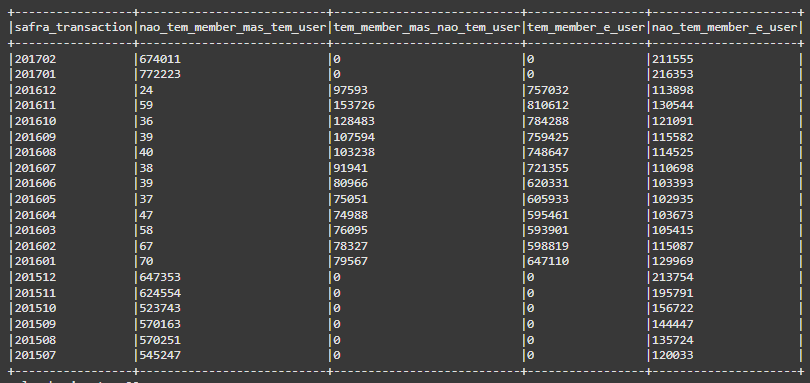

Somente a coluna de tem_member_mas_nao_tem_transaction e a coluna nao_tem_member_e_transaction são diferentes. Inclusive os numeros da coluna que não encontram registros nem na members nem na transaction, em contraste com as outras duas tabelas cai consideravelmente. Ou seja, na tabela user_logs há mais registros de dados que possuem ligação com outras tabelas.

#### 5.6.3.2 tem_member_mas_nao_tem_transaction

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_userlogs,
               t1.msno as msno_userlogs,
               t1.*,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t2.*,
               t3.safra as safra_transaction,
               t3.msno as msno_transaction,
               t3.*
        FROM tb_userlogs AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_transactions AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      WHERE msno_member IS NOT NULL AND msno_transaction IS NULL
    """
  ).show(truncate = False)
)

+--------------+--------------------------------------------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+------------+--------------------------------------------+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+-----------------+----------------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|safra_userlogs|msno_userlogs                               |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |safra_member|msno_member                                 |msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|safra_transaction|msno_transaction|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto

pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+-------------------

Cliente ativo ate a safra 07. Após isso ele ainda continuou escutando musica por mais de 3 meses.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+----+-----+----------------------+----+----+------+-

Aqui mostra o porque de não aparecer nas transações. Assinou um plano de mais de 1 ano.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+----+--

Porem apos o vencimento desse plano ele não renovou, mas ainda sim continou a escutar musica.

#### 5.6.3.3 nao_tem_member_e_transaction

In [ ]:
(spark.sql(
    """
      WITH
      join as (
        SELECT t1.safra as safra_userlogs,
               t1.msno as msno_userlogs,
               t1.*,
               t2.safra as safra_member,
               t2.msno as msno_member,
               t2.*,
               t3.safra as safra_transaction,
               t3.msno as msno_transaction,
               t3.*
        FROM tb_userlogs AS t1
        LEFT JOIN tb_members AS t2
        ON t1.msno = t2.msno and t1.safra = t2.safra
        LEFT JOIN tb_transactions AS t3
        ON t1.msno = t3.msno and t1.safra = t3.safra
      )
      SELECT *
      FROM join
      WHERE msno_member IS NULL AND msno_transaction IS NULL
    """
  ).show(truncate = False)
)

+--------------+--------------------------------------------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+------------+-----------+----+-----+----------------------+----+----+------+--------------+--------+-----------------+----------------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|safra_userlogs|msno_userlogs                               |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |safra_member|msno_member|msno|safra|registration_init_time|city|bd  |gender|registered_via|is_ativo|safra_transaction|msno_transaction|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+--------------+--------------------------------------------+---------------------

Pegando um caso

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_members AS t1
      LEFT JOIN tb_transactions AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++5HPICzApqAq9mYdGB/mdke0MbubM8yUKLOmrPt4xU='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+--------------------------------------------

Cliente assinou um plano de 30 dias após ficar bastante safras inativo, e pois esses 30 dias não renovou mas continuou ouvindo musica

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_transactions AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_userlogs AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++5HPICzApqAq9mYdGB/mdke0MbubM8yUKLOmrPt4xU='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------

somente 1 transação no ano de 2016.

In [ ]:
(spark.sql(
    """
      SELECT *
      FROM tb_userlogs AS t1
      LEFT JOIN tb_members AS t2
      ON t1.msno = t2.msno and t1.safra = t2.safra
      LEFT JOIN tb_transactions AS t3
      ON t1.msno = t3.msno and t1.safra = t3.safra
      WHERE t1.msno = '++5HPICzApqAq9mYdGB/mdke0MbubM8yUKLOmrPt4xU='
      ORDER BY t1.safra DESC
    """
  ).show(truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-----------------------------------------

Maioria das safras no qual ouviu musica em 2016 ele estava inativo.

# 6. Dicionario de dados FINAL & Ideias/Percepções

## 6.1 Tabela Members

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>Faixa esperada</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>-</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>city</td>
            <td>Dado demográfico, cidade do usuário, Categórica Nominal</td>
            <td>Int</td>
            <td>1 a 22</td>
            <td>21 cidades diferentes</td>
        </tr>
        <tr>
            <td>bd</td>
            <td>Dado demográfico, idade do usuário, Númerica Discreta</td>
            <td>Int</td>
            <td>1 a 125</td>
            <td>Outliers identificados</td>
        </tr>
        <tr>
            <td>gender</td>
            <td>Dado demográfico, gênero do usuário, Categorico Nominal(male or female)</td>
            <td>String</td>
            <td>-</td>
            <td>Possue maior parte dos dados nulos</td>
        </tr>
        <tr>
            <td>registered_via</td>
            <td>Meio pelo qual o cliente se cadastrou, Categorica Nominal</td>
            <td>Int</td>
            <td>-1 a 19</td>
            <td>17 meios diferentes de se registrar, nao tem o 15 e o 18.</td>
        </tr>
        <tr>
            <td>registration_init_time</td>
            <td>Data de quando o cliente se registrou no sistema</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2004-2016</td>
            <td>Primeiro registro de clientes em 2004, registros na ultima safra conhecida</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2016</td>
            <td>Temos safras de 2016-01-01 a 2016-12-01</td>
        </tr>
        <tr>
            <td>is_ativo</td>
            <td>Se o cliente esta ativo ou não naquela safra, Categorica nominal(0 ou 1)</td>
            <td>Int</td>
            <td>0-1</td>
            <td>Base carrega historico de clientes não ativos todas as safras</td>
        </tr>
    </tbody>
</table>


## 6.2 Tabela Transactions

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>Faixa esperada</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>payment_method_id</td>
            <td>Método de pagamento, Categorica Nominal</td>
            <td>Int</td>
            <td>1 a 41</td>
            <td>40 meios de pagamentos diferentes</td>
        </tr>
        <tr>
            <td>payment_plan_days</td>
            <td>Tamanho do plano em DIAS</td>
            <td>Int</td>
            <td>0 a 450</td>
            <td>37 quantidade de dias oferecidos diferentes</td>
        </tr>
        <tr>
            <td>plan_list_price</td>
            <td>Preço do respectivo plano em New Taiwan (NTD) </td>
            <td>Int</td>
            <td>0 a 2000</td>
            <td>51 valores de planos diferentes (sem casas decimais)</td>
        </tr>
        <tr>
            <td>actual_amount_paid</td>
            <td>Valor realmente pago naquela safra em relação ao Plan_list_price</td>
            <td>Int</td>
            <td>0 a 2000</td>
            <td>Há descontos aplicados, porem tambem há inconsistencias onde o actual é maior que o plan</td>
        </tr>
        <tr>
            <td>is_auto_renew</td>
            <td>Se a opção de renovação automatica está habilitada, Categorica Nominal (1 ou 0)</td>
            <td>Int</td>
            <td>0 e 1</td>
            <td>-</td>
        </tr>
        <tr>
            <td>transaction_date</td>
            <td>Data da transação</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2015 a 2017</td>
            <td>26 meses de janela</td>
        </tr>
        <tr>
            <td>membership_expire_date</td>
            <td>Quando o plano expira, necessitando da renovação se nao estiver automatica</td>
            <td>Date format yyyy-mm-dd</td>
            <td>1970 a 2017</td>
            <td>Valores anteriores a 2004 serão excluidos na definição do publico alvo</td>
        </tr>
        <tr>
            <td>is_cancel</td>
            <td>Se nessa transação o cliente cancelou ou não, Categorica Nominal (1 ou 0)</td>
            <td>Int</td>
            <td>0 e 1</td>
            <td>-</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2015 a 2017</td>
            <td>Temos safras de 2015-01-01 a 2017-02-01, 26 meses de janela</td>
        </tr>
    </tbody>
</table>


## 6.3 Tabela Userlogs

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>Temos safras de 2015-01-01 a 2017-02-01</td>
        </tr>
        <tr>
            <td>num_25</td>
            <td>Quantidade de músicas tocadas menos de 25% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_50</td>
            <td>Quantidade de músicas tocadas entre 25% e 50% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_75</td>
            <td>Quantidade de músicas tocadas entre 50% e 75% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_985</td>
            <td>Quantidade de músicas tocadas entre 75% e 98,5% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>    
            <td>num_100</td>
            <td>Quantidade de músicas tocadas acima de 98,5%</td>
            <td>INt</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>    
            <td>num_unq</td>
            <td>Quantidade de musicas tocadas apenas 1 vez</td>
            <td>INt</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>total_secs</td>
            <td>Total de segundos tocados</td>
            <td>Float</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
    </tbody>
</table>


## 6.4 Ideias/Percepções sobre as relações das tabelas

### 6.4.1 Ideias e percepções

1. A definição de que se um cliente está ativo ou não é inconsistente, não tendo uma regra clara que padronize para todos os casos que sejam 0 ou 1.

2. Clientes podem assinar e nem se quer ouvir 1 segundo de música.

3. Clientes podem estar ativos durante 1 ano sem transacionar, pois eles possuem um plano de assinatura superiores a 1 ano. Se podem ficar 1 ano sem transacionar podem tambem ficar sem ouvir 1 segundo de música e mesmo assim estarem ativos.

4. Para a definição do Churn, o público alvo pode ser: Clientes ativos na safra observada e que transacionaram pelo menos nos ultimos 410 dias. Assim, analisando o enunciado atenderia a regra do negocio e garantiria que aquele cliente não está com inconsistencias nas suas informações. Após isso, da para analisar o restante das definições de Churn abordadas no enunciado.

### 6.4.2 Ilustrando a ideia de fluxo de dados que as proximas etapas executarão

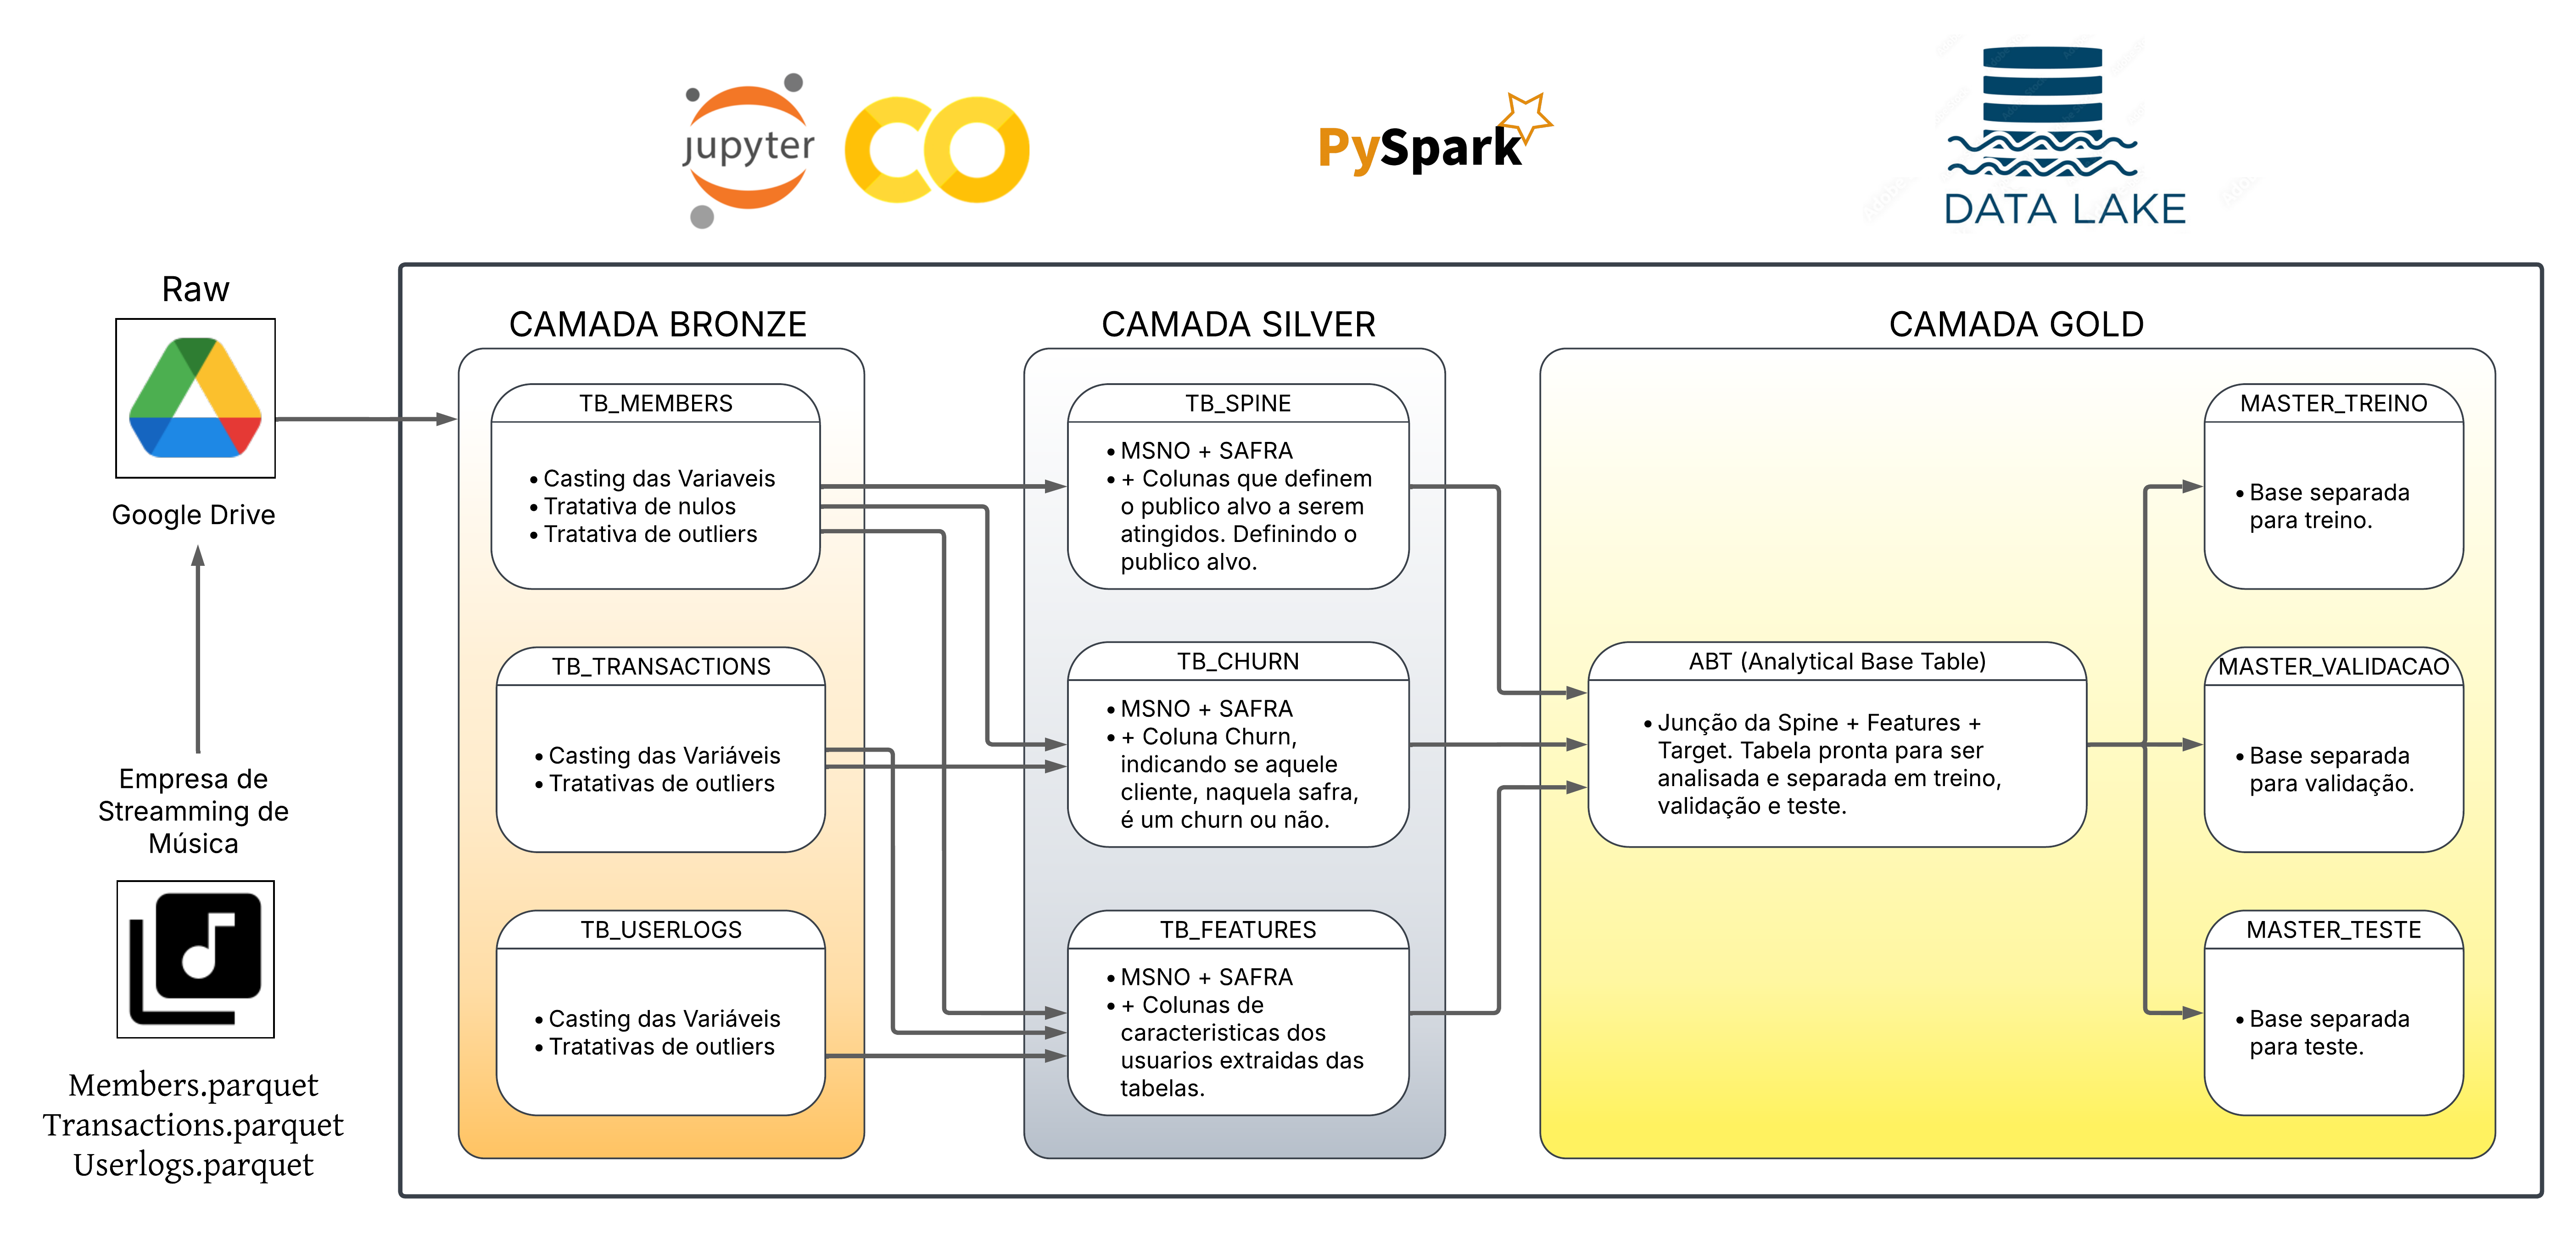

# 7. Construção da Bronze:


## 7.1 PASSOS


- Limpeza e tratamento dos dados
    - Conversão de tipos de dados (Casting);
    - Tratamento de Missing;
    - Tratamento de Outliers.

## 7.2 Limpeza e tratamento dos dados


### 7.2.1 Na TB_Members

#### 7.2.1.1 Passos

1. Members
  - **Casting das Variaveis**: (✅)
    - Mudança no tipo de dados do schema, pois alguns formatos estavam despadronizados, impedindo a consulta e utilização dos dados de forma correta.

  - **Tratamento das Idades** : (✅)
    - Decisão: Manter a variavel. Mesmo que mais de 50% dos dados são considerados outliers, ela pode agregar valor ao modelo nos proximos passos devido a idade ser um dado demográfico, que conforme discutido no livro "Data Science for Business" (Provost & Fawcett), variáveis demográficas ajudam a capturar tendências e padrões de consumo que muitas vezes são fundamentais para segmentação de usuários.
    - Não foi usado a Regra de Turkey pois o Upper Bound apresentado pela técnica é de 60 anos, perdendo as caracteristicas das pessoas com idade acima disso. Utilizando a métrica do Z-score também perde muita informação pois o minimo e maximo ficaram entre -10 e 9.
    - Explorar 3 caminhos:
        - Substituir os valores invalidos pela mediana e fazer a faixa etária (categorização dos dados);
        - Substituir os valores invalidos por -999 e fazer a faixa etária adicionando a categoria 'desconhecido'.
        - Substituir os valores invalidos por -999 e não categorizar, levando em consideração modelos que trabalham bem com os outliers e etc.
    
              Outra alternativa de tratamento seria utilizar modelos de imputação, como KNN (K-Nearest Neighbors)
              ou regressão, para prever os valores ausentes ou extremos com base em outras variáveis do conjunto
              de dados. Isso pode fornecer substituições mais precisas, mas também aumenta a complexidade do
              processamento e por isso não foi escolhida/explorada.

  - **Tratamento dos gêneros**: (✅)  
    - Há uma quantidade muito elevada de valores nulos. Considerando a abordagem de que a ausência de informação pode carregar características, será explorado adicionar a categoria "desconhecido" para o gênero no lugar dos valores nulos a fim de preservar as caracteristicas e não introduzir um vies nos dados. Após isso, e após a construção da target, é fundamental realizar a análise de correlação dessa variável para avaliar seu possivel descarte do problema (não só dessa variavel, de todas. Mas essa tem seu destaque de importância).



#### 7.2.1.2 Casting das variaveis

In [ ]:
bronze_members = (df_members.withColumn('city', col('city').cast('int'))
                            .withColumn('bd', col('bd').cast('int'))
                            .withColumn('registered_via', col('registered_via').cast('int'))
                            .withColumn('registration_init_time', to_date(col('registration_init_time'), 'yyyyMMdd'))
                            .withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))
                            .withColumn('is_ativo', col('is_ativo').cast('int'))
                            )


bronze_members.printSchema()

bronze_members.createOrReplaceTempView('tb_members_mod')

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)



#### 7.2.1.3 Tratamento da coluna de idade

##### 7.2.1.3.1 Passos

Para tratar a idade, iremos explorar 3 maneiras:

1. Segundo Tukey, no livro Exploratory Data Analysis, a mediana é uma medida robusta em relação a outliers, pois não é influenciada por valores extremos. Dessa forma, optou-se por substituir os outliers da coluna BD com base nos critérios de idades negativas, iguais a zero, ou superiores a 125 foram consideradas fora do padrão e substituídas pela mediana dos valores válidos (entre 1 e 125). Além disso, para reduzir ainda mais a sensibilidade a valores extremos e facilitar a identificação de padrões não lineares, as idades foram transformadas em categorias de faixas etárias, definidas como:

  - 1 a 12: Infantil
  - 13 a 19: Jovem
  - 20 a 30: Jovem Adulto
  - 31 a 59: Adulto
  - 60 a 125: Idoso

  Essas faixas foram pensadas com base em um índice do IBGE, e adaptadas ao problema. Com a adição da faixa "jovem adulto", foi entendido a importancia de capturar as características comportamentais musicais dessas faixas de idade, pois segundo o estudo "Práticas musicais de jovens e vida cotidiana: socialização e identidades em movimento" publicado pela revista da Universidade Federal do Paraná (UFPR) (fonte: https://revistas.ufpr.br/musica/article/download/38133/23289/0), a música desempenha um papel significativo na formação de identidades e na socialização dos jovens, especialmente quando mediada por tecnologias, sugerindo que os jovens tendem a vivenciar a música de maneira diferente em comparação com adultos mais velhos.

  Essa transformação também beneficia os modelos. Por exemplo, em árvores de decisão, variáveis categóricas simplificam as divisões no espaço de busca, simplificando cortes perpendiculares ao eixo da variável. Isso facilita a modelagem de relações não lineares, como as diferenças de comportamento entre jovens, jovens adultos e idosos.

  - **Aqui sera passado ao modelo as faixas etárias.**

2. Substituir os Missing ou invalidos por -999 e agregar mais uma faixa etária sendo:
  - 1 a 12: Infantil
  - 13 a 19: Jovem
  - 20 a 30: Jovem Adulto
  - 31 a 59: Adulto
  - 60 a 125: Idoso
  - Igual a -999: Desconhecido

  Explorar essa ideia é para testes, sem fundamentação e testar algumas ideias.

  - **Aqui será passado ao modelo as faixas etárias também.**

3. Substituir os valores invalidos por nulos, deixa-los nulos, pois para alguns modelos lidar com valores faltantes não é um problema, e não categorizar. Aqui essa ideia também é para testes, somente com a fundamentação de que há tipos de modelos que lidam com valores missing.  

  - **Aqui será passado ao modelo o valor das idades validos + nulos.**

##### 7.2.1.3.2 Tratamento

In [ ]:
print("Quantidade de linhas a serem afetadas em qualquer uma das 3 ideias.")
(spark.sql(
    """
    SELECT count(bd) as qnt_a_ser_afetada
    FROM tb_members_mod
    WHERE bd <= 0 or bd >= 125
    """
  ).show()
)

df_idade_tratada = (spark.sql(
    """
      -- Calculando a mediana para usar no tratamento das idades da primeira ideia
      WITH
      mediana_idade AS (
        SELECT percentile_approx(bd, 0.5) AS median_idade
        FROM tb_members_mod
        where bd > 0 and bd <= 125
      ),
      -- Selecionando o dataframe inteiro, alterando as idades que estiverem fora da faixa de idade 1 e 121 e substituindo pelo:
      -- valor da mediana(ideia 1);
      -- valor -999(ideia 2);
      -- ou nulo(ideia 3).
      tratando_idade AS (
        SELECT msno,
               safra,
               registered_via,
               city,
               CASE WHEN bd <= 0 OR bd >= 125 THEN (SELECT median_idade FROM mediana_idade) ELSE bd END AS new_bd_ideia1,
               CASE WHEN bd <= 0 OR bd >= 125 THEN -999 ELSE bd END AS new_bd_ideia2,
               CASE WHEN bd <= 0 OR bd >= 125 THEN NULL ELSE bd END AS new_bd_ideia3,
               gender,
               registration_init_time,
               is_ativo
        FROM tb_members_mod
      ),
      -- criando uma nova coluna categorizando as idades por faixas etarias
      tb_faixa_etaria AS (
        SELECT *,
              CASE
                  WHEN new_bd_ideia1 > 0 AND new_bd_ideia1 <= 12 THEN 'Infantil'
                  WHEN new_bd_ideia1 >= 13 AND new_bd_ideia1 <= 19 THEN 'Jovem'
                  WHEN new_bd_ideia1 >= 20 AND new_bd_ideia1 <= 30 THEN 'Jovem Adulto'
                  WHEN new_bd_ideia1 >= 31 AND new_bd_ideia1 <= 59 THEN 'Adulto'
                  WHEN new_bd_ideia1 >= 60 AND new_bd_ideia1 <= 125 THEN 'Idoso'
              END AS faixa_etaria_com_mediana,
              CASE
                  WHEN new_bd_ideia2 > 0 AND new_bd_ideia2 <= 12 THEN 'Infantil'
                  WHEN new_bd_ideia2 >= 13 AND new_bd_ideia2 <= 19 THEN 'Jovem'
                  WHEN new_bd_ideia2 >= 20 AND new_bd_ideia2 <= 30 THEN 'Jovem Adulto'
                  WHEN new_bd_ideia2 >= 31 AND new_bd_ideia2 <= 59 THEN 'Adulto'
                  WHEN new_bd_ideia2 >= 60 AND new_bd_ideia2 <= 125 THEN 'Idoso'
                  WHEN new_bd_ideia2 = -999 THEN 'Desconhecido'
              END AS faixa_etaria_com_desconhecido
        FROM tratando_idade
      )
      SELECT * FROM tb_faixa_etaria
    """
))

df_idade_tratada.show(20, truncate = False)

df_idade_tratada.createOrReplaceTempView('tb_idade_tratada')

Quantidade de linhas a serem afetadas em qualquer uma das 3 ideias.
+-----------------+
|qnt_a_ser_afetada|
+-----------------+
|         39516982|
+-----------------+

+--------------------------------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+
|msno                                        |safra     |registered_via|city|new_bd_ideia1|new_bd_ideia2|new_bd_ideia3|gender|registration_init_time|is_ativo|faixa_etaria_com_mediana|faixa_etaria_com_desconhecido|
+--------------------------------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|2016-12-01|7             |1   |27           |-999         |null         |null  |2014-09-27            |1       |Jovem Adulto            |Descon

In [ ]:
print("____________________________________________________________________")
print("___________________________IDEIA_1__________________________________")
print("____________________________________________________________________")
(spark.sql(
    """
      -- contando a quantidade de pessoas por faixa etaria e vendo a representatividade pela porcentagem de cada uma delas em relação ao total da IDEIA 1
      SELECT faixa_etaria_com_mediana,
             count(new_bd_ideia1) AS qnt_por_faixa,
             MIN(new_bd_ideia1) AS min_bd,
             MAX(new_bd_ideia1) AS max_bd,
             CONCAT(ROUND((qnt_por_faixa / (select count(*) from tb_idade_tratada)) * 100, 2), '%') AS taxa_por_faixa
      FROM tb_idade_tratada
      GROUP BY 1
      ORDER BY min_bd
    """
     ).show(truncate = False)
)

print("____________________________________________________________________")
print("___________________________IDEIA_2__________________________________")
print("____________________________________________________________________")

(spark.sql(
    """
      -- contando a quantidade de pessoas por faixa etaria e vendo a representatividade pela porcentagem de cada uma delas em relação ao total da IDEIA 2
      SELECT faixa_etaria_com_desconhecido,
             count(new_bd_ideia2) AS qnt_por_faixa,
             MIN(new_bd_ideia2) AS min_bd,
             MAX(new_bd_ideia2) AS max_bd,
             CONCAT(ROUND((qnt_por_faixa / (select count(*) from tb_idade_tratada)) * 100, 2), '%') AS taxa_por_faixa
      FROM tb_idade_tratada
      GROUP BY 1
      ORDER BY min_bd
    """
     ).show(truncate = False)
)

print("____________________________________________________________________")
print("___________________________IDEIA_3__________________________________")
print("____________________________________________________________________")

(spark.sql(
    """
      -- Entendendo as estatisticas gerais da idade na IDEIA 3
      SELECT min(new_bd_ideia3) AS min_bd,
             max(new_bd_ideia3) AS max_bd,
             avg(new_bd_ideia3) AS media_idade,
             percentile_approx(new_bd_ideia3, 0.5) AS mediana_idade,
             COUNT(*) AS qnt_total,
             SUM(CASE WHEN new_bd_ideia3 IS NULL THEN 1 ELSE 0 END) AS qnt_null,
             SUM(CASE WHEN new_bd_ideia3 IS NOT NULL THEN 1 ELSE 0 END) AS qnt_not_null,
             CONCAT(ROUND(( qnt_null / qnt_total) * 100, 2), '%') AS taxa_null,
             CONCAT(ROUND(( qnt_not_null / qnt_total) * 100, 2), '%') AS taxa_not_null
      FROM tb_idade_tratada
    """
     ).show(truncate = False)
)

(spark.sql(
    """
      -- Entendendo as estatisticas dividido por safra da idade na IDEIA 3
      SELECT safra,
             min(new_bd_ideia3) AS min_bd,
             max(new_bd_ideia3) AS max_bd,
             avg(new_bd_ideia3) AS media_idade,
             percentile_approx(new_bd_ideia3, 0.5) AS mediana_idade,
             COUNT(*) AS qnt_total,
             SUM(CASE WHEN new_bd_ideia3 IS NULL THEN 1 ELSE 0 END) AS qnt_null,
             SUM(CASE WHEN new_bd_ideia3 IS NOT NULL THEN 1 ELSE 0 END) AS qnt_not_null,
             CONCAT(ROUND(( qnt_null / qnt_total) * 100, 2), '%') AS taxa_null,
             CONCAT(ROUND(( qnt_not_null / qnt_total) * 100, 2), '%') AS taxa_not_null
      FROM tb_idade_tratada
      GROUP BY 1
      ORDER BY 1 DESC
    """
     ).show(truncate = False)
)

print("____________________________________________________________________")

____________________________________________________________________
___________________________IDEIA_1__________________________________
____________________________________________________________________
+------------------------+-------------+------+------+--------------+
|faixa_etaria_com_mediana|qnt_por_faixa|min_bd|max_bd|taxa_por_faixa|
+------------------------+-------------+------+------+--------------+
|Infantil                |14934        |1     |12    |0.02%         |
|Jovem                   |3326654      |13    |19    |5.21%         |
|Jovem Adulto            |51106791     |20    |30    |80.02%        |
|Adulto                  |9051335      |31    |59    |14.17%        |
|Idoso                   |367532       |60    |124   |0.58%         |
+------------------------+-------------+------+------+--------------+

____________________________________________________________________
___________________________IDEIA_2__________________________________
________________________

Da ideia 1 para a ideia 2, 60% dos dados entram na nova categoria de Desconhecido. Como isso vai impactar na segmentação dos clientes e entendimento dos comportamentos? Testaremos mais a frente. Por enquanto deixaremos essas colunas na tabela.

#### 7.2.1.4 Tratamento da coluna de gêneros

Agora com a idade tratada, vamos tratar dos gêneros.

A coluna de gênero apresenta uma grande proporção de valores nulos. Para evitar a perda de informações e manter a flexibilidade para análise futura, foi decidido substituir os valores nulos por "desconhecido", criando uma terceira categoria. Essa abordagem permite preservar a coluna na fase inicial do projeto, garantindo que todas as possibilidades sejam consideradas durante os passos após a criação da target. Posteriormente, com base em análises mais detalhadas e no impacto da variável no modelo, reavaliaremos se a coluna deve ser tratada de outra forma ou descartada. Mesma ideia usada no tratamendo da idade na ideia 2.

##### 7.2.1.4.1 Tratamento

In [ ]:
(spark.sql(
    """
        SELECT *,
               CASE WHEN gender IS NULL THEN 'desconhecido' ELSE gender END AS new_gender
        FROM tb_idade_tratada
    """
  ).createOrReplaceTempView('tb_members_mod')
)

In [ ]:
(spark.sql(
    """
      SELECT new_gender,
             count(new_gender) AS qnt_por_genero
      FROM tb_members_mod
      GROUP BY new_gender
      ORDER BY qnt_por_genero DESC
    """
  ).show()
)

+------------+--------------+
|  new_gender|qnt_por_genero|
+------------+--------------+
|desconhecido|      38210177|
|        male|      13075425|
|      female|      12581644|
+------------+--------------+



##### 7.2.1.4.2 Vantagens e Desvantagens de Usar uma nova categoria



###### Vantagens de usar "desconhecido":


  - **Preservação da informação**: Ao substituir os valores nulos por "desconhecido", você mantém a informação de ausência. Isso é importante porque a falta de dados pode carregar um sinal importante, especialmente em um contexto de comportamento de usuário (como churn ou transações).

  - **Redução do viés**: Em comparação com imputar um valor como a moda (que pode ser muito comum e não refletir a realidade), a abordagem de "desconhecido" pode ser uma forma de evitar viés, pois você não está fazendo uma suposição excessiva sobre o gênero do usuário. Em vez disso, você está tratando a falta de dados como uma categoria distinta.

  - **Flexibilidade para o modelo**: Dependendo do modelo que você escolher, ele pode aprender a distinguir entre usuários com gênero "desconhecido" e usuários com gênero conhecido. Modelos como árvores de decisão, por exemplo, podem tratar "desconhecido" como uma categoria separada, o que pode ser vantajoso.
  
  - **Equilíbrio entre viés e variância**: Substituir por "desconhecido" tende a reduzir o viés (pois não está fazendo uma suposição simplista) e ao mesmo tempo não aumenta demasiadamente a variância (como poderia acontecer se você tentasse prever ou imputar de forma muito complexa). Isso proporciona um bom equilíbrio entre as duas coisas.

###### Desvantagens e cuidados a serem tomados:
  

- **Possível perda de informações**: Se a variável "gênero" for muito importante para o modelo, o valor "desconhecido" pode dificultar a aprendizagem do modelo, especialmente se essa categoria "desconhecido" for muito prevalente. Em tal caso, o modelo pode não aprender bem os padrões relacionados ao gênero.

  - **Modelo mais conservador**: Se a proporção de valores "desconhecido" for alta, pode ser necessário adaptar o modelo para lidar com essa nova categoria de forma eficiente. Isso pode exigir mais ajustes de modelagem ou até o uso de técnicas específicas para lidar com dados ausentes.

  - **Desequilíbrio nas classes**: Se a substituição por "desconhecido" for feita de forma excessiva, pode ocorrer um desbalanceamento de classes, principalmente se o gênero "desconhecido" representar uma grande proporção da base. Isso pode afetar a performance do modelo, especialmente se ele não for treinado para lidar com desequilíbrios de classe.

###### Outros tipos de tratamentos consideraveis

Uma abordagem seria manter a proporção das classes conhecidas, e inputar essa mesma proporção aleatoriamente para os dados faltantes.

Mas o porque de não ter sido escolhida essa abordagem?

- Desvantagens dessa abordagem:

  - Não aproveita toda a informação disponível: Imputar aleatoriamente com base na proporção não considera as outras variáveis do seu dataset que poderiam ajudar a fazer uma imputação mais informada. Por exemplo, pode ser que o gênero de uma pessoa tenha alguma correlação com outras variáveis (como idade, região, etc.), e ao imputar aleatoriamente, você pode estar perdendo uma oportunidade de criar uma imputação mais robusta, que leve esses fatores em consideração.

  - Introdução de aleatoriedade nos dados: A imputação aleatória pode gerar um certo ruído no modelo, já que você está introduzindo incerteza onde antes havia um valor faltante. Dependendo da quantidade de dados faltantes, isso pode afetar a precisão e a qualidade dos modelos, principalmente se a quantidade de valores ausentes for significativa.

  - Impacto no aprendizado de máquina: Embora a distribuição do gênero seja preservada, a imputação aleatória pode não ser a melhor abordagem para modelos de aprendizado supervisionado. Alguns algoritmos podem ser sensíveis à introdução de valores "falsos", que são aleatórios e não correspondem à realidade do que o modelo deveria aprender.

  - Proporção inadequada para novos dados: A principal limitação dessa abordagem é que ela assume que a proporção de gênero observada no dataset é representativa para o universo como um todo. Caso o dataset tenha um viés (por exemplo, muito mais homens que mulheres), a imputação aleatória manterá esse viés. Além disso, quando o modelo for aplicado a novos dados, pode ser que a distribuição de gênero mude, o que pode impactar negativamente nos resultados.

- Algumas vantagens dessa abordagem:

  - Manutenção da distribuição original: Imputar os valores ausentes de acordo com a proporção observada nas classes já presentes (por exemplo, 60% masculino, 40% feminino) pode ser vantajoso, pois garante que a distribuição de gênero no conjunto de dados imputado seja semelhante à distribuição original. Isso ajuda a evitar que a imputação altere a estrutura do dataset, preservando a representatividade de cada classe.

  - Simplicidade e rapidez: Essa é uma técnica simples e rápida de aplicar. Você não precisa de algoritmos complexos para imputar os dados, o que pode ser vantajoso quando você tem um grande número de valores ausentes e precisa de uma solução prática e eficiente.

  - Evita viés sistemático: Caso você tenha uma distribuição desigual de classes no seu dataset, imputar valores faltantes com base na proporção original pode evitar um viés sistemático (como imputar apenas a classe majoritária, por exemplo).

fonte : https://medium.com/data-hackers/feature-engineering-t%C3%A9cnicas-para-lidar-com-dados-faltantes-em-um-projeto-de-ci%C3%AAncia-de-dados-debdd57eb662

Assim sendo escolhido outros caminhos para tratar o gênero. Mas se fosse feito, como ficaria aqui nos dados?

In [ ]:
total_filled = df_members.filter(col("gender").isNotNull()).count()
print(total_filled)

total_female = df_members.filter(col("gender") == "female").count()
print(total_female)

total_male = df_members.filter(col("gender") == "male").count()
print(total_male)

prob_female = total_female / total_filled
prob_male = total_male / total_filled

print(prob_female)
print(prob_male)

25657069
12581644
13075425
0.4903772913422028
0.5096227086577972


In [ ]:
# A coluna de gênero apresenta uma grande proporção de valores nulos. Para evitar a perda de informações potencialmente úteis e manter a flexibilidade para análise futura, foi decidido substituir os valores nulos por "nao informado".

total_filled = df_members.filter(col("gender").isNotNull()).count()
total_female = df_members.filter(col("gender") == "female").count()
total_male = df_members.filter(col("gender") == "male").count()

prob_female = total_female / total_filled
prob_male = total_male / total_filled


# Criar coluna de preenchimento proporcional
df_teste = df_members.withColumn(
    "gender",
    when(
        col("gender").isNull(),
        when(rand() <= prob_female, "female").otherwise("male")
    ).otherwise(col("gender"))
)

# Validar os resultados
df_teste.groupBy("gender").count().show()

df_teste.groupBy("gender").count().show()

aa = df_teste.groupBy("gender").count()

a1 = aa.collect()[0][1]
print(a1)
a2 = aa.collect()[1][1]
print(a2)

print(a1/(a1+a2))
print(a2/(a1+a2))

+------+--------+
|gender|   count|
+------+--------+
|female|31317121|
|  male|32550125|
+------+--------+

+------+--------+
|gender|   count|
+------+--------+
|female|31317121|
|  male|32550125|
+------+--------+

31317121
32550125
0.49034713348998954
0.5096528665100105


#### 7.2.1.5 Salvando as alterações finais para a bronze_members

Vendo a organização das colunas e vendo se não há nada a mais que deveria ser salvo na bronze.

In [ ]:
spark.sql("select * from tb_members_mod").show(5)

+--------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+------------+
|                msno|     safra|registered_via|city|new_bd_ideia1|new_bd_ideia2|new_bd_ideia3|gender|registration_init_time|is_ativo|faixa_etaria_com_mediana|faixa_etaria_com_desconhecido|  new_gender|
+--------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+------------+
|+++snpr7pmobhLKUg...|2016-12-01|             7|   1|           27|         -999|         null|  null|            2014-09-27|       1|            Jovem Adulto|                 Desconhecido|desconhecido|
|++/AwGzubug3gT6J+...|2016-07-01|             9|   1|           27|         -999|         null|  null|            2015-03-22|       0|            Jovem Adulto|                 Desconhecido

A coluna de genero original não há necessidade de salvar na bronze. As colunas de idade estão aparecendo 3 vezes para explorarmos as ideias de como usa-las, mas a idade original ja foi desconsiderada.

In [ ]:
bronze_members = (spark.sql(
    """
    select msno,
           safra,
           registered_via,
           city,
           new_bd_ideia1,
           faixa_etaria_com_mediana,
           new_bd_ideia2,
           faixa_etaria_com_desconhecido,
           new_bd_ideia3,
           new_gender,
           registration_init_time,
           is_ativo
    from tb_members_mod
    """
  )
)

bronze_members.show(5)

bronze_members.createOrReplaceTempView('bronze_members')

# bronze_members.write.mode("overwrite").parquet("/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/bronze")

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|  new_gender|registration_init_time|is_ativo|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|+++snpr7pmobhLKUg...|2016-12-01|             7|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2014-09-27|       1|
|++/AwGzubug3gT6J+...|2016-07-01|             9|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2015-03-22|       0|
|++/Gw1B9K+XOlB3hL..

### 7.2.2 Na TB_Transactions


#### 7.2.2.1 Passos

  - Casting das Variaveis
  - Tratamento das datas de vencimento do Plano

1. Transactions:
  - Colunas:
    - 1º 'mnso': id do usuário (string);
    - 2º 'payment_method_id': Método de pagamento, Númerico (int);
    - 3º 'payment_plan_days': tamanho do plano em DIAS (int);
    - 4º 'plan_list_price': preço do respectivo plano em New Taiwan Dollar (NTD) (Float/Double);
    - 5º 'actual_amount_paid': Total pago atual (nao entendi) (Float/Double);
    - 6º 'is_auto_renew': Renovação automatica (1 ou 0) (int);
    - 7º 'transaction_date': data da transação no formato yyy-mm-dd;
    - 8º 'membership_expire_date': quando o plano vence no formato yyyy-mm-dd;
    - 9º 'is_cancel': se nessa transação o cliente cancelou ou não o plano;
    - 10º 'safra': data ano e mes(int).




#### 7.2.2.2 Casting das variaveis

In [ ]:
bronze_transactions = (df_transactions.withColumn('payment_method_id', col('payment_method_id').cast('int'))
                                  .withColumn('payment_plan_days', col('payment_plan_days').cast('int'))
                                  .withColumn('plan_list_price', col('plan_list_price').cast('float'))
                                  .withColumn('actual_amount_paid', col('actual_amount_paid').cast('float'))
                                  .withColumn('is_auto_renew', col('is_auto_renew').cast('int'))
                                  .withColumn('transaction_date', to_date(col('transaction_date'), 'yyyyMMdd'))
                                  .withColumn('membership_expire_date', to_date(col('membership_expire_date'), 'yyyyMMdd'))
                                  .withColumn('is_cancel', col('is_cancel').cast('int'))
                                  .withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))

)

bronze_transactions.printSchema()

bronze_transactions.createOrReplaceTempView('bronze_transactions')

bronze_transactions.show(5)

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- safra: date (nullable = true)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|     safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|+++IZseRRiQS9aaSk...|             

#### 7.2.2.3 Tratamento da coluna data de expiração

Dos 1501 registros invalidos somente 38 impactam nossa problematica de fato. Vamos capturados e guardar os IDs deles para desconsiderarmos na hora de definirmos o publico alvo.

In [ ]:
ids_para_excluir = (spark.sql(
                      """
                        select msno
                        from bronze_transactions
                        where membership_expire_date < '2004-03-26' and safra >= '2016-01-01' and safra <= '2016-12-01'
                      """
                    )
                  ).rdd.map(lambda row: row.msno).collect()

display(len(ids_para_excluir))

38

### 7.2.3 Na TB_Userlogs


#### 7.2.3.1 Passos

3. User Logs
  - Casting das Variaveis não necessário. Somente converter a safra para data.
  - Tratamento do Total de Segundos ouvidos com a regra de turkey

#### 7.2.3.2 Casting da Safra

In [ ]:
df_userlogs = df_userlogs.withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))

df_userlogs.printSchema()

df_userlogs.createOrReplaceTempView('tb_userlogs_mod')

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



#### 7.2.3.3 Tratamento da coluna Total_secs

Com a regra de turkey ja aplicada nos estudos anteriores, vou construir a bronze_userlogs a partir da regra de turkey ja explorada.

In [ ]:
mediana_para_coletar = df_userlogs.select(col("total_secs")).summary()

mediana_total_secs = mediana_para_coletar.collect()[5]['total_secs']

print(mediana_total_secs)

58359.429000000004


In [ ]:
bronze_userlogs = (spark.sql(
    f"""
      SELECT msno,
             safra,
             num_25,
             num_50,
             num_75,
             num_985,
             num_100,
             num_unq,
             CASE WHEN total_secs < {low_bound_total_secs} THEN {mediana_total_secs}
                  WHEN total_secs > {upper_bound_total_secs} THEN {mediana_total_secs}
                  ELSE total_secs
             END AS total_secs
      FROM tb_userlogs_mod
    """
  ))

bronze_userlogs.createOrReplaceTempView('bronze_userlogs')

# bronze_userlogs.write.mode("overwrite").parquet("/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/bronze")

NameError: name 'low_bound_total_secs' is not defined

Por que o valor zero não entra para as regras? porque foi percebido que quando o valor é zero, de zero segundos ouvidos, o registro não é salvo na tabela daquela safra.

In [ ]:
bronze_userlogs.show(5)
bronze_userlogs.describe().show(truncate=False)

## 7.3 CONCLUSÕES & DICIONARIO DE DADOS DA BRONZE

### 7.4.1 CONCLUSÕES

A criação das Bronzes foi concluida, porem ainda nessa camada a criação da target não foi possivel apos diversos testes. Foi entendido que falta aprofundamento nas analises que serão feitas após a conclusão da criação das bronzes de cada tabela. Após o EDA das bronzes, a criação da target sera feita na camada Silver, junto com a criação ja das features.

### 7.4.2 DICIONARIO DE DADOS DA BRONZE

#### 7.4.2.1 BRONZE_MEMBERS

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>Faixa esperada</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>-</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>city</td>
            <td>Dado demográfico, cidade do usuário, Categórica Nominal</td>
            <td>Int</td>
            <td>1 a 22</td>
            <td>21 cidades diferentes</td>
        </tr>
        <tr>
            <td>new_bd_ideia1</td>
            <td>Dado demográfico, idade do usuário, Númerica Discreta</td>
            <td>Int</td>
            <td>1 a 125</td>
            <td>Outliers substituidos pela mediana 27</td>
        </tr>
        <tr>
            <td>faixa_etaria_com_mediana</td>
            <td>Idade categorizada em faixas</td>
            <td>String</td>
            <td>-</td>
            <td>5 faixas etárias(Infantil, Jovem, Jovem Adulto, Adulto e Idoso)</td>
        </tr>
        <tr>
            <td>new_bd_ideia2</td>
            <td>Dado demográfico, idade do usuário, Númerica Discreta</td>
            <td>Int</td>
            <td>-999, 1 a 125</td>
            <td>Outliers identificados</td>
        </tr>
        <tr>
            <td>faixa_etaria_com_desconhecido</td>
            <td>Idade categorizada em faixas</td>
            <td>String</td>
            <td>-</td>
            <td>6 faixas etárias(Desconhecido, Infantil, Jovem, Jovem Adulto, Adulto e Idoso)</td>
        </tr>
        <tr>
            <td>new_bd_ideia3</td>
            <td>Dado demográfico, idade do usuário, Númerica Discreta</td>
            <td>Int</td>
            <td>Null, 1 a 125</td>
            <td>Para usar com modelos que lidam/insensiveis com nulos.</td>
        </tr>
        <tr>
            <td>new_gender</td>
            <td>Dado demográfico, gênero do usuário, Categorico Nominal(male or female or desconhecido)</td>
            <td>String</td>
            <td>-</td>
            <td>Nulos tratados com 'desconhecido'</td>
        </tr>
        <tr>
            <td>registered_via</td>
            <td>Meio pelo qual o cliente se cadastrou, Categorica Nominal</td>
            <td>Int</td>
            <td>-1 a 19</td>
            <td>17 meios diferentes de se registrar, nao tem o 15 e o 18.</td>
        </tr>
        <tr>
            <td>registration_init_time</td>
            <td>Data de quando o cliente se registrou no sistema</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2004-2016</td>
            <td>Primeiro registro de clientes em 2004, registros na ultima safra conhecida</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2016</td>
            <td>Temos safras de 2016-01-01 a 2016-12-01</td>
        </tr>
        <tr>
            <td>is_ativo</td>
            <td>Se o cliente esta ativo ou não naquela safra, Categorica nominal(0 ou 1)</td>
            <td>Int</td>
            <td>0-1</td>
            <td>Base carrega historico de clientes não ativos todas as safras</td>
        </tr>
    </tbody>
</table>


#### 7.4.2.2 BRONZE_TRANSACTIONS

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>Faixa esperada</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>payment_method_id</td>
            <td>Método de pagamento, Categorica Nominal</td>
            <td>Int</td>
            <td>1 a 41</td>
            <td>40 meios de pagamentos diferentes</td>
        </tr>
        <tr>
            <td>payment_plan_days</td>
            <td>Tamanho do plano em DIAS</td>
            <td>Int</td>
            <td>0 a 450</td>
            <td>37 quantidade de dias oferecidos diferentes</td>
        </tr>
        <tr>
            <td>plan_list_price</td>
            <td>Preço do respectivo plano em New Taiwan (NTD) </td>
            <td>Int</td>
            <td>0 a 2000</td>
            <td>51 valores de planos diferentes (sem casas decimais)</td>
        </tr>
        <tr>
            <td>actual_amount_paid</td>
            <td>Valor realmente pago naquela safra em relação ao Plan_list_price</td>
            <td>Int</td>
            <td>0 a 2000</td>
            <td>Há descontos aplicados, porem tambem há inconsistencias onde o actual é maior que o plan</td>
        </tr>
        <tr>
            <td>is_auto_renew</td>
            <td>Se a opção de renovação automatica está habilitada, Categorica Nominal (1 ou 0)</td>
            <td>Int</td>
            <td>0 e 1</td>
            <td>-</td>
        </tr>
        <tr>
            <td>transaction_date</td>
            <td>Data da transação</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2015 a 2017</td>
            <td>26 meses de janela</td>
        </tr>
        <tr>
            <td>membership_expire_date</td>
            <td>Quando o plano expira, necessitando da renovação se nao estiver automatica</td>
            <td>Date format yyyy-mm-dd</td>
            <td>1970 a 2017</td>
            <td>Valores anteriores a 2004 serão excluidos na definição do publico alvo</td>
        </tr>
        <tr>
            <td>is_cancel</td>
            <td>Se nessa transação o cliente cancelou ou não, Categorica Nominal (1 ou 0)</td>
            <td>Int</td>
            <td>0 e 1</td>
            <td>-</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>2015 a 2017</td>
            <td>Temos safras de 2015-01-01 a 2017-02-01, 26 meses de janela</td>
        </tr>
    </tbody>
</table>


#### 7.4.2.3 BRONZE_USERLOGS

<table>
    <thead>
        <tr>
            <th>Feature</th>
            <th>Descrição</th>
            <th>Metadado</th>
            <th>OBS</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>msno</td>
            <td>id do usuário</td>
            <td>String</td>
            <td>Crucial para a conexão das tabelas</td>
        </tr>
        <tr>
            <td>safra</td>
            <td>Indica a data no qual 'fotos' das bases foram tiradas</td>
            <td>Date format yyyy-mm-dd</td>
            <td>Temos safras de 2015-01-01 a 2017-02-01</td>
        </tr>
        <tr>
            <td>num_25</td>
            <td>Quantidade de músicas tocadas menos de 25% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_50</td>
            <td>Quantidade de músicas tocadas entre 25% e 50% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_75</td>
            <td>Quantidade de músicas tocadas entre 50% e 75% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>num_985</td>
            <td>Quantidade de músicas tocadas entre 75% e 98,5% da duração dela</td>
            <td>Int</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>    
            <td>num_100</td>
            <td>Quantidade de músicas tocadas acima de 98,5%</td>
            <td>INt</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>    
            <td>num_unq</td>
            <td>Quantidade de musicas tocadas apenas 1 vez</td>
            <td>INt</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
        <tr>
            <td>total_secs</td>
            <td>Total de segundos tocados</td>
            <td>Float</td>
            <td>Não acumulativo, relativo somente ao que foi consumido na safra</td>
        </tr>
    </tbody>
</table>


# 7 RESUMO CRIAÇÃO DA BRONZE

## BRONZE MEMBERS

In [8]:
bronze_members = (df_members.withColumn('city', col('city').cast('int'))
                            .withColumn('bd', col('bd').cast('int'))
                            .withColumn('registered_via', col('registered_via').cast('int'))
                            .withColumn('registration_init_time', to_date(col('registration_init_time'), 'yyyyMMdd'))
                            .withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))
                            .withColumn('is_ativo', col('is_ativo').cast('int'))
                            )


bronze_members.printSchema()

bronze_members.createOrReplaceTempView('tb_members_mod')

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)



In [9]:
print("Quantidade de linhas a serem afetadas em qualquer uma das 3 ideias.")
(spark.sql(
    """
    SELECT count(bd) as qnt_a_ser_afetada
    FROM tb_members_mod
    WHERE bd <= 0 or bd >= 125
    """
  ).show()
)

df_idade_tratada = (spark.sql(
    """
      -- Calculando a mediana para usar no tratamento das idades da primeira ideia
      WITH
      mediana_idade AS (
        SELECT percentile_approx(bd, 0.5) AS median_idade
        FROM tb_members_mod
        where bd > 0 and bd <= 125
      ),
      -- Selecionando o dataframe inteiro, alterando as idades que estiverem fora da faixa de idade 1 e 121 e substituindo pelo:
      -- valor da mediana(ideia 1);
      -- valor -999(ideia 2);
      -- ou nulo(ideia 3).
      tratando_idade AS (
        SELECT msno,
               safra,
               registered_via,
               city,
               CASE WHEN bd <= 0 OR bd >= 125 THEN (SELECT median_idade FROM mediana_idade) ELSE bd END AS new_bd_ideia1,
               CASE WHEN bd <= 0 OR bd >= 125 THEN -999 ELSE bd END AS new_bd_ideia2,
               CASE WHEN bd <= 0 OR bd >= 125 THEN NULL ELSE bd END AS new_bd_ideia3,
               gender,
               registration_init_time,
               is_ativo
        FROM tb_members_mod
      ),
      -- criando uma nova coluna categorizando as idades por faixas etarias
      tb_faixa_etaria AS (
        SELECT *,
              CASE
                  WHEN new_bd_ideia1 > 0 AND new_bd_ideia1 <= 12 THEN 'Infantil'
                  WHEN new_bd_ideia1 >= 13 AND new_bd_ideia1 <= 19 THEN 'Jovem'
                  WHEN new_bd_ideia1 >= 20 AND new_bd_ideia1 <= 30 THEN 'Jovem Adulto'
                  WHEN new_bd_ideia1 >= 31 AND new_bd_ideia1 <= 59 THEN 'Adulto'
                  WHEN new_bd_ideia1 >= 60 AND new_bd_ideia1 <= 125 THEN 'Idoso'
              END AS faixa_etaria_com_mediana,
              CASE
                  WHEN new_bd_ideia2 > 0 AND new_bd_ideia2 <= 12 THEN 'Infantil'
                  WHEN new_bd_ideia2 >= 13 AND new_bd_ideia2 <= 19 THEN 'Jovem'
                  WHEN new_bd_ideia2 >= 20 AND new_bd_ideia2 <= 30 THEN 'Jovem Adulto'
                  WHEN new_bd_ideia2 >= 31 AND new_bd_ideia2 <= 59 THEN 'Adulto'
                  WHEN new_bd_ideia2 >= 60 AND new_bd_ideia2 <= 125 THEN 'Idoso'
                  WHEN new_bd_ideia2 = -999 THEN 'Desconhecido'
              END AS faixa_etaria_com_desconhecido
        FROM tratando_idade
      )
      SELECT * FROM tb_faixa_etaria
    """
))

df_idade_tratada.show(20, truncate = False)

df_idade_tratada.createOrReplaceTempView('tb_idade_tratada')

Quantidade de linhas a serem afetadas em qualquer uma das 3 ideias.
+-----------------+
|qnt_a_ser_afetada|
+-----------------+
|         39516982|
+-----------------+

+--------------------------------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+
|msno                                        |safra     |registered_via|city|new_bd_ideia1|new_bd_ideia2|new_bd_ideia3|gender|registration_init_time|is_ativo|faixa_etaria_com_mediana|faixa_etaria_com_desconhecido|
+--------------------------------------------+----------+--------------+----+-------------+-------------+-------------+------+----------------------+--------+------------------------+-----------------------------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|2016-12-01|7             |1   |27           |-999         |null         |null  |2014-09-27            |1       |Jovem Adulto            |Descon

In [10]:
(spark.sql(
    """
        SELECT *,
               CASE WHEN gender IS NULL THEN 'desconhecido' ELSE gender END AS new_gender
        FROM tb_idade_tratada
    """
  ).createOrReplaceTempView('tb_members_mod')
)

In [11]:
bronze_members = (spark.sql(
    """
    select msno,
           safra,
           registered_via,
           city,
           new_bd_ideia1,
           faixa_etaria_com_mediana,
           new_bd_ideia2,
           faixa_etaria_com_desconhecido,
           new_bd_ideia3,
           new_gender,
           registration_init_time,
           is_ativo
    from tb_members_mod
    """
  )
)

bronze_members.show(5)

bronze_members.createOrReplaceTempView('bronze_members')

# bronze_members.write.mode("overwrite").parquet("/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/bronze")

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|  new_gender|registration_init_time|is_ativo|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|+++snpr7pmobhLKUg...|2016-12-01|             7|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2014-09-27|       1|
|++/AwGzubug3gT6J+...|2016-07-01|             9|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2015-03-22|       0|
|++/Gw1B9K+XOlB3hL..

In [41]:
bronze_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- new_bd_ideia1: integer (nullable = true)
 |-- faixa_etaria_com_mediana: string (nullable = true)
 |-- new_bd_ideia2: integer (nullable = true)
 |-- faixa_etaria_com_desconhecido: string (nullable = true)
 |-- new_bd_ideia3: integer (nullable = true)
 |-- new_gender: string (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- is_ativo: integer (nullable = true)



## BRONZE TRANSACTIONS

In [12]:
bronze_transactions = (df_transactions.withColumn('payment_method_id', col('payment_method_id').cast('int'))
                                  .withColumn('payment_plan_days', col('payment_plan_days').cast('int'))
                                  .withColumn('plan_list_price', col('plan_list_price').cast('float'))
                                  .withColumn('actual_amount_paid', col('actual_amount_paid').cast('float'))
                                  .withColumn('is_auto_renew', col('is_auto_renew').cast('int'))
                                  .withColumn('transaction_date', to_date(col('transaction_date'), 'yyyyMMdd'))
                                  .withColumn('membership_expire_date', to_date(col('membership_expire_date'), 'yyyyMMdd'))
                                  .withColumn('is_cancel', col('is_cancel').cast('int'))
                                  .withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))

)

bronze_transactions.printSchema()

bronze_transactions.createOrReplaceTempView('bronze_transactions')

bronze_transactions.show(5)

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- safra: date (nullable = true)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|     safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|+++IZseRRiQS9aaSk...|             

In [13]:
ids_para_excluir = (spark.sql(
                      """
                        select msno
                        from bronze_transactions
                        where membership_expire_date < '2004-03-26' and safra >= '2016-01-01' and safra <= '2016-12-01'
                      """
                    )
                  ).rdd.map(lambda row: row.msno).collect()

display(len(ids_para_excluir))

38

## BRONZE USERLOGS

In [14]:
df_userlogs = df_userlogs.withColumn('safra', to_date(concat(col('safra').cast('string'), lit('01')), 'yyyyMMdd'))

df_userlogs.printSchema()

df_userlogs.createOrReplaceTempView('tb_userlogs_mod')

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



In [15]:
mediana_para_coletar = df_userlogs.select(col("total_secs")).summary()

mediana_total_secs = mediana_para_coletar.collect()[5]['total_secs']

print(mediana_total_secs)

58359.429000000004


In [16]:
quartis = (spark.sql(
    """
      SELECT
          percentile_approx(total_secs, 0.25) AS q1,
          percentile_approx(total_secs, 0.75) AS q3
      FROM tb_userlogs
    """
))

quartis.show()

q1 = quartis.collect()[0]['q1']
q3 = quartis.collect()[0]['q3']

iqr = q3 - q1

low_bound_total_secs = q1 - 1.5 * iqr
upper_bound_total_secs = q3 + 1.5 * iqr

print(f'low_bound: {low_bound_total_secs}, upper_bound: {upper_bound_total_secs}')

+---------+----------+
|       q1|        q3|
+---------+----------+
|11021.553|152111.487|
+---------+----------+

low_bound: -200613.348, upper_bound: 363746.38800000004


In [17]:
bronze_userlogs = (spark.sql(
    f"""
      SELECT msno,
             safra,
             num_25,
             num_50,
             num_75,
             num_985,
             num_100,
             num_unq,
             CASE WHEN total_secs < {low_bound_total_secs} THEN {mediana_total_secs}
                  WHEN total_secs > {upper_bound_total_secs} THEN {mediana_total_secs}
                  ELSE total_secs
             END AS total_secs
      FROM tb_userlogs_mod
    """
  ))

bronze_userlogs.createOrReplaceTempView('bronze_userlogs')

# bronze_userlogs.write.mode("overwrite").parquet("/content/drive/MyDrive/Colab Notebooks/data_master_VICTOR/bronze")

In [40]:
bronze_userlogs.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



# 8. Construção da Silver:

- Analise de Features e seleção
- Construção da Target
  - Entendimento da problematica
  - Definição do publico alvo e escopo
  - Criação da variavel dependente (Target)
- Criação das Features
  - Members
    - **Feature Engineering**: (⏭)
      - Quais variaveis podem surgir dessa tabela?
        - Características demográficas:
            - Faixa etária;
            - Cidade;
            - Gênero (se houver correlação).
        - Características relacionadas ao sistema:
            - Meio de registro;
            - Quantidade de dias de relacionamento com a empresa;

## 8.1 Definição do Público Alvo (spine)

### 8.1.1 Entendimento

Foi entendido e explorado que clientes ativos podem possuir um historico incoerente e relação incompleta com as outras tabelas, mas também há clientes que não transacionam a muito tempo pois assinaram um plano longo. Por isso, meu publico alvo será definido a partir de clientes ativos, e clientes que possuem ao menos 1 transação em todo o historico que possuimos na transactions. Vou me atentar aos clientes que não possuem nenhum historico na userlogs, mas se ele tem um historico na transactions e nao tem um na userlogs ele é apenas um usuario que assina mas não consome o plano que assina.

Outro ponto de atenção para a criação do público alvo é a maturação da base de dados. Como na tabela members só temos até a safra 2016-12, e queremos saber o historico 3 meses após a observação do usuario, usarei até a safra 2016-09.

### 8.1.2 Construindo o numero do historico do cliente na transactions

In [35]:
(spark.sql(
    """
      WITH
      df_trans_hist AS (
          SELECT t1.msno,
                 t1.safra,
                 COUNT(t2.msno) AS historico_transacoes
          FROM bronze_members t1
          LEFT JOIN bronze_transactions t2
          ON t1.msno = t2.msno AND t2.safra <= t1.safra
          GROUP BY t1.msno, t1.safra
      )
      SELECT t1.msno,
             t1.safra,
             t1.is_ativo,
             COALESCE(t2.historico_transacoes, 0) AS historico_transacoes
      FROM bronze_members t1
      LEFT JOIN df_trans_hist t2
      ON t1.msno = t2.msno AND t1.safra = t2.safra
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+----------+--------+--------------------+
|msno                                        |safra     |is_ativo|historico_transacoes|
+--------------------------------------------+----------+--------+--------------------+
|2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM=|2016-12-01|0       |0                   |
|2AxC8kEpLsy1hyEmt5BIo2UU2tCTDHTJy3kGvLu7nsQ=|2016-02-01|0       |0                   |
|66UL7KN/CDyvF2kGvA09RR4PW1WYIGQWRDrBT/Q8Myk=|2016-05-01|1       |13                  |
|AY+ScB4VYbA1XCZ0dNTkHa7+EexRcfVIJ5u+TnJY3qs=|2016-05-01|0       |9                   |
|DR+RD84FAntRiMPk5KqWQ2YkLE6QcsshBQVGj/zptsQ=|2016-05-01|0       |0                   |
|JfHFBJH0HBs9FXCPQvvJR5aNzkMmEqB1itTp3RumpWU=|2016-07-01|1       |13                  |
|JfHeHj24Q5LBXZlOf9Spr/PiR7KQd4+8khY7BQ7kBgU=|2016-03-01|0       |0                   |
|UIK9xeQfQUEJqmUwPI8ZNHIbNOeEWIprnEhWk1ICWvM=|2016-02-01|1       |10                  |
|ebtxhUp+ut8gI6VbH5CaJZ/ylgNqUb/

#### 8.1.2.1 testando um cliente com valor maior que 0

In [25]:
# UIK9xeQfQUEJqmUwPI8ZNHIbNOeEWIprnEhWk1ICWvM=|2016-02-01

(spark.sql(
    """
    select count(*) from bronze_transactions
    where msno = 'UIK9xeQfQUEJqmUwPI8ZNHIbNOeEWIprnEhWk1ICWvM=' and safra <= '2016-02-01'
    """
).show())

+--------+
|count(1)|
+--------+
|      10|
+--------+



#### 8.1.2.2 Testando um cliente igual a zero

In [33]:
# 2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM=|2016-12-01

(spark.sql(
    """
    select * from bronze_transactions
    where msno = '2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM='
    """
).show())

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+



In [29]:
# 2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM=|2016-12-01

(spark.sql(
    """
    select * from bronze_members
    where msno = '2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM='
    """
).show())

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|new_gender|registration_init_time|is_ativo|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+
|2AunVX/ubu6soCv4+...|2016-01-01|             3|   1|           21|            Jovem Adulto|           21|                 Jovem Adulto|           21|      male|            2015-09-27|       0|
|2AunVX/ubu6soCv4+...|2016-11-01|             3|   1|           21|            Jovem Adulto|           21|                 Jovem Adulto|           21|      male|            2015-09-27|       0|
|2AunVX/ubu6soCv4+...|2016-03-

In [36]:
# 2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM=|2016-12-01

(spark.sql(
    """
    select * from bronze_userlogs
    where msno = '2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM='
    """
).show())

+--------------------+----------+------+------+------+-------+-------+-------+------------------+
|                msno|     safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+------------------+
|2AunVX/ubu6soCv4+...|2015-09-01| 277.0|   6.0|   5.0|    6.0|   14.0|  294.0|7315.9169999999995|
|2AunVX/ubu6soCv4+...|2015-10-01|   0.0|   2.0|   1.0|    1.0|    0.0|    3.0|           517.472|
+--------------------+----------+------+------+------+-------+-------+-------+------------------+



### 8.1.3 Construindo o numero do historico do cliente na userlogs

In [43]:
(spark.sql(
    """
    WITH
    df_logs_hist AS (
        SELECT t1.msno,
               t1.safra,
               COUNT(t2.msno) AS historico_logs
        FROM bronze_members t1
        LEFT JOIN bronze_userlogs t2
        ON t1.msno = t2.msno AND t2.safra <= t1.safra
        GROUP BY t1.msno, t1.safra
    )
    SELECT t1.msno,
           t1.safra,
           t1.is_ativo,
           COALESCE(t2.historico_logs, 0) AS historico_logs
    FROM bronze_members t1
    LEFT JOIN df_logs_hist t2
    ON t1.msno = t2.msno AND t1.safra = t2.safra
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+----------+--------+--------------+
|msno                                        |safra     |is_ativo|historico_logs|
+--------------------------------------------+----------+--------+--------------+
|2AunVX/ubu6soCv4+sB7nyikB+w5W/J1GsD1L21U+hM=|2016-12-01|0       |2             |
|JfHFBJH0HBs9FXCPQvvJR5aNzkMmEqB1itTp3RumpWU=|2016-07-01|1       |19            |
|JfHeHj24Q5LBXZlOf9Spr/PiR7KQd4+8khY7BQ7kBgU=|2016-03-01|0       |2             |
|UIK9xeQfQUEJqmUwPI8ZNHIbNOeEWIprnEhWk1ICWvM=|2016-02-01|1       |14            |
|ebtxhUp+ut8gI6VbH5CaJZ/ylgNqUb/S4CxqeOCzb+4=|2016-08-01|1       |11            |
|hsxMFBsOb/YaoxD71SSSGPYoFZ6+/oJMt/TTwro6e6k=|2016-06-01|0       |10            |
|ht/wMcxjrzRtwkzhoeszixrrD18REhHXFIqhQgRQ6BE=|2016-11-01|0       |0             |
|++7jKYbuIJPXry8Oh1NcEh9fCsqcQgUaaxXsgG15kMg=|2016-07-01|0       |2             |
|1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc=|2016-03-01|0       |0             |
|2AxC8kEpLsy1hyE

#### 8.1.3.1 Testando com um valor maior que 1

In [47]:
# JfHFBJH0HBs9FXCPQvvJR5aNzkMmEqB1itTp3RumpWU=|2016-07-01
(spark.sql(
    """
    select count(*) from bronze_transactions
    where msno = 'JfHFBJH0HBs9FXCPQvvJR5aNzkMmEqB1itTp3RumpWU=' and safra <= '2016-07-01'
    """
).show())

+--------+
|count(1)|
+--------+
|      13|
+--------+



#### 8.1.3.2 Testando com um valor zero

In [48]:
# 1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc=|2016-03-01

(spark.sql(
    """
    select count(*) from bronze_transactions
    where msno = '1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc=' and safra <= '2016-03-01'
    """
).show())

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [49]:
(spark.sql(
    """
    select * from bronze_members
    where msno = '1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc='
    """
).show())

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|  new_gender|registration_init_time|is_ativo|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+
|1IMb3roBsL8apKalH...|2016-08-01|             7|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2014-06-13|       0|
|1IMb3roBsL8apKalH...|2016-10-01|             7|   1|           27|            Jovem Adulto|         -999|                 Desconhecido|         null|desconhecido|            2014-06-13|       0|
|1IMb3roBsL8apKalH..

In [50]:
(spark.sql(
    """
    select * from bronze_transactions
    where msno = '1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc='
    """
).show())

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+



In [51]:
(spark.sql(
    """
    select * from bronze_userlogs
    where msno = '1IMb3roBsL8apKalHKgX6JjT5kVclSazJ8FOAVQWRjc='
    """
).show())

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



### 8.1.4 Construindo a tb_spine

#### 8.1.4.1 Construção

In [44]:
(spark.sql(
    """
      WITH
      df_trans_hist AS (
          SELECT t1.msno,
                 t1.safra,
                 COUNT(t2.msno) AS historico_transacoes
          FROM bronze_members t1
          LEFT JOIN bronze_transactions t2
          ON t1.msno = t2.msno AND t2.safra <= t1.safra
          GROUP BY t1.msno, t1.safra
      )
      SELECT t1.msno,
             t1.safra,
             t1.is_ativo,
             COALESCE(t2.historico_transacoes, 0) AS historico_transacoes
      FROM bronze_members t1
      LEFT JOIN df_trans_hist t2
      ON t1.msno = t2.msno AND t1.safra = t2.safra
    """
  ).createOrReplaceTempView('tb_spine_hist_transact')
)

(spark.sql(
    """
    WITH
    df_logs_hist AS (
        SELECT t1.msno,
               t1.safra,
               COUNT(t2.msno) AS historico_logs
        FROM bronze_members t1
        LEFT JOIN bronze_userlogs t2
        ON t1.msno = t2.msno AND t2.safra <= t1.safra
        GROUP BY t1.msno, t1.safra
    )
    SELECT t1.msno,
           t1.safra,
           t1.is_ativo,
           COALESCE(t2.historico_logs, 0) AS historico_logs
    FROM bronze_members t1
    LEFT JOIN df_logs_hist t2
    ON t1.msno = t2.msno AND t1.safra = t2.safra
    """
  ).createOrReplaceTempView('tb_spine_hist_userlogs')
)

In [46]:
df_spine = (spark.sql(
    """
      SELECT t1.msno,
             t1.safra,
             t1.is_ativo,
             t2.historico_transacoes,
             t3.historico_logs
      FROM bronze_members as t1
      LEFT JOIN tb_spine_hist_transact as t2
      ON t1.msno = t2.msno AND t1.safra = t2.safra
      LEFT JOIN tb_spine_hist_userlogs as t3
      ON t1.msno = t3.msno AND t1.safra = t3.safra
      WHERE t1.safra <= '2016-09-01' AND t1.is_ativo = 1
    """
))

df_spine.show(20, truncate = False)

+--------------------------------------------+----------+--------+--------------------+--------------+
|msno                                        |safra     |is_ativo|historico_transacoes|historico_logs|
+--------------------------------------------+----------+--------+--------------------+--------------+
|fg6q4pOjxQ3xkLUwxWaWrFYhEx7SnDCNDYdhkoDAMO4=|2016-09-01|1       |21                  |21            |
|oEKkKYva6mREdIX+E38iBvjbNzfB6w7TMrBEPmRJ0qQ=|2016-09-01|1       |13                  |15            |
|pwXS5epdyKfb91q9yZbZIlGzK1Iv7tDeZz7Qxcelj3w=|2016-02-01|1       |14                  |14            |
|JfHFBJH0HBs9FXCPQvvJR5aNzkMmEqB1itTp3RumpWU=|2016-07-01|1       |13                  |19            |
|AYZVQ9JpKpraL4NGgkXK8xC7Iu0TBsB6uUxT/aC5Z34=|2016-02-01|1       |14                  |14            |
|UIK9xeQfQUEJqmUwPI8ZNHIbNOeEWIprnEhWk1ICWvM=|2016-02-01|1       |10                  |14            |
|ebtxhUp+ut8gI6VbH5CaJZ/ylgNqUb/S4CxqeOCzb+4=|2016-08-01|1       |11     

In [54]:
df_spine.createOrReplaceTempView('silver_spine')

df_spine.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- historico_transacoes: long (nullable = true)
 |-- historico_logs: long (nullable = true)



As colunas calculadas estão no formato 'long' que é equivalente ao float64 do pandas/numpy. Esse formato é desnecessário pois o valor maximo que é esperado armazenar é 21, e pode trazer ineficiencia pro ambiente. Vou converter para int.

In [55]:
df_spine = df_spine.withColumn('historico_transacoes', col('historico_transacoes').cast('int'))
df_spine = df_spine.withColumn('historico_logs', col('historico_logs').cast('int'))

df_spine.printSchema()

df_spine.createOrReplaceTempView('silver_spine')

root
 |-- msno: string (nullable = true)
 |-- safra: date (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- historico_transacoes: integer (nullable = true)
 |-- historico_logs: integer (nullable = true)



#### 8.1.4.2 Testando e estudando a spine criada

In [56]:
df_spine.describe().show()

(spark.sql(
    """
      select count(*) as total,
             count(distinct msno) as total_distinct,
             min(historico_transacoes) as min_historico_transacoes,
             max(historico_transacoes) as max_historico_transacoes,
             min(historico_logs) as min_historico_logs,
             max(historico_logs) as max_historico_logs
      from silver_spine
    """
).show())

+-------+--------------------+--------+--------------------+------------------+
|summary|                msno|is_ativo|historico_transacoes|    historico_logs|
+-------+--------------------+--------+--------------------+------------------+
|  count|             8144396| 8144396|             8144396|           8144396|
|   mean|                null|     1.0|    9.44050927779052|11.108048405308386|
| stddev|                null|     0.0|   6.237214763571158| 6.320575685625631|
|    min|+++FOrTS7ab3tIgIh...|       1|                   1|                 0|
|    max|zzz9+ZF4+GMyt63oU...|       1|                  21|                21|
+-------+--------------------+--------+--------------------+------------------+

+-------+--------------+------------------------+------------------------+------------------+------------------+
|  total|total_distinct|min_historico_transacoes|max_historico_transacoes|min_historico_logs|max_historico_logs|
+-------+--------------+------------------------+----

- **Do historico_transacoes:** O Máx de 21 safras indica o máximo possivel que um cliente pode repetir dentro dos limites da tabela transactions (2015-01 a 2016-09 - 21 meses, 12 + 9). O Min representa os clientes que ou aparecem a primeira vez e ultima, ou clientes que possuem uma assinatura de plano extensa.

- **Do historico_userlogs**: O Máx indica o mesmo. O Min pode ser zero, para clientes que assinam, transacionam mas não consomem nenhum segundo de musica.

- **Considerações Gerais**: Temos um total de 8M de registros, sendo 1,3M de clientes distintos.


Vamos entender a distribuição desses usuarios por quantidade de transações

In [62]:
(spark.sql(
    """
      select historico_transacoes,
             count(*) as total,
             count(distinct msno) as total_distinct,
             concat(round((total / (select count(*) from silver_spine))*100, 2), '%') as taxa_total,
             concat(round((total_distinct / (select count(*) from silver_spine))*100, 2), '%') as taxa_distinct,
             concat(round((total_distinct / total)*100, 2), '%') as taxa_distinct_total
      from silver_spine
      group by 1
      order by 1 DESC
    """
).show())

+--------------------+------+--------------+----------+-------------+-------------------+
|historico_transacoes| total|total_distinct|taxa_total|taxa_distinct|taxa_distinct_total|
+--------------------+------+--------------+----------+-------------+-------------------+
|                  21|202301|        202301|     2.48%|        2.48%|             100.0%|
|                  20|223825|        222225|     2.75%|        2.73%|             99.29%|
|                  19|248693|        246815|     3.05%|        3.03%|             99.24%|
|                  18|266955|        264011|     3.28%|        3.24%|              98.9%|
|                  17|335633|        331316|     4.12%|        4.07%|             98.71%|
|                  16|355913|        349730|     4.37%|        4.29%|             98.26%|
|                  15|441519|        432702|     5.42%|        5.31%|              98.0%|
|                  14|496002|        474001|     6.09%|        5.82%|             95.56%|
|         

In [63]:
(spark.sql(
    """
      select historico_transacoes,
             count(*) as total,
             count(distinct msno) as total_distinct,
             concat(round((total / (select count(*) from silver_spine))*100, 2), '%') as taxa_total,
             concat(round((total_distinct / (select count(*) from silver_spine))*100, 2), '%') as taxa_distinct,
             concat(round((total_distinct / total)*100, 2), '%') as taxa_distinct_total
      from silver_spine
      group by 1
      order by 1 ASC
    """
).show())

+--------------------+-------+--------------+----------+-------------+-------------------+
|historico_transacoes|  total|total_distinct|taxa_total|taxa_distinct|taxa_distinct_total|
+--------------------+-------+--------------+----------+-------------+-------------------+
|                   1|1083301|        505355|     13.3%|         6.2%|             46.65%|
|                   2| 613756|        386485|     7.54%|        4.75%|             62.97%|
|                   3| 466042|        335973|     5.72%|        4.13%|             72.09%|
|                   4| 367061|        311550|     4.51%|        3.83%|             84.88%|
|                   5| 323140|        286369|     3.97%|        3.52%|             88.62%|
|                   6| 310476|        280429|     3.81%|        3.44%|             90.32%|
|                   7| 306543|        280248|     3.76%|        3.44%|             91.42%|
|                   8| 282375|        258715|     3.47%|        3.18%|             91.62%|

Por que a taxa de distintos sobre o total vai caindo conforme a frequencia de transações diminui? Porque um cliente é observado e mais de uma safra sem transacionar novamente, logo a quantidade se mantem mas observando ele em uma safra diferente.

In [64]:
(spark.sql(
    """
      select safra,
             count(*) as total,
             count(distinct msno) as total_distinct,
             concat(round((total / (select count(*) from silver_spine))*100, 2), '%') as taxa_total,
             concat(round((total_distinct / (select count(*) from silver_spine))*100, 2), '%') as taxa_distinct,
             concat(round((total_distinct / total)*100, 2), '%') as taxa_distinct_total
      from silver_spine
      group by 1
      order by 1
    """
).show())

+----------+------+--------------+----------+-------------+-------------------+
|     safra| total|total_distinct|taxa_total|taxa_distinct|taxa_distinct_total|
+----------+------+--------------+----------+-------------+-------------------+
|2016-01-01|888663|        888663|    10.91%|       10.91%|             100.0%|
|2016-02-01|918116|        918116|    11.27%|       11.27%|             100.0%|
|2016-03-01|871651|        871651|     10.7%|        10.7%|             100.0%|
|2016-04-01|831565|        831565|    10.21%|       10.21%|             100.0%|
|2016-05-01|849653|        849653|    10.43%|       10.43%|             100.0%|
|2016-06-01|844884|        844884|    10.37%|       10.37%|             100.0%|
|2016-07-01|967936|        967936|    11.88%|       11.88%|             100.0%|
|2016-08-01|980643|        980643|    12.04%|       12.04%|             100.0%|
|2016-09-01|991285|        991285|    12.17%|       12.17%|             100.0%|
+----------+------+--------------+------

Pelo agrupamento das safras, essas taxas acabaram sendo repetidas pois dentro de cada safra não há clientes repetidos, nao surgindo muito efeito as 2 ultimas colunas. Mas no contexto geral os clientes estão bem distribuidos pelas safras.

## 8.2 Criação da Target

### 7.3.1 Entendimento da problematica

A ideia para definir a target é:

  - A nossa entidade são os Members, então a target estará presente nessa tabela.

  - A definição de churn dada no problema é:
    - Possuem uma assinatura ativa no período de análise (data da safra);
    - Não renovaram ou não estão mais ativos nos 3 meses subsequentes.

  - Na tabela Members, as informações que nos trazem isso são:
    - 'safra' - data de observação do cliente que tem que estar ativo;
    - 'is_ativo' - indicará se o cliente está ativo ou não naquela safra.

  - Para completar as infos, temos as informações da tabela Transactions para consultar:
    - 'safra' - Buscaremos 3 safras acima da safra de observação na members;
    - 'is_cancel' - Se nessas 3 safras acima ele cancelou ou não;
    - 'membership_expire_date' - Ou se nessas 3 safras a assinatura venceu e ele não renovou.

  - Dessa forma, na tabela members conseguiremos definir quem deu churn em 3 meses posteriores ou não.

  - Há dois caminhos para definir o Churn:
    1. Na tabela members temos a safra de 201601 a 201612. Para conseguirmos observar a safra 201612 na transaction, temos que ter safras na transaction até 201703, porem temos apenas até 201702, nao sendo possivel definir churn para essa safra pois nao temos a base de dados maturada. Então usariamos até a safra 201611 na members para ter os dados de 201702 na transaction.
    2. Usar somente a tabela members, a coluna is_ativo, indo somente até a safra 201609, para ter a maturação até 201612. Abordagem mais simples, podendo tambem ser completada com as informações na tabela transactions, porem com uma janela temporal menor.



Definição do CHURN.svg

### 7.3.2 Definição do publico alvo e escopo

O público alvo são clientes ATIVOS dentro das safras que possuímos maturação (201601 a 201611).

In [ ]:
(spark.sql(
    """
      select count(*)
      from bronze_members as t1
      left join bronze_transactions as t2
      on t1.msno = t2.msno and t1.safra = t2.safra
      where t1.is_ativo = 1 and t1.safra >= '2016-01-01' and t1.safra <= '2016-11-01'
    """
  ).show(20, truncate = False)
)

+--------+
|count(1)|
+--------+
|10264066|
+--------+



### 7.3.3 Criação da target jeito 1

In [ ]:
(spark.sql(
    """
      WITH tb_join AS (
        select t1.safra AS safra_observada,
               t1.msno AS cliente,
               t1.is_ativo,
               t2.safra AS safra_mais_3meses,
               t2.is_cancel,
               t2.membership_expire_date
        from bronze_members as t1
        left join tb_transactions_mod as t2
        on t1.msno = t2.msno and t2.safra = ADD_MONTHS(t1.safra, 3)
        where t1.safra >= '2016-01-01' and
              t1.safra <= '2016-11-01' and
              t1.is_ativo = 1
      ), tb_churn AS (
        select *,
              case when is_cancel = 1 or
                        membership_expire_date < safra_mais_3meses
                    then 1 else 0
                    end as churn
        from tb_join
      )
      select safra_observada,
             COUNT(cliente) as qnt_clientes,
             SUM(churn) as qnt_churn,
             CONCAT(ROUND((qnt_churn / qnt_clientes) * 100, 2), '%') as taxa_churn
      from tb_churn
      group by safra_observada
      order by safra_observada
    """
  ).show()
)

+---------------+------------+---------+----------+
|safra_observada|qnt_clientes|qnt_churn|taxa_churn|
+---------------+------------+---------+----------+
|     2016-01-01|      888663|    10907|     1.23%|
|     2016-02-01|      918116|    11553|     1.26%|
|     2016-03-01|      871651|     9648|     1.11%|
|     2016-04-01|      831565|    10019|      1.2%|
|     2016-05-01|      849653|    11337|     1.33%|
|     2016-06-01|      844884|    12078|     1.43%|
|     2016-07-01|      967936|    15048|     1.55%|
|     2016-08-01|      980643|    14881|     1.52%|
|     2016-09-01|      991285|    15463|     1.56%|
|     2016-10-01|     1048557|    17887|     1.71%|
|     2016-11-01|     1071113|    18193|      1.7%|
+---------------+------------+---------+----------+



### 7.3.3 Criação da target jeito 2

In [ ]:
(spark.sql(
    """
      WITH

      tb_join_3 AS (
        select t1.safra AS safra_observada_3,
               t1.msno AS cliente_3,
               t1.is_ativo AS is_ativo_3,
               t2.safra AS safra_mais_3meses,
               t2.is_cancel AS is_cancel_3,
               t2.membership_expire_date AS membership_expire_date_3
        from bronze_members as t1
        left join tb_transactions_mod as t2
        on t1.msno = t2.msno and t2.safra = ADD_MONTHS(t1.safra, 3)
        where t1.safra >= '2016-01-01' and
              t1.safra <= '2016-11-01' and
              t1.is_ativo = 1
      ),

      tb_join_2 AS (
        select t1.safra AS safra_observada_2,
               t1.msno AS cliente_2,
               t1.is_ativo AS is_ativo_2,
               t2.safra AS safra_mais_2meses,
               t2.is_cancel AS is_cancel_2,
               t2.membership_expire_date AS membership_expire_date_2
        from bronze_members as t1
        left join tb_transactions_mod as t2
        on t1.msno = t2.msno and t2.safra = ADD_MONTHS(t1.safra, 2)
        where t1.safra >= '2016-01-01' and
              t1.safra <= '2016-11-01' and
              t1.is_ativo = 1
        ),

        tb_join_1 as (
          select t1.safra AS safra_observada_1,
               t1.msno AS cliente_1,
               t1.is_ativo AS is_ativo_1,
               t2.safra AS safra_mais_1meses,
               t2.is_cancel AS is_cancel_1,
               t2.membership_expire_date AS membership_expire_date_1
        from bronze_members as t1
        left join tb_transactions_mod as t2
        on t1.msno = t2.msno and t2.safra = ADD_MONTHS(t1.safra, 1)
        where t1.safra >= '2016-01-01' and
              t1.safra <= '2016-11-01' and
              t1.is_ativo = 1
        ),

        tb_join_all AS (
          SELECT ts.safra,
                 ts.msno,
                 t3.safra_mais_3meses,
                 t3.is_cancel_3,
                 t3.membership_expire_date_3,
                 t2.safra_mais_2meses,
                 t2.is_cancel_2,
                 t2.membership_expire_date_2,
                 t1.safra_mais_1meses,
                 t1.is_cancel_1,
                 t1.membership_expire_date_1
          FROM bronze_members AS ts
          LEFT JOIN tb_join_3 AS t3
          ON ts.msno = t3.cliente_3 AND ts.safra = t3.safra_observada_3
          LEFT JOIN tb_join_2 AS t2
          ON ts.msno = t2.cliente_2 AND ts.safra = t2.safra_observada_2
          LEFT JOIN tb_join_1 AS t1
          ON ts.msno = t1.cliente_1 AND ts.safra = t1.safra_observada_1
        ),
        tb_churn as (
          select *,
                case when is_cancel_3 = 1 or membership_expire_date_3 < safra_mais_3meses then 1 else 0 end as churn_3,
                case when is_cancel_2 = 1 or membership_expire_date_2 < safra_mais_2meses then 1 else 0 end as churn_2,
                case when is_cancel_1 = 1 or membership_expire_date_1 < safra_mais_1meses then 1 else 0 end as churn_1,
                case when churn_3 = 1 and churn_2 = 1 and churn_1 = 1 then 1 else 0 end as erro_todos,
                case when churn_3 = 1 and churn_2 = 1 then 1 else 0 end as erro_3_2,
                case when churn_3 = 1 and churn_1 = 1 then 1 else 0 end as erro_3_1,
                case when churn_2 = 1 and churn_1 = 1 then 1 else 0 end as erro_2_1,
                case when churn_3 + churn_2 + churn_1 = 1 then 1 else 0 end as churn_ok
          from tb_join_all
        )
        select sum(churn_3) as churn_3,
               sum(churn_2) as churn_2,
               sum(churn_1) as churn_1,
               sum(churn_ok) as churn_ok,
               sum(erro_todos) as erro_todos,
               sum(erro_3_2) as erro_3_2,
               sum(erro_3_1) as erro_3_1,
               sum(erro_2_1) as erro_2_1
        from tb_churn
    """
  ).show()
)

### 7.3.3 Criação da target jeito 3

adotar window funcions

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

win_member_target = Window.partitionBy('msno').orderBy('safra').rowsBetween(1, 3)

members_churn = (
    bronze_members
    # Verificar se o cliente deu churn nos próximos 3 meses
    .withColumn("churn_next_3_months",
                F.max(
                    F.when(F.col("is_ativo") == 0, 1)   # Se o cliente não está mais ativo
                    .otherwise(0)
                    )                     # Caso contrário, 0
                .over(win_member_target))
    # Definir o churn final
    .withColumn("churn", F.when(F.col("churn_next_3_months") == 1, 1).otherwise(0))
    # Filtrar apenas clientes ativos na safra observada
    .filter(F.col("is_ativo") == 1)
    .filter(F.col("safra") <= '2016-09-01')
    # Dropa colunas auxiliares
    .drop("churn_next_3_months")
)

members_churn.filter(F.col('churn') == 1).orderBy('safra').show(20, truncate=False)

+--------------------------------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+-----+
|msno                                        |safra     |registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|new_gender  |registration_init_time|is_ativo|churn|
+--------------------------------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+------------+----------------------+--------+-----+
|+WeSHyNpY/VeS/VM0xaW/1P74epGKrUsnv6l1bnIXoM=|2016-01-01|7             |4   |27           |Jovem Adulto            |-999         |Desconhecido                 |null         |desconhecido|2013-06-10            |1       |1    |
|+Y4HkgdQbxXGnq+c0FloYfk+T5Cvtpt25HpCuH5NASQ=|2016-01-01|7             |1   |27           |Jovem

In [ ]:
members_churn.filter(F.col('msno') == '++7jKYbuIJPXry8Oh1NcEh9fCsqcQgUaaxXsgG15kMg=').show()

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+-----+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|new_gender|registration_init_time|is_ativo|churn|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+-----+
|++7jKYbuIJPXry8Oh...|2016-03-01|             3|   6|           25|            Jovem Adulto|           25|                 Jovem Adulto|           25|    female|            2014-09-09|       1|    1|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+-----+


In [ ]:
bronze_members.filter(F.col('msno') == '++7jKYbuIJPXry8Oh1NcEh9fCsqcQgUaaxXsgG15kMg=').orderBy('safra').show()

+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+
|                msno|     safra|registered_via|city|new_bd_ideia1|faixa_etaria_com_mediana|new_bd_ideia2|faixa_etaria_com_desconhecido|new_bd_ideia3|new_gender|registration_init_time|is_ativo|
+--------------------+----------+--------------+----+-------------+------------------------+-------------+-----------------------------+-------------+----------+----------------------+--------+
|++7jKYbuIJPXry8Oh...|2016-01-01|             3|   6|           25|            Jovem Adulto|           25|                 Jovem Adulto|           25|    female|            2014-09-09|       0|
|++7jKYbuIJPXry8Oh...|2016-02-01|             3|   6|           25|            Jovem Adulto|           25|                 Jovem Adulto|           25|    female|            2014-09-09|       0|
|++7jKYbuIJPXry8Oh...|2016-03-

In [ ]:
df_userlogs.filter(F.col('msno') == '++7jKYbuIJPXry8Oh1NcEh9fCsqcQgUaaxXsgG15kMg=').orderBy('safra').show()

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|     safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|++7jKYbuIJPXry8Oh...|2015-02-01|   0.0|   0.0|   1.0|    0.0|    0.0|    1.0|   150.367|
|++7jKYbuIJPXry8Oh...|2016-03-01|   3.0|   3.0|   1.0|    2.0|    4.0|   13.0|  1954.355|
+--------------------+----------+------+------+------+-------+-------+-------+----------+



In [ ]:
df_transactions.filter(F.col('msno') == '++7jKYbuIJPXry8Oh1NcEh9fCsqcQgUaaxXsgG15kMg=').orderBy('safra').show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|++7jKYbuIJPXry8Oh...|               38|               10|              0|                 0|            0|        20160312|              20160322|        0|201603|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+



### 7.3.4 Tentativa 4

Decidi separas as variaveis que definirão o churn em uma tabela chamada "tb_churn"

Essa tabela será criada a partir da tabela members, pois assim, sendo ela a tabela da entidade do problema, e a partir dela teremos o registro correspondente nas outras.

Selecionarei:
  - Id e Safra: Primary Key composta;
  - Is_ativo: Se o cliente está ativo ou não naquela safra;
  - Membership_expire_date: com essa informação, conseguimos contornar o caso de clientes que somente não renovam a assinatura;
  - Is_cancel: Se naquela linha houve um cancelamento ou não.

In [ ]:
(spark.sql(
    f"""
        select bronze_members.msno,
               bronze_members.safra,
               bronze_members.is_ativo,
               bronze_transactions.membership_expire_date,
               bronze_transactions.is_cancel
        from bronze_members
        left join bronze_transactions
        on bronze_members.msno = bronze_transactions.msno and bronze_members.safra = bronze_transactions.safra
    """
  ).createOrReplaceTempView('tb_churn')
)

In [ ]:
win_target_chun = Window.partitionBy('msno').orderBy('safra')

tb_churn = (spark.sql("select * from tb_churn"))

tb_churn = (tb_churn
            .withColumn("is_ativo_depois_de_3m", lead(col("is_ativo"), 3).over(win_target_chun))
            .withColumn("is_cancel_depois_de_3m", lead(col("is_cancel"), 3).over(win_target_chun))
            .withColumn("membership_expire_date_depois_de_3m", lead(col("membership_expire_date"), 3).over(win_target_chun))
           )

tb_churn = tb_churn.filter((col("safra") <= '2016-09-01') &
                           (col("is_ativo") == 1))

tb_churn.show(20, truncate=False)
tb_churn.createOrReplaceTempView('tb_churn')

+--------------------------------------------+----------+--------+----------------------+---------+---------------------+----------------------+-----------------------------------+
|msno                                        |safra     |is_ativo|membership_expire_date|is_cancel|is_ativo_depois_de_3m|is_cancel_depois_de_3m|membership_expire_date_depois_de_3m|
+--------------------------------------------+----------+--------+----------------------+---------+---------------------+----------------------+-----------------------------------+
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2016-01-01|1       |2016-02-13            |0        |1                    |0                     |2016-05-13                         |
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2016-02-01|1       |2016-03-13            |0        |1                    |0                     |2016-06-13                         |
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2016-03-01|1       |2016-04-13            |0     

In [ ]:
tb_churn = (tb_churn
            .withColumn("churn", when((col("is_ativo_depois_de_3m") == 0) |
                                      (col("is_cancel_depois_de_3m") == 1) &
                                      (col("membership_expire_date") <= add_months(col("safra"), 3)), 1)
                                 .otherwise(0))
           )

tb_churn.createOrReplaceTempView('tb_churn')

In [ ]:
(spark.sql(
    """
        SELECT safra,
               COUNT(*) as total,
               SUM(CASE WHEN churn = 1 THEN 1 ELSE 0 END) AS total_churn,
               CONCAT(ROUND((total_churn / total) * 100, 2), '%') AS taxa_churn
        FROM tb_churn
        GROUP BY 1
        ORDER BY 1
    """
  ).show(20, truncate = False)
)

+----------+------+-----------+----------+
|safra     |total |total_churn|taxa_churn|
+----------+------+-----------+----------+
|2016-01-01|888663|193683     |21.79%    |
|2016-02-01|918116|194382     |21.17%    |
|2016-03-01|871651|145754     |16.72%    |
|2016-04-01|831565|98320      |11.82%    |
|2016-05-01|849653|111119     |13.08%    |
|2016-06-01|844884|108656     |12.86%    |
|2016-07-01|967936|119772     |12.37%    |
|2016-08-01|980643|137538     |14.03%    |
|2016-09-01|991285|143804     |14.51%    |
+----------+------+-----------+----------+



In [ ]:
# 7 min

(spark.sql(
    """
        SELECT safra,
               COUNT(*) as total,
               SUM(CASE WHEN churn = 1 THEN 1 ELSE 0 END) AS total_churn,
               CONCAT(ROUND((total_churn / total) * 100, 2), '%') AS taxa_churn
        FROM tb_churn
        GROUP BY 1
        ORDER BY 1
    """
  ).show(20, truncate = False)
)

+----------+------+-----------+----------+
|safra     |total |total_churn|taxa_churn|
+----------+------+-----------+----------+
|2016-01-01|888663|193683     |21.79%    |
|2016-02-01|918116|194382     |21.17%    |
|2016-03-01|871651|145754     |16.72%    |
|2016-04-01|831565|98320      |11.82%    |
|2016-05-01|849653|111119     |13.08%    |
|2016-06-01|844884|108656     |12.86%    |
|2016-07-01|967936|119772     |12.37%    |
|2016-08-01|980643|137538     |14.03%    |
|2016-09-01|991285|143804     |14.51%    |
+----------+------+-----------+----------+



In [ ]:
# 7 min
tb_churn_summary = (tb_churn
    .groupBy("safra")
    .agg(
        count("*").alias("total"),
        sum(when(col("churn") == 1, 1).otherwise(0)).alias("total_churn")
    )
    .withColumn("taxa_churn",
                concat(round((col("total_churn") / col("total")) * 100, 2), lit("%")))
    .orderBy("safra")
)

tb_churn_summary.show(20, truncate=False)

+----------+------+-----------+----------+
|safra     |total |total_churn|taxa_churn|
+----------+------+-----------+----------+
|2016-01-01|888663|193683     |21.79%    |
|2016-02-01|918116|194382     |21.17%    |
|2016-03-01|871651|145754     |16.72%    |
|2016-04-01|831565|98320      |11.82%    |
|2016-05-01|849653|111119     |13.08%    |
|2016-06-01|844884|108656     |12.86%    |
|2016-07-01|967936|119772     |12.37%    |
|2016-08-01|980643|137538     |14.03%    |
|2016-09-01|991285|143804     |14.51%    |
+----------+------+-----------+----------+



In [ ]:
(spark.sql(
    """
        select *
        from tb_members
        left join tb_transactions
        on tb_members.msno = tb_transactions.msno and tb_members.safra = tb_transactions.safra
        left join tb_userlogs
        on tb_members.msno = tb_userlogs.msno and tb_members.safra = tb_userlogs.safra
        where tb_members.is_ativo = 1 and tb_transactions.msno is null
        order by tb_members.msno, tb_members.safra
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+----+-----------------+-----------------+---------------+------------------+-------------+----------------+-------------------

In [ ]:
(spark.sql(
    """
        select *
        from tb_transactions
        where msno = '+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s='
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788           |1788              |0            |20151121        |20170104              |0        |201511|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+



In [ ]:
(spark.sql(
    """
        select *
        from tb_userlogs
        where msno = '+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s='
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201511|3.0   |3.0   |2.0   |2.0    |3014.0 |2610.0 |749646.5129999999 |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201501|16.0  |8.0   |14.0  |8.0    |1831.0 |1472.0 |446494.575        |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201509|10.0  |7.0   |8.0   |3.0    |2862.0 |2530.0 |722737.0679999999 |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201701|89.0  |9.0   |14.0  |9.0    |1119.0 |1153.0 |276006.651        |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201604|122.0 |29.0  |27.0  |15.0   |2060.0 |2110.0 |494953.83600000007|
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201505|19.

In [ ]:
(spark.sql(
    """
        select *
        from tb_members
        where msno = '+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s='
    """
  ).show(20, truncate = False)
)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201603|20121224              |6   |22 |female|3             |1       |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201601|20121224              |6   |22 |female|3             |1       |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201611|20121224              |6   |22 |female|3             |1       |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201602|20121224              |6   |22 |female|3             |1       |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201609|20121224              |6   |22 |female|3             |1       |
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201605|20121224   

# 9. Construção da Gold



- Analytical Base Table (ABT)
- Features e Target estruturados e prontos para irem para treino, validação e teste dos modelos

# 10. Criação dos modelos


qual metodologia seguir

(seleção de variaveis, modelos (por que dos modelos, por que nao explorar outros))

(interpretabilidade X performance)

(caso haja, como foi feita a escolha de hiperparametros)

(tota decisão ser justificada, comparada)

((avaliar performance dos modelos), (estabilidade, performance, explicabilidade), (treinamento de modelos por janelas de tempo, out of time))

(Shaply Values, )

In [ ]:
(spark.sql(
    """
      SHOW TABLES IN global_temp
    """
  ).show()
)

+---------+-------------------+-----------+
|namespace|          tableName|isTemporary|
+---------+-------------------+-----------+
|         |     bronze_members|       true|
|         |bronze_transactions|       true|
|         |    bronze_userlogs|       true|
|         |           tb_churn|       true|
|         |   tb_idade_tratada|       true|
|         |         tb_members|       true|
|         |     tb_members_mod|       true|
|         |    tb_transactions|       true|
|         |tb_transactions_mod|       true|
|         |        tb_userlogs|       true|
|         |    tb_userlogs_mod|       true|
+---------+-------------------+-----------+

